In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from numba import jit

## Stimulus generation (cf. Figure 1B and 1D of Bhattacharyya et. al 2017)

In [3]:
def generate_stimulus(stim_size=1, speed=1, length=10, dt=0.1, init_distance=50):
    timesteps = np.arange(int(length/dt))*dt
    distances = init_distance - timesteps*speed
    angles = np.arctan2(stim_size/2, distances)*2
    angles_degrees = angles/np.pi*180
    return timesteps, angles_degrees, distances

[ 131.57894737   65.78947368   44.64285714   33.78378378   26.88172043
   22.52252252]


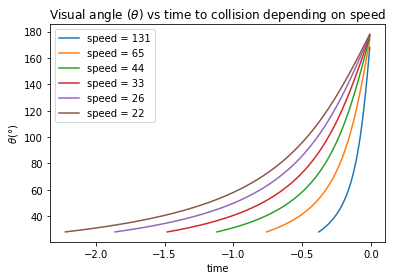

In [4]:
# these values are taken from Bhattacharyya et. al 2017:
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 25
speeds = 1/(LV_vals/stim_size)
print(speeds)

#plt.figure(figsize=(8,8))
for speed in speeds:
    t, stims, dists = generate_stimulus(stim_size=stim_size, speed=speed, dt=0.01)
    collision_idx = np.argmin(np.abs(dists))
    t_collision = t[collision_idx]
    stim_collision = stims[collision_idx]
    
    before_collision_mask = t<t_collision
    t_to_collision = t[before_collision_mask] - t_collision
    stim_to_collision = stims[before_collision_mask]
    plt.plot(t_to_collision, stim_to_collision, label='speed = ' + str(int(speed)))
plt.xlabel('time')
plt.ylabel(r'$\theta (\degree)$')
plt.title(r'Visual angle ($\theta$) vs time to collision depending on speed')
plt.legend()
#print(dists)

## Linear function of visual angle

In [5]:
def f_theta_linear(theta, m, b):
    return theta*m + b

def transform_stim(stim_size, speed, length, dt, m=1.5, b=0):
    t, stims, dists = generate_stimulus(stim_size=stim_size, speed=speed, length=length, dt=dt)
    collision_idx = np.argmin(np.abs(dists))
    t_collision = t[collision_idx]
    stim_collision = stims[collision_idx]
    before_collision_mask = t<t_collision
    t_to_collision = t[before_collision_mask] - t_collision
    stim_to_collision = stims[before_collision_mask]
    transformed_stim_to_collision = f_theta_linear(stim_to_collision, m=m, b=b)
    transformed_stims = f_theta_linear(stims, m=m, b=b)
    return t, stims, transformed_stims, dists, t_to_collision, transformed_stim_to_collision

## Leaky Integrate-and-Fire model of the Mauthner cell (adopted from Koyama et. al 2016)

In [6]:
def lif_dynamics(tau_m, e_l, r_m, stimulus, noise, v_t, dt, total_time, init_vm_std, vt_std):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = np.random.normal(loc=e_l, scale=init_vm_std)
    v_t = np.random.normal(loc=v_t, scale=vt_std, size=ntime_steps)
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t])/tau_m + noise[t]
        if v_m[t] > v_t[t]:
            v_m[t] = e_l
            t_spks.append(t*dt)
            idx_spks.append(t)
        t = t + 1

    return time_points, v_m, t_spks, idx_spks

In [7]:
@jit
def jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise, v_t, dt, total_time, init_vm_std, vt_std):
    ntime_steps = int(total_time/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = np.random.normal(loc=e_l, scale=init_vm_std)
    v_t = np.random.normal(loc=v_t, scale=vt_std, size=ntime_steps)
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t])/tau_m + noise[t]
        if v_m[t] > v_t[t]:
            v_m[t] = e_l
            t_spks.append(t*dt)
            idx_spks.append(t)
        t = t + 1

    return time_points, v_m, t_spks, idx_spks

In [8]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061
init_vm_std = 0.005
vt_std = 0.001

dt = 0.0001
total_time = 1

noise_std = 5*1e-3
n_timepoints = int(total_time/dt)

stimulus = np.arange(n_timepoints)*1e-11
sigma = noise_std * np.sqrt(dt)
print(sigma)
noise_vals = np.random.normal(loc=0.0, scale=sigma, size=n_timepoints)
#stimulus = noise_vals + stimulus

#np.random.seed(1)
time, v_m, spks, spk_idc = lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time, init_vm_std, vt_std)

5e-05


In [9]:
%timeit lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time, init_vm_std, vt_std)

8.97 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time, init_vm_std, vt_std)

497 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
def calc_response(params):
    lv = np.random.rand()*1.1 + 0.1
    stim_size = np.random.rand()*15 + 10
    speed = 1/(lv/stim_size)
    t, stims, tstims, dists, t_to_coll, tstim_to_coll = transform_stim(stim_size, speed, params['total_time'],
                                                                       params['dt'], params['m'], params['b'])

    stimulus = tstims*1e-11
    sigma = params['noise_std'] * np.sqrt(params['dt'])
    noise_vals = np.random.normal(loc=0.0, scale=sigma, size=len(stimulus))

    #np.random.seed(1)
    time, v_m, spks, spk_idc = jit_lif_dynamics(params['tau_m'], params['e_l'], params['r_m'], stimulus, noise_vals,
                                                params['v_t'], params['dt'], params['total_time'], params['init_vm_std'],
                                                params['vt_std'])
    if not len(spks)==0:
        first_spike = spks[0]
        first_spike_idx = spk_idc[0]
    else:
        first_spike = 0
        first_spike_idx = 0
    if not first_spike_idx >= len(t_to_coll):
        resp_in_t_to_coll = t_to_coll[first_spike_idx]
    else:
        resp_in_t_to_coll = 0
    return stims[first_spike_idx], dists[first_spike_idx], first_spike, lv, stim_size, speed, resp_in_t_to_coll

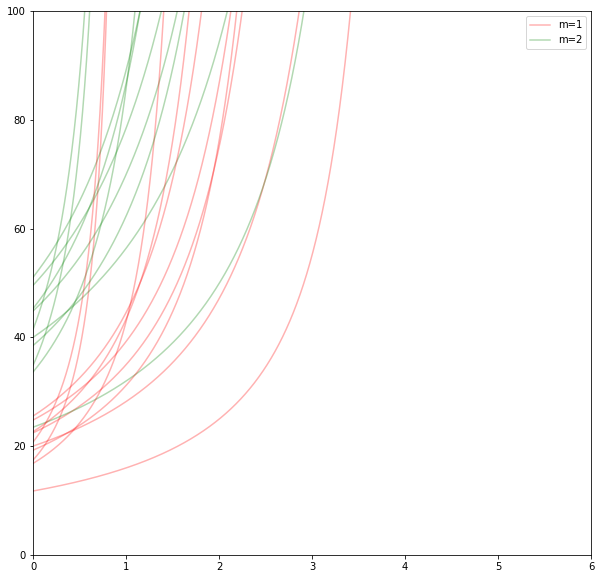

In [12]:
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 15
length = 10
dt = 0.001
m = 1.5
b = 0
speeds = 1/(LV_vals/stim_size)
speed = speeds[3]
plt.figure(figsize=(10, 10))
for i in range(10):
    lv = np.random.rand()*1.1 + 0.1
    stim_size = np.random.rand()*15 + 10
    speed = 1/(lv/stim_size)
    for m, mcolor in zip([1, 2], ['r', 'g']):
        t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size, speed, length, dt, m, b)
        if i == 0:
            plt.plot(t, tstims, c=mcolor, alpha=0.3, label='m=' + str(m))
        else:
            plt.plot(t, tstims, c=mcolor, alpha=0.3)
plt.xlim([0, 6])
plt.ylim([0, 100])
plt.legend()
#plt.plot(t, dists)

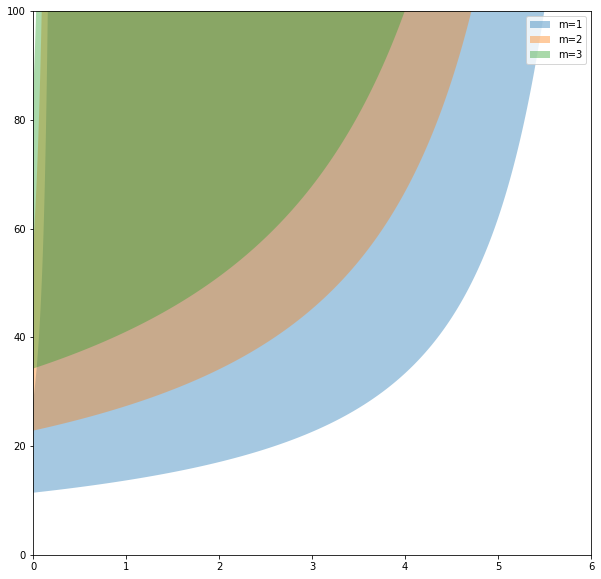

In [13]:
length = 10
dt = 0.001
m = 1.5
b = 0
plt.figure(figsize=(10, 10))

for m, mcolor in zip([1, 2, 3], ['r', 'g', 'b']):
    lv1 = 0.1
    lv2 = 1.2
    stim_size1 = 25
    stim_size2 = 10
    speed1 = 1/(lv1/stim_size1)
    speed2 = 1/(lv2/stim_size2)
    t, stims, tstims1, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size1, speed1, length, dt, m, b)
    t, stims, tstims2, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size2, speed2, length, dt, m, b)
    plt.fill_between(t, tstims1, tstims2, alpha=0.4, label='m=' + str(m), lw=4, linestyle='-')

plt.xlim([0, 6])
plt.ylim([0, 100])
plt.legend()
#plt.plot(t, dists)

In [14]:
tau_m = 0.023
e_l = -0.079
r_m = 10*1e6 # MOhm
v_t = -0.061
init_vm_std = 0.005
vt_std = 0.001

dt = 0.001
total_time = 5

noise_std = 20*1e-3
n_timepoints = int(total_time/dt)

# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 10
speeds = 1/(LV_vals/stim_size)
speed = speeds[2]

m = 5.5
b = 0

t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = transform_stim(stim_size, speed, total_time,
                                                                                        dt, m, b)

stimulus = tstims*1e-11
sigma = noise_std * np.sqrt(dt)
#print(sigma)
noise_vals = np.random.normal(loc=0.0, scale=sigma, size=n_timepoints)
#stimulus = noise_vals + stimulus

#np.random.seed(1)
time, v_m, spks, spk_idc = jit_lif_dynamics(tau_m, e_l, r_m, stimulus, noise_vals, v_t, dt, total_time, init_vm_std,
                                            vt_std)
first_spike = spks[0]
first_spike_idx = spk_idc[0]

Response angle at first spike: 24.0762460803 degree
Distance at first spike: 23.4464285714 mm


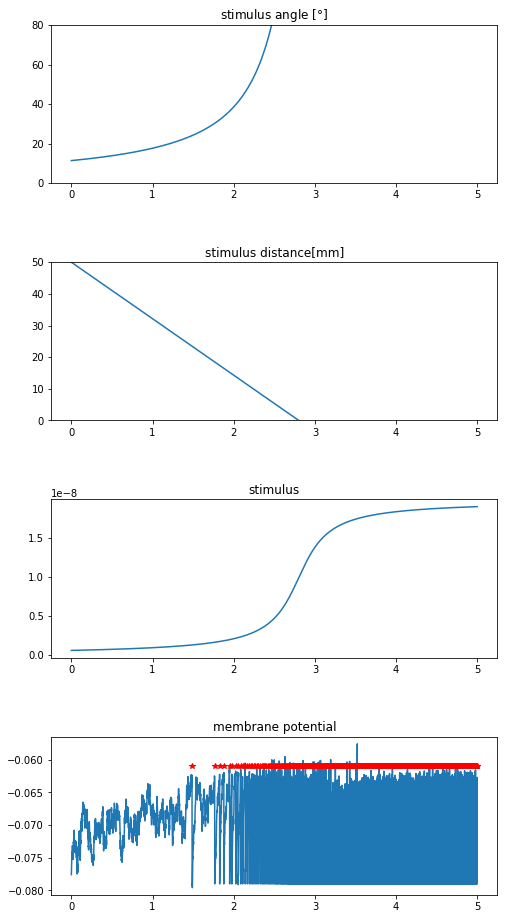

In [15]:
fig, axes = plt.subplots(4, 1, figsize=(8,16))
axes[0].plot(time, stims)
axes[0].set_title(r'stimulus angle [$ \degree $]')
axes[0].set_ylim([0, 80])
axes[1].plot(time, dists)
axes[1].set_title('stimulus distance[mm]')
axes[1].set_ylim([0, 50])
axes[2].plot(time, stimulus)
axes[2].set_title('stimulus')
axes[3].plot(time, v_m)
axes[3].set_title('membrane potential')
if not len(spks) == 0:
    axes[3].plot(spks, np.ones(len(spks))*v_t, 'r*')
plt.subplots_adjust(hspace=0.5)
print('Response angle at first spike: ' + str(stims[first_spike_idx]) + ' degree')
print('Distance at first spike: ' + str(dists[first_spike_idx]) + ' mm')

## One parameter set example

Mean visual angle: 39.5127362391
Mean distance: 24.3171173274
Mean reaction time: 1.078361
resp in ttc: -0.765


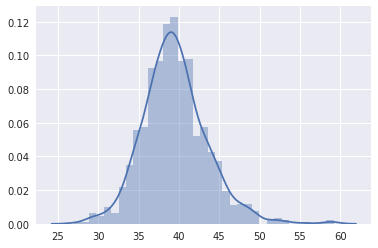

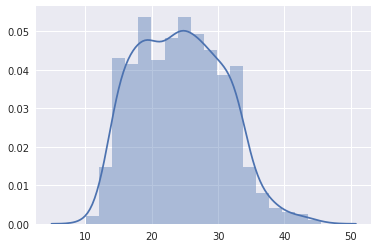

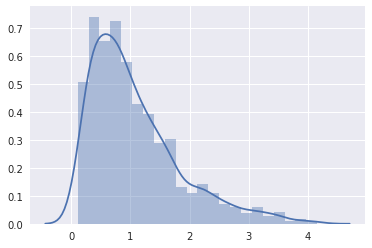

In [16]:
# generate looming stimulus
LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
stim_size = 10
speeds = 1/(LV_vals/stim_size)
speed = speeds[1]

params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6,
          'v_t': -0.061,
          'init_vm_std': 0.001,
          'vt_std': 0.002,
          'dt': 0.001,
          'total_time': 5,
          'noise_std': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 3.5,
          'b': 0}

nruns = 1000
rstims = np.zeros(nruns)
rdists = np.zeros(nruns)
reaction_times = np.zeros(nruns)
for i in np.arange(nruns):
    rstims[i], rdists[i], reaction_times[i], lv, stim_size, speed, resp_in_t_to_coll = calc_response(params)

sns.set()
sns.distplot(rstims)
print('Mean visual angle: ' + str(np.mean(rstims)))
plt.figure()
sns.distplot(rdists)
print('Mean distance: ' + str(np.mean(rdists)))
plt.figure()
sns.distplot(reaction_times)
print('Mean reaction time: ' + str(np.mean(reaction_times)))
print('resp in ttc: ' + str(resp_in_t_to_coll))

## Analyzing the influence of m, b and noise

In [17]:
params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6, # MOhm
          'v_t': -0.061,
          'init_vm_std': 0.001,
          'vt_std': 0.001,
          'dt': 0.001,
          'total_time': 5,
          'noise_std': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 4.5,
          'b': 5}

mvals = np.array([1, 2, 4, 6])
nmvals = len(mvals)
noisevals = np.array([1, 10, 20])*1e-3
nruns = 250
data_cols = ['resp_angle', 'resp_dist', 'resp_time', 'lv', 'stim_size', 'speed', 'm', 'noise', 'resp_time_coll']
data_dict = dict([(col_name, []) for col_name in data_cols])

for noise_idx, noise in enumerate(noisevals):
    params['noise_std'] = noise
    for m_idx, mval in enumerate(mvals):
        params['m'] = mval
        for i in np.arange(nruns):
            resp_angle, resp_dist, resp_time, lv, stim_size, speed, resp_time_coll = calc_response(params)
            resp_angle = np.round(resp_angle, decimals=1)
            resp_dist = np.round(resp_dist, decimals=1)
            resp_time = np.round(resp_time, decimals=3)
            lv = np.round(lv, decimals=2)
            stim_size = np.round(stim_size, decimals=1)
            speed = np.round(speed, decimals=1)
            resp_time_coll = np.round(resp_time_coll, decimals=3)
            result_values = [resp_angle, resp_dist, resp_time, lv, stim_size, speed, mval, noise, resp_time_coll]
            for col, value in zip(data_cols, result_values):
                data_dict[col].append(value)

In [18]:
df = pd.DataFrame(data_dict)

In [19]:
df.describe()

lv            m        noise   resp_angle    resp_dist  \
count  3000.000000  3000.000000  3000.000000  3000.000000  3000.000000   
mean      0.652200     3.250000     0.010333    75.840667    19.212100   
std       0.315256     1.920607     0.007762    54.708151    15.306774   
min       0.100000     1.000000     0.001000    11.700000    -4.700000   
25%       0.380000     1.750000     0.001000    29.200000     5.500000   
50%       0.650000     3.000000     0.010000    47.850000    16.200000   
75%       0.930000     4.500000     0.020000   111.075000    31.700000   
max       1.200000     6.000000     0.020000   228.000000    50.000000   

         resp_time  resp_time_coll        speed    stim_size  
count  3000.000000     3000.000000  3000.000000  3000.000000  
mean      1.246913       -0.750632    38.734267    17.380300  
std       1.003679        0.740322    32.774921     4.306141  
min       0.000000       -4.999000     8.700000    10.000000  
25%       0.438250       -1.209500    18.700000    13.700000  
50%       0.986500       -0.503000    26.500000    17.300000  
75%       1.823250       -0.139000    45.725000    21.100000  
max       4.963000        0.000000   243.000000    25.000000

In [20]:
def lv_map(lv):
    if lv > 0.1 and lv < 0.3:
        return 0.2
    elif lv > 0.3 and lv < 0.5:
        return 0.4
    elif lv > 0.5 and lv < 0.7:
        return 0.6
    elif lv > 0.7 and lv < 0.9:
        return 0.8
    else:
        return 1

df['lv_grouped'] = df['lv'].map(lv_map)
grouped = df.groupby(['m', 'noise', 'lv_grouped'], as_index=False)
expdf = grouped.agg({'resp_dist': np.mean,
                     'resp_time': np.mean,
                     'resp_angle': np.mean,
                     'resp_time_coll': np.mean})

In [21]:
a = df[df['resp_time']!= 0.0]
b = a['resp_time']
b.sort_values()

2794    0.035
2761    0.037
2850    0.039
2951    0.039
2844    0.040
2840    0.040
2904    0.041
2758    0.042
2969    0.042
2864    0.042
1813    0.042
1900    0.043
1767    0.045
2980    0.046
2935    0.048
2759    0.048
2925    0.049
2926    0.049
2913    0.050
1771    0.051
2977    0.052
2912    0.052
2949    0.052
1918    0.052
994     0.053
2768    0.053
2858    0.055
790     0.056
1840    0.056
1775    0.056
        ...  
129     4.271
1029    4.281
2230    4.293
2016    4.326
2377    4.330
2117    4.332
1285    4.341
409     4.343
172     4.376
2214    4.421
1163    4.429
1499    4.472
1348    4.485
473     4.492
23      4.502
1087    4.513
1341    4.513
2448    4.546
2123    4.598
1376    4.659
438     4.740
96      4.776
382     4.789
155     4.807
2492    4.822
1204    4.832
1160    4.854
1343    4.866
2197    4.941
39      4.963
Name: resp_time, Length: 2998, dtype: float64

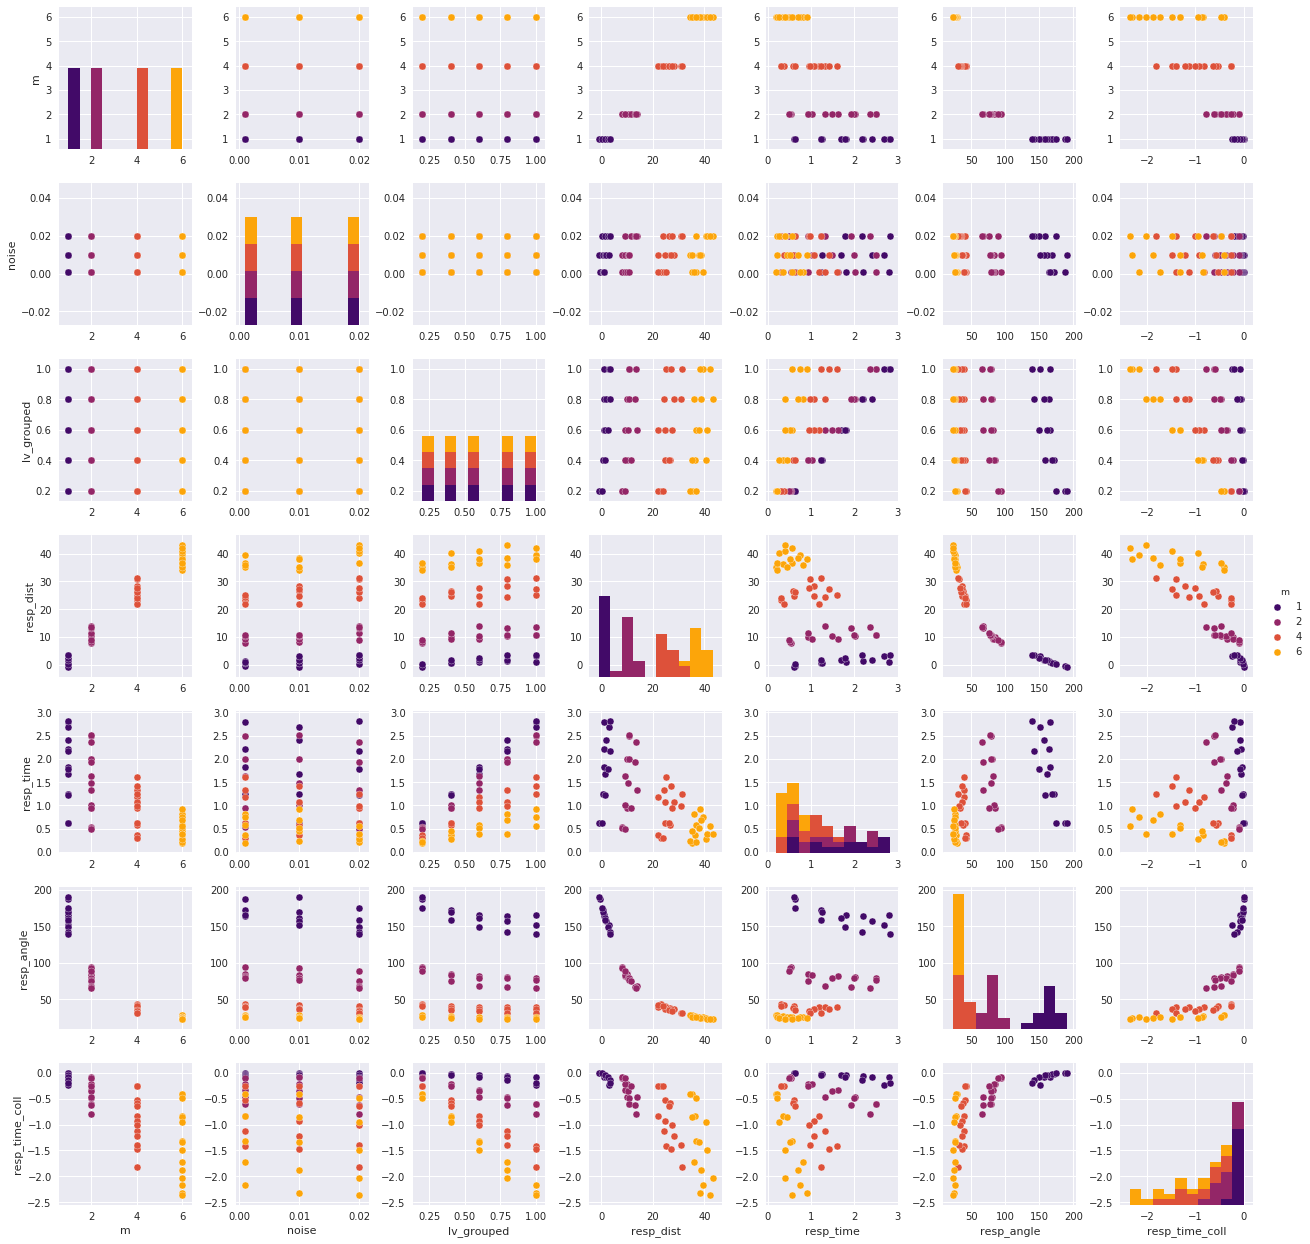

In [22]:
import matplotlib as mpl
cmap = mpl.cm
sns.pairplot(expdf, hue='m', palette='inferno')

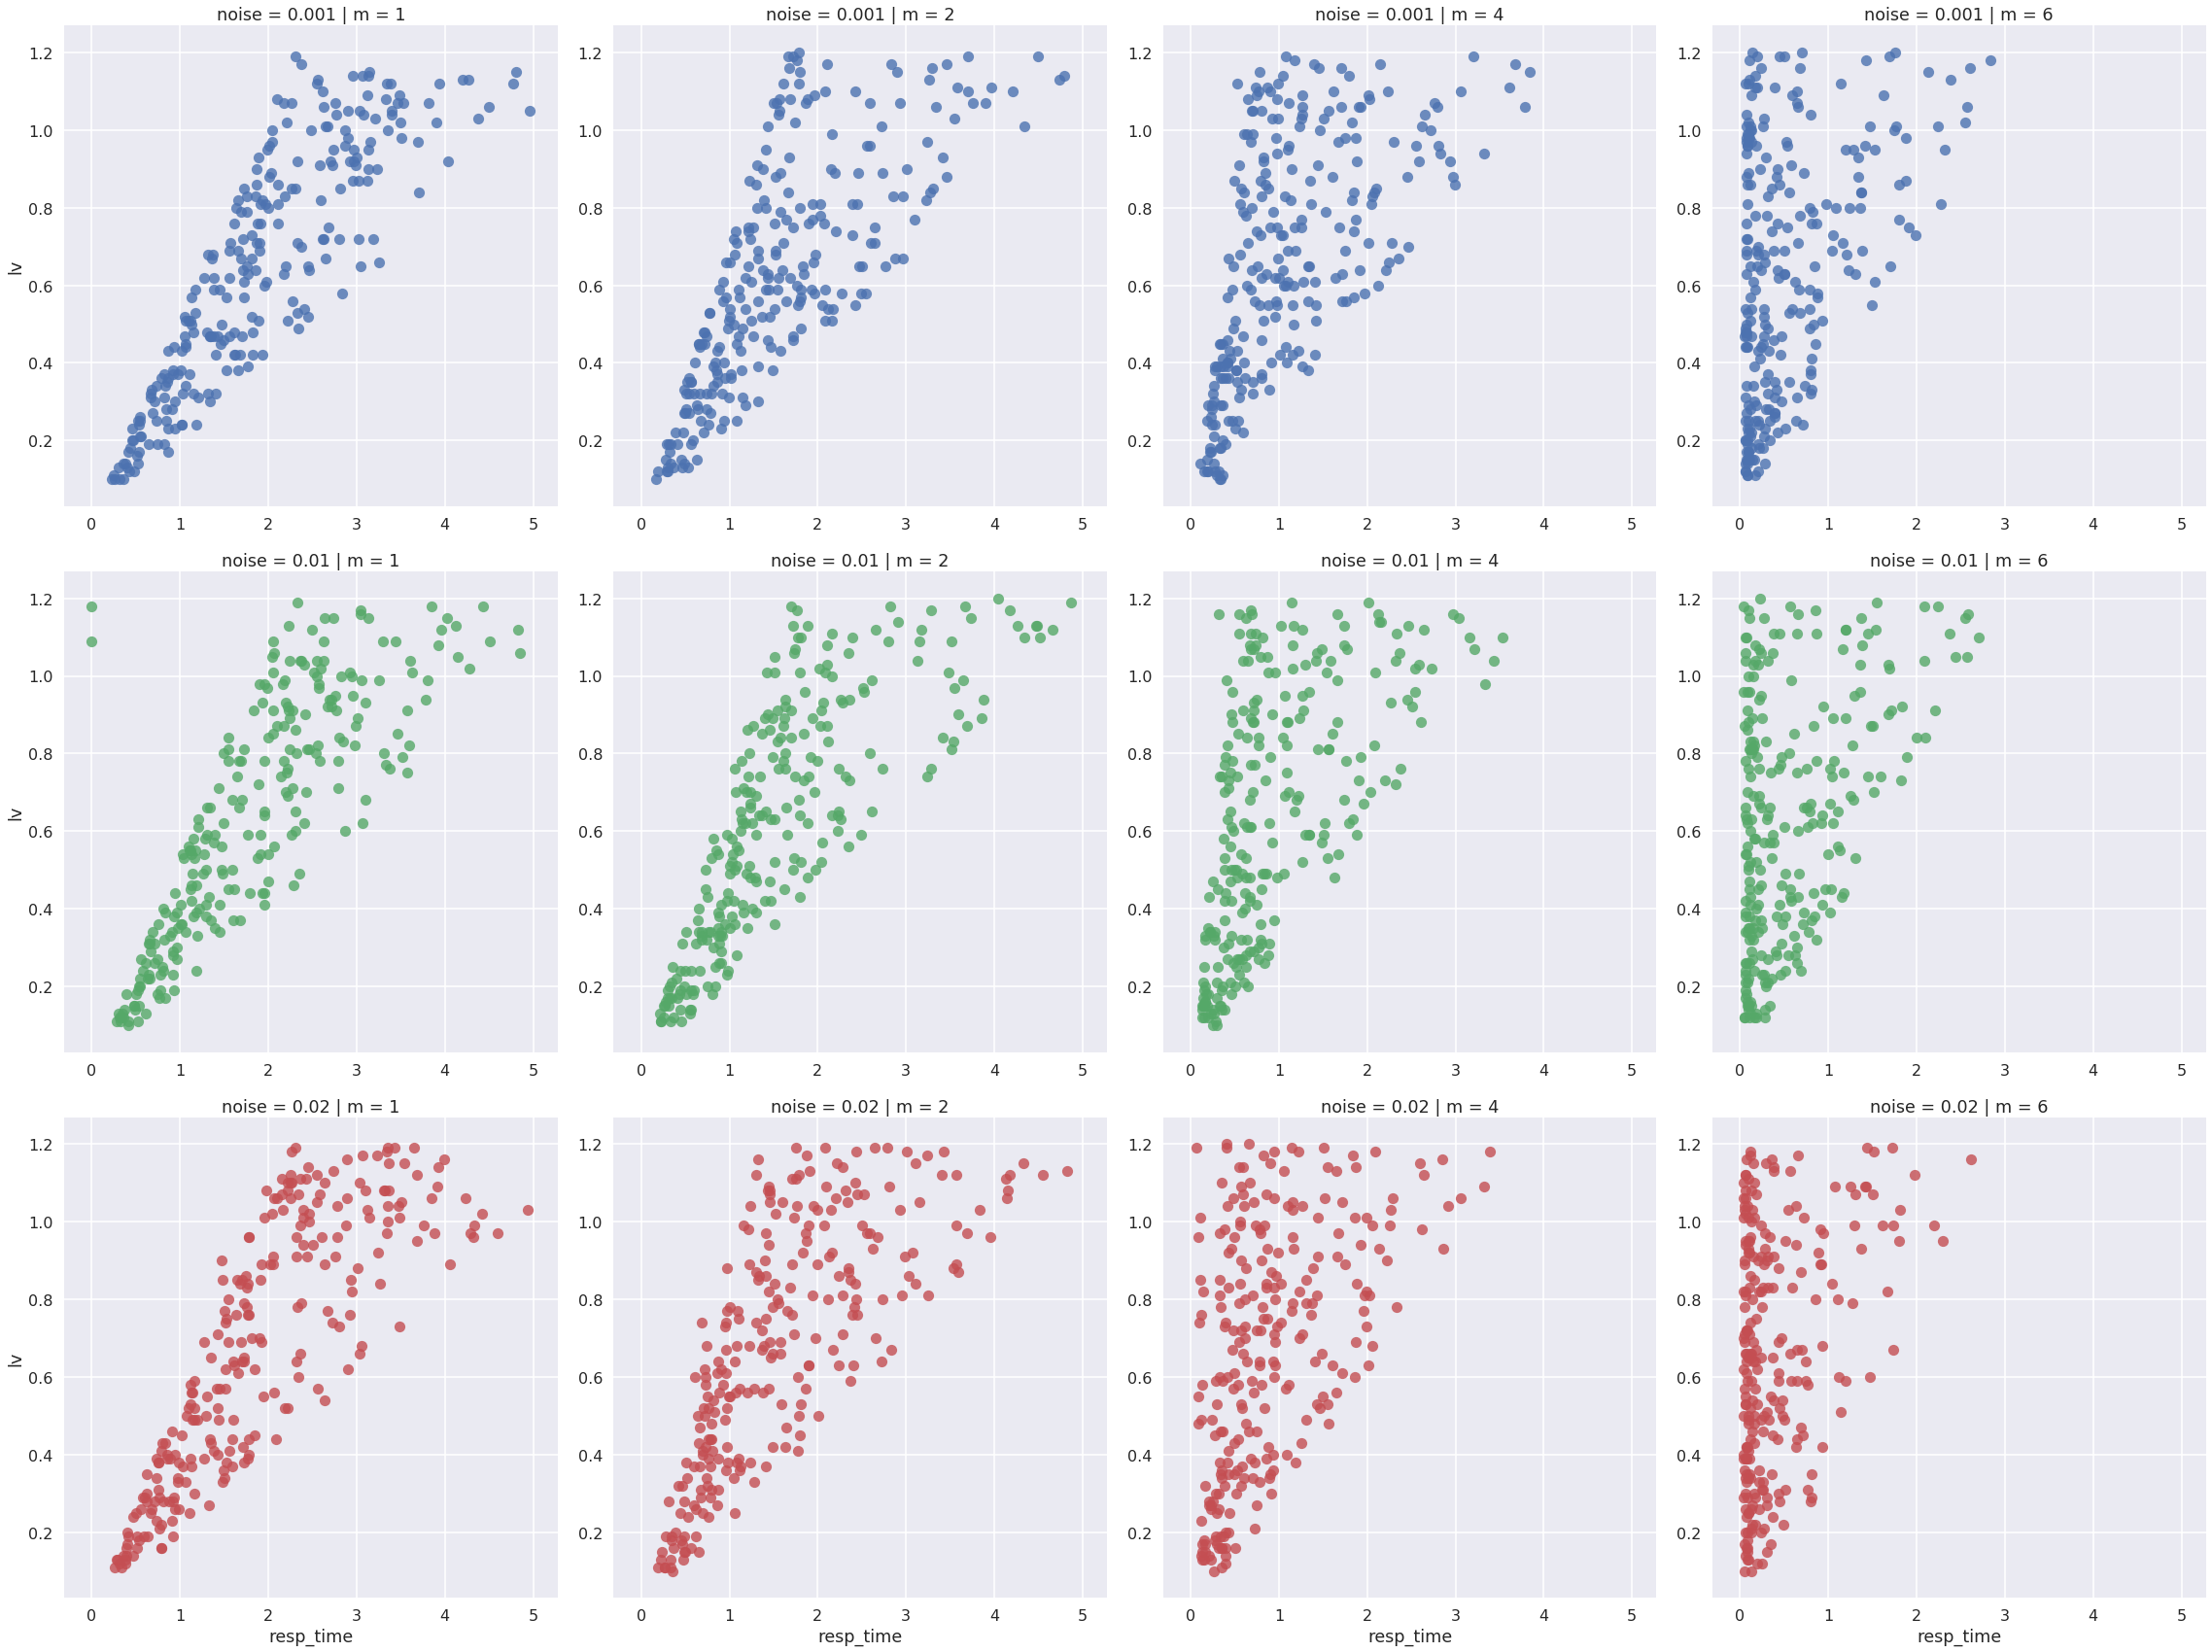

In [24]:
sns.set('poster')
g = sns.lmplot(x='resp_time', y='lv', col='m', row='noise', hue='noise', data=df, fit_reg=False, size=8)
g.savefig('rand_init_resp_time_vs_speed_b=5.pdf')

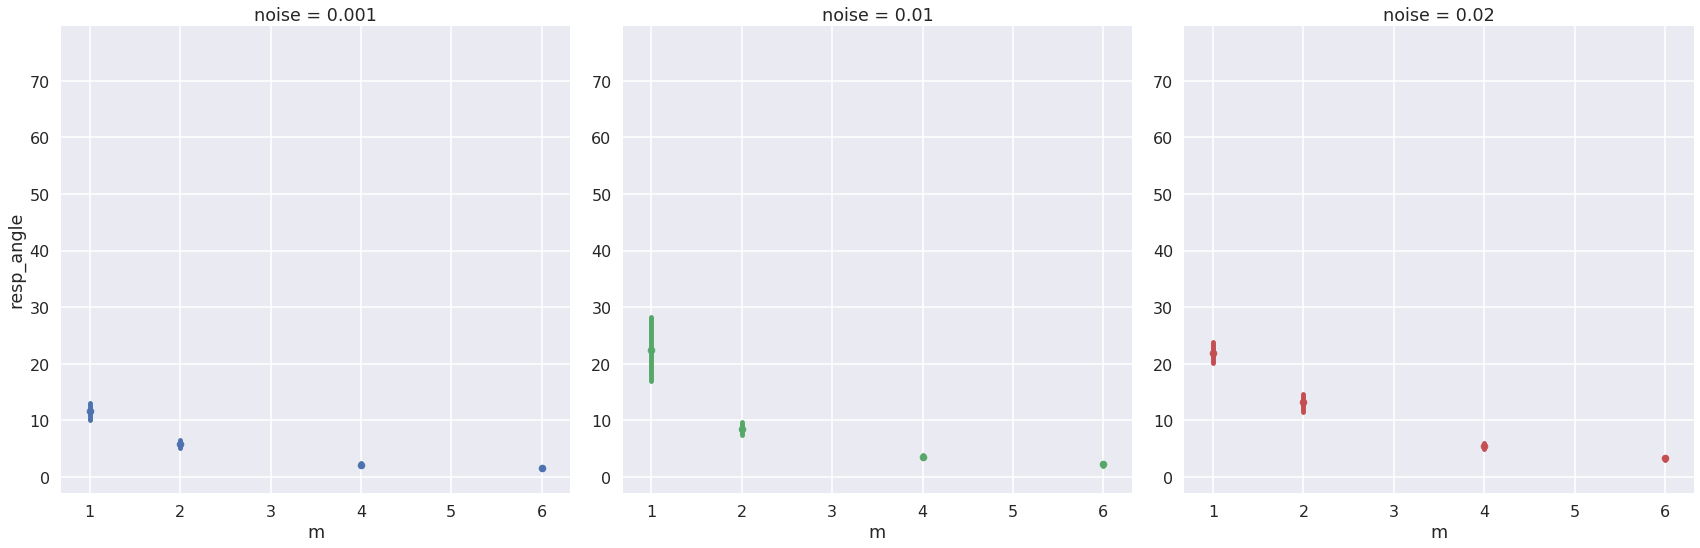

In [25]:
sns.set('poster')
g = sns.lmplot(x='m', y='resp_angle', hue='noise', col='noise', data=df, fit_reg=False, size=8, x_estimator=np.std, x_ci='ci')
g.savefig('rand_init_resp_angle_vs_m_b=5.pdf')

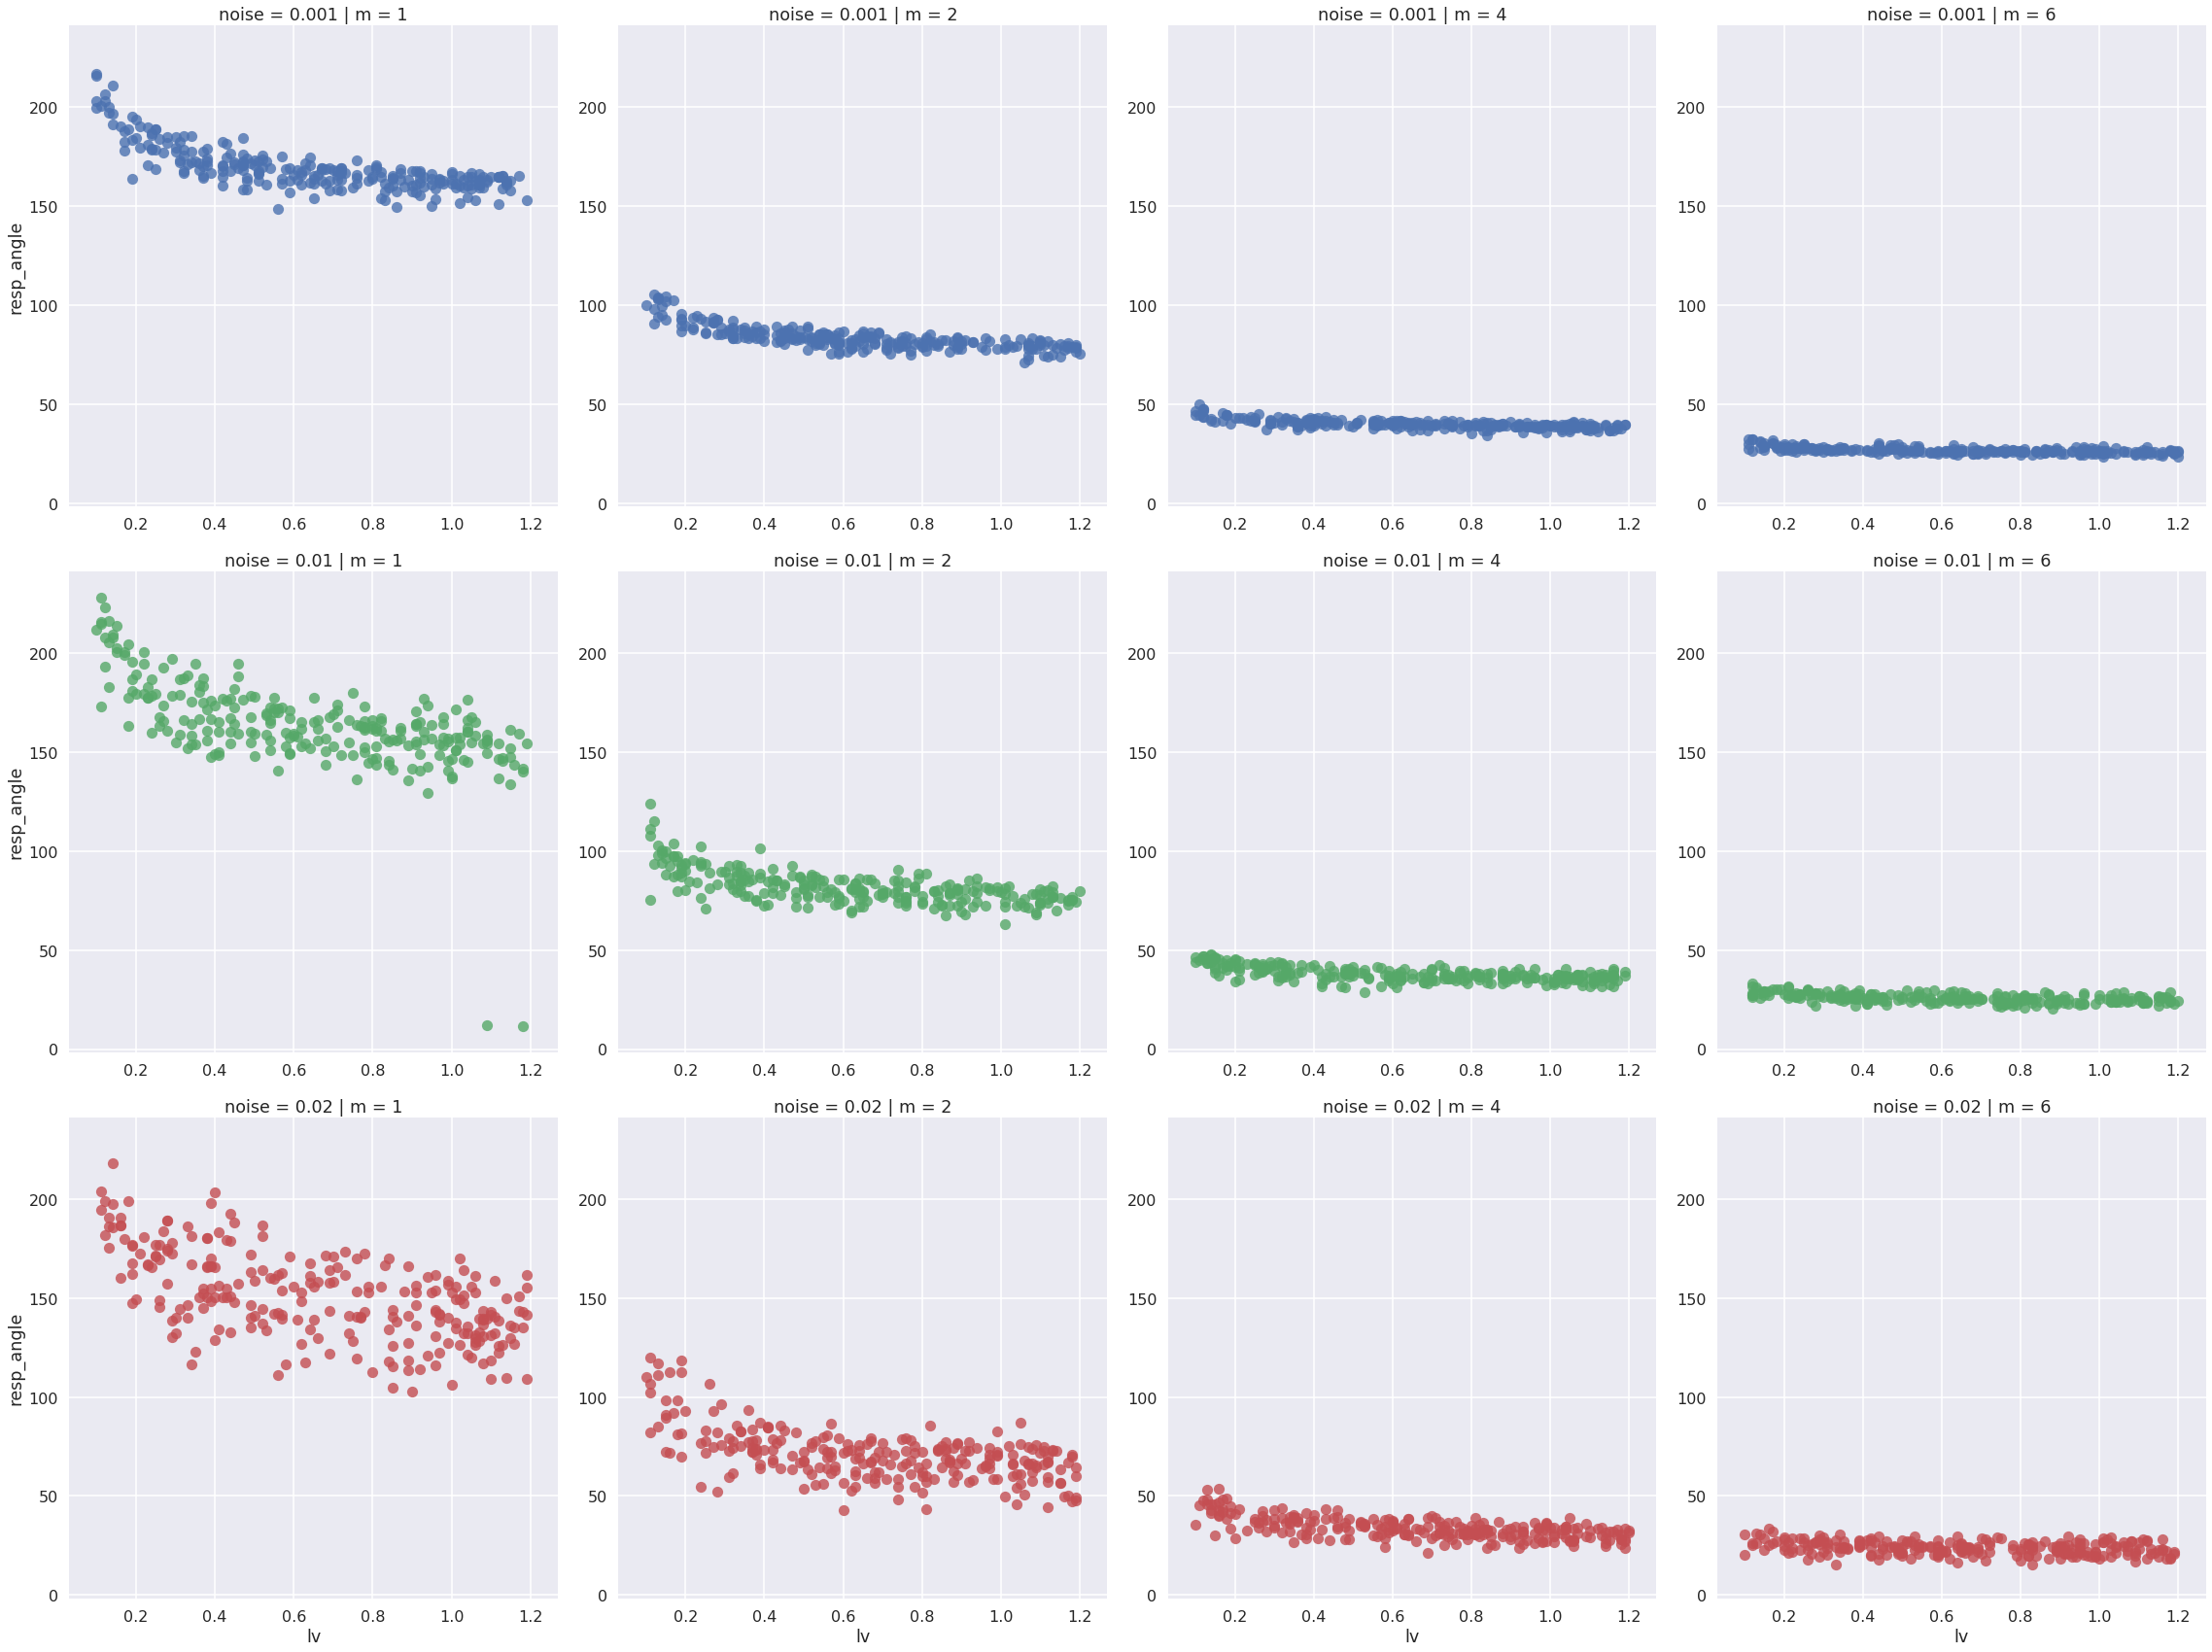

In [26]:
#sns.set('poster')
g = sns.lmplot(x='lv', y='resp_angle', hue='noise', row='noise', col='m', data=df, fit_reg=False, size=8)
g.savefig('rand_init_resp_angle_vs_lv_b=5.pdf')

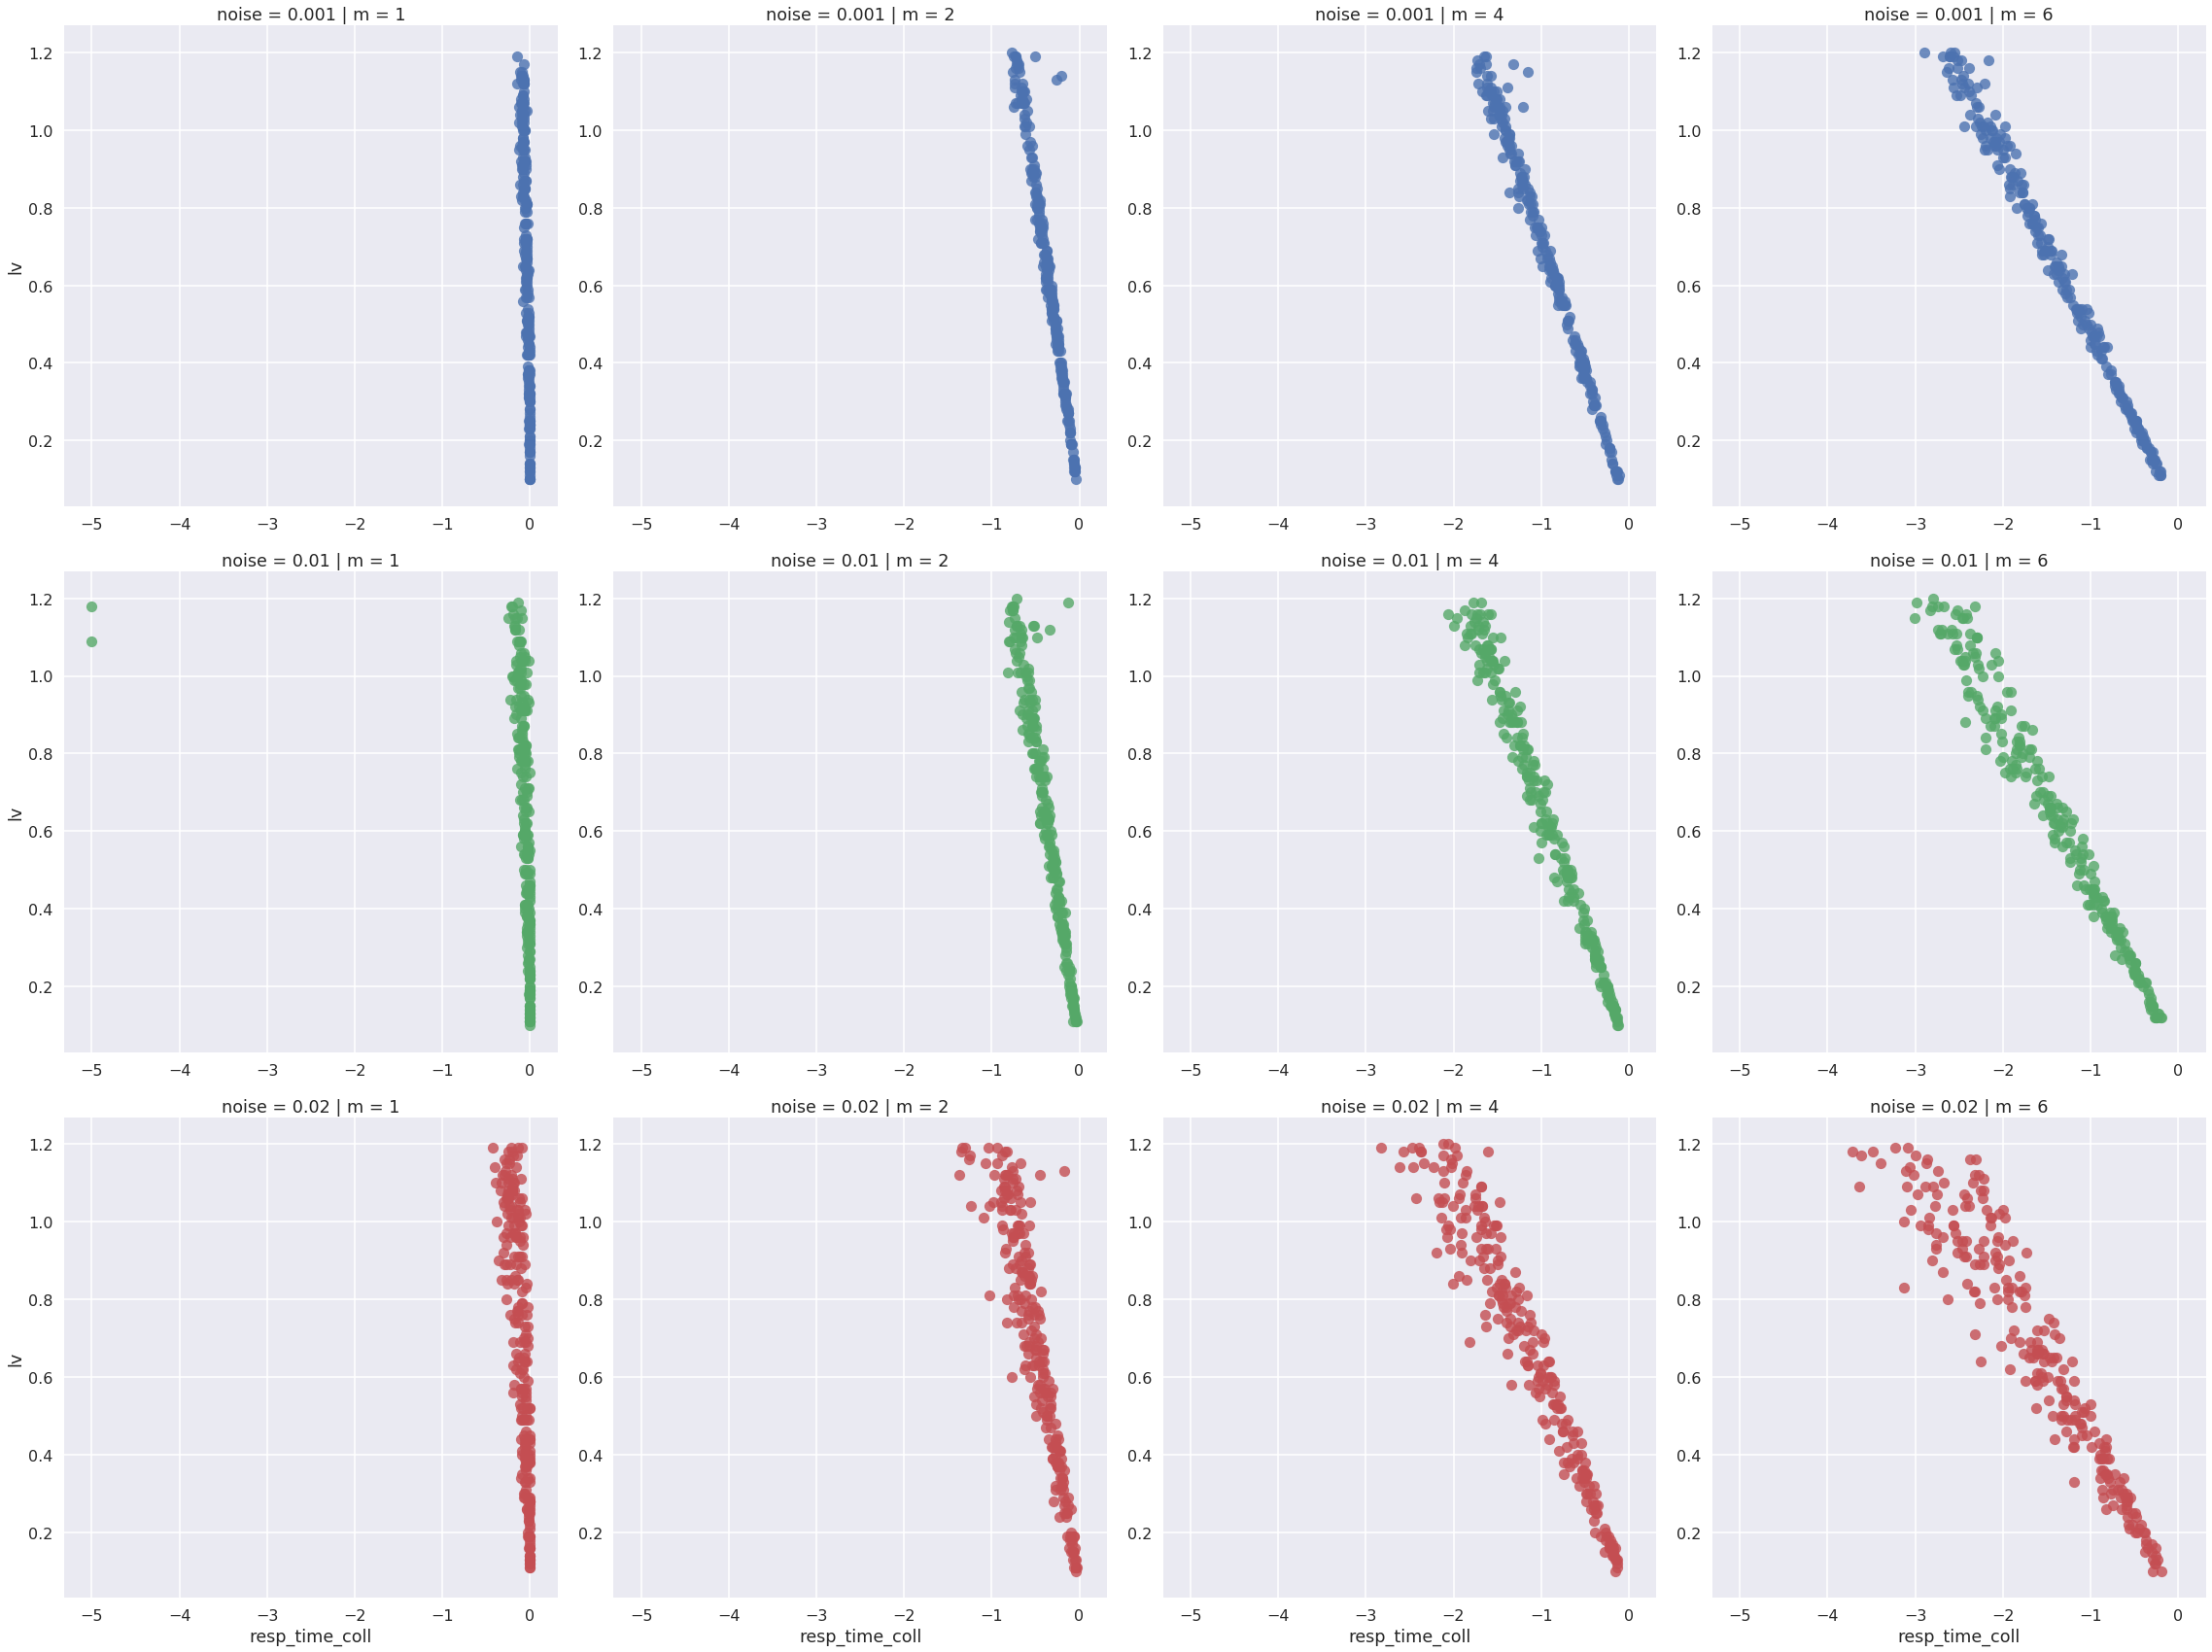

In [27]:
g = sns.lmplot(x='resp_time_coll', y='lv', hue='noise', row='noise', col='m', data=df, fit_reg=False, size=8)
g.savefig('rand_init_lv_vs_resp_time_coll_b=5.pdf')

In [28]:
params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6, # MOhm
          'v_t': -0.061,
          'init_vm_std': 0.000,
          'vt_std': 0.001,
          'dt': 0.001,
          'total_time': 5,
          'noise_std': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'm': 4.5,
          'b': 0}

mvals = np.array([1, 2, 3])
nmvals = len(mvals)
bvals = np.array([5, 10, 20])
vt_noisevals = np.array([2, 3, 4])*1e-3
nruns = 1000
data_cols = ['resp_angle', 'resp_dist', 'resp_time', 'lv', 'stim_size', 'speed', 'm', 'b', 'resp_time_coll',
             'vt_std']
data_dict = dict([(col_name, []) for col_name in data_cols])

for vtnoise_idx, vtnoise in enumerate(vt_noisevals):
    params['vt_std'] = vtnoise
    for b_idx, b in enumerate(bvals):
        params['b'] = b
        for m_idx, mval in enumerate(mvals):
            params['m'] = mval
            for i in np.arange(nruns):
                resp_angle, resp_dist, resp_time, lv, stim_size, speed, resp_time_coll = calc_response(params)
                resp_angle = np.round(resp_angle, decimals=1)
                resp_dist = np.round(resp_dist, decimals=1)
                resp_time = np.round(resp_time, decimals=3)
                lv = np.round(lv, decimals=2)
                stim_size = np.round(stim_size, decimals=1)
                speed = np.round(speed, decimals=1)
                resp_time_coll = np.round(resp_time_coll, decimals=3)
                result_values = [resp_angle, resp_dist, resp_time, lv, stim_size, speed, mval, b, resp_time_coll,
                                 vtnoise]
                for col, value in zip(data_cols, result_values):
                    data_dict[col].append(value)

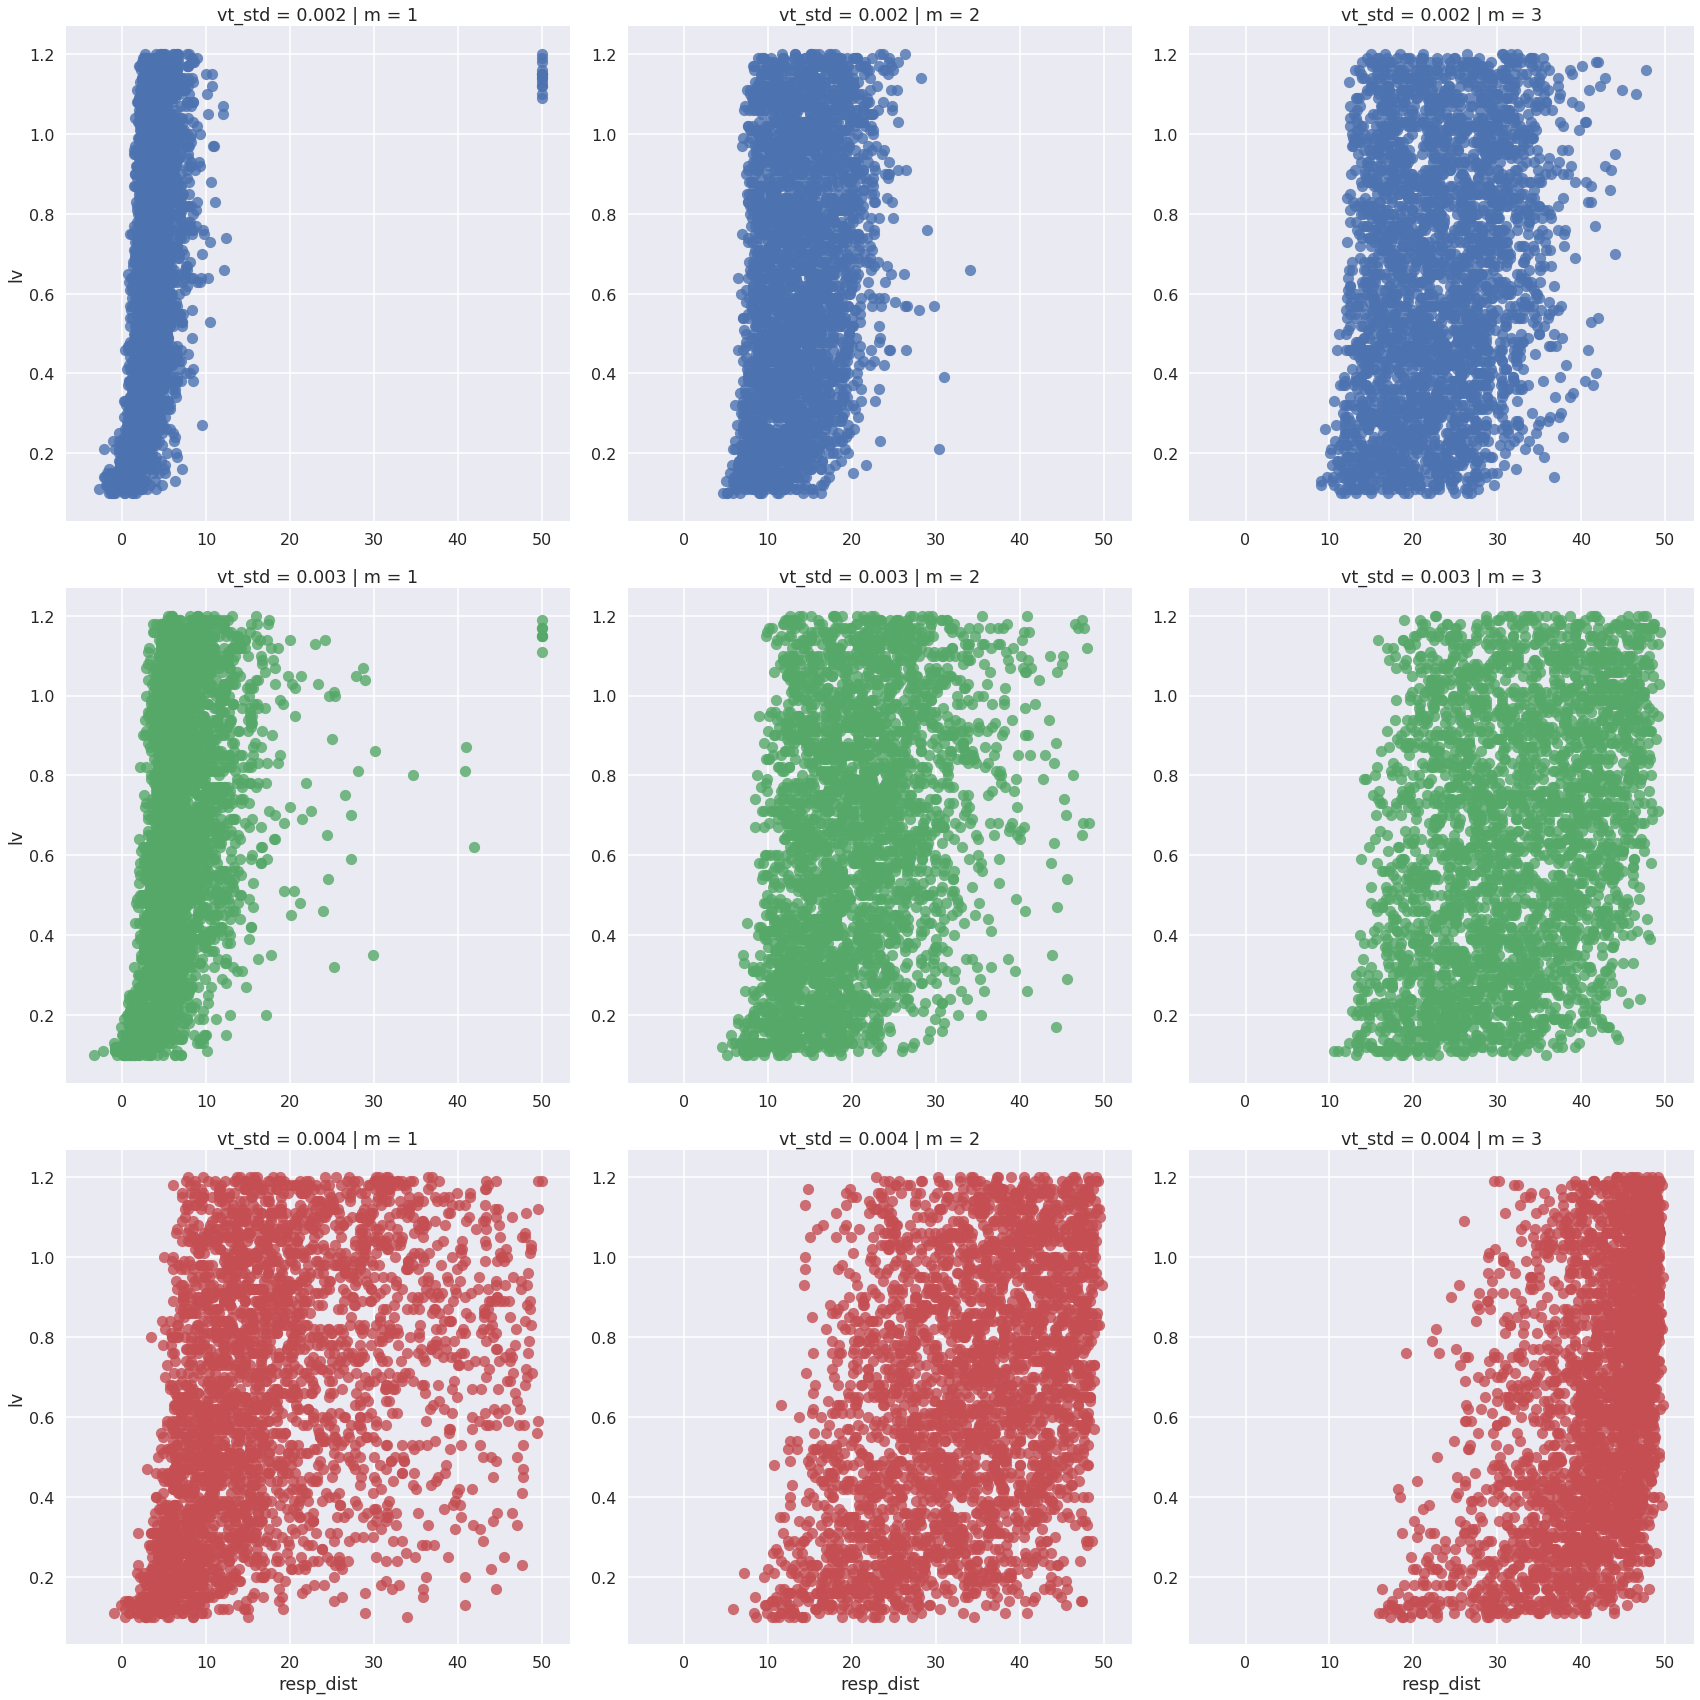

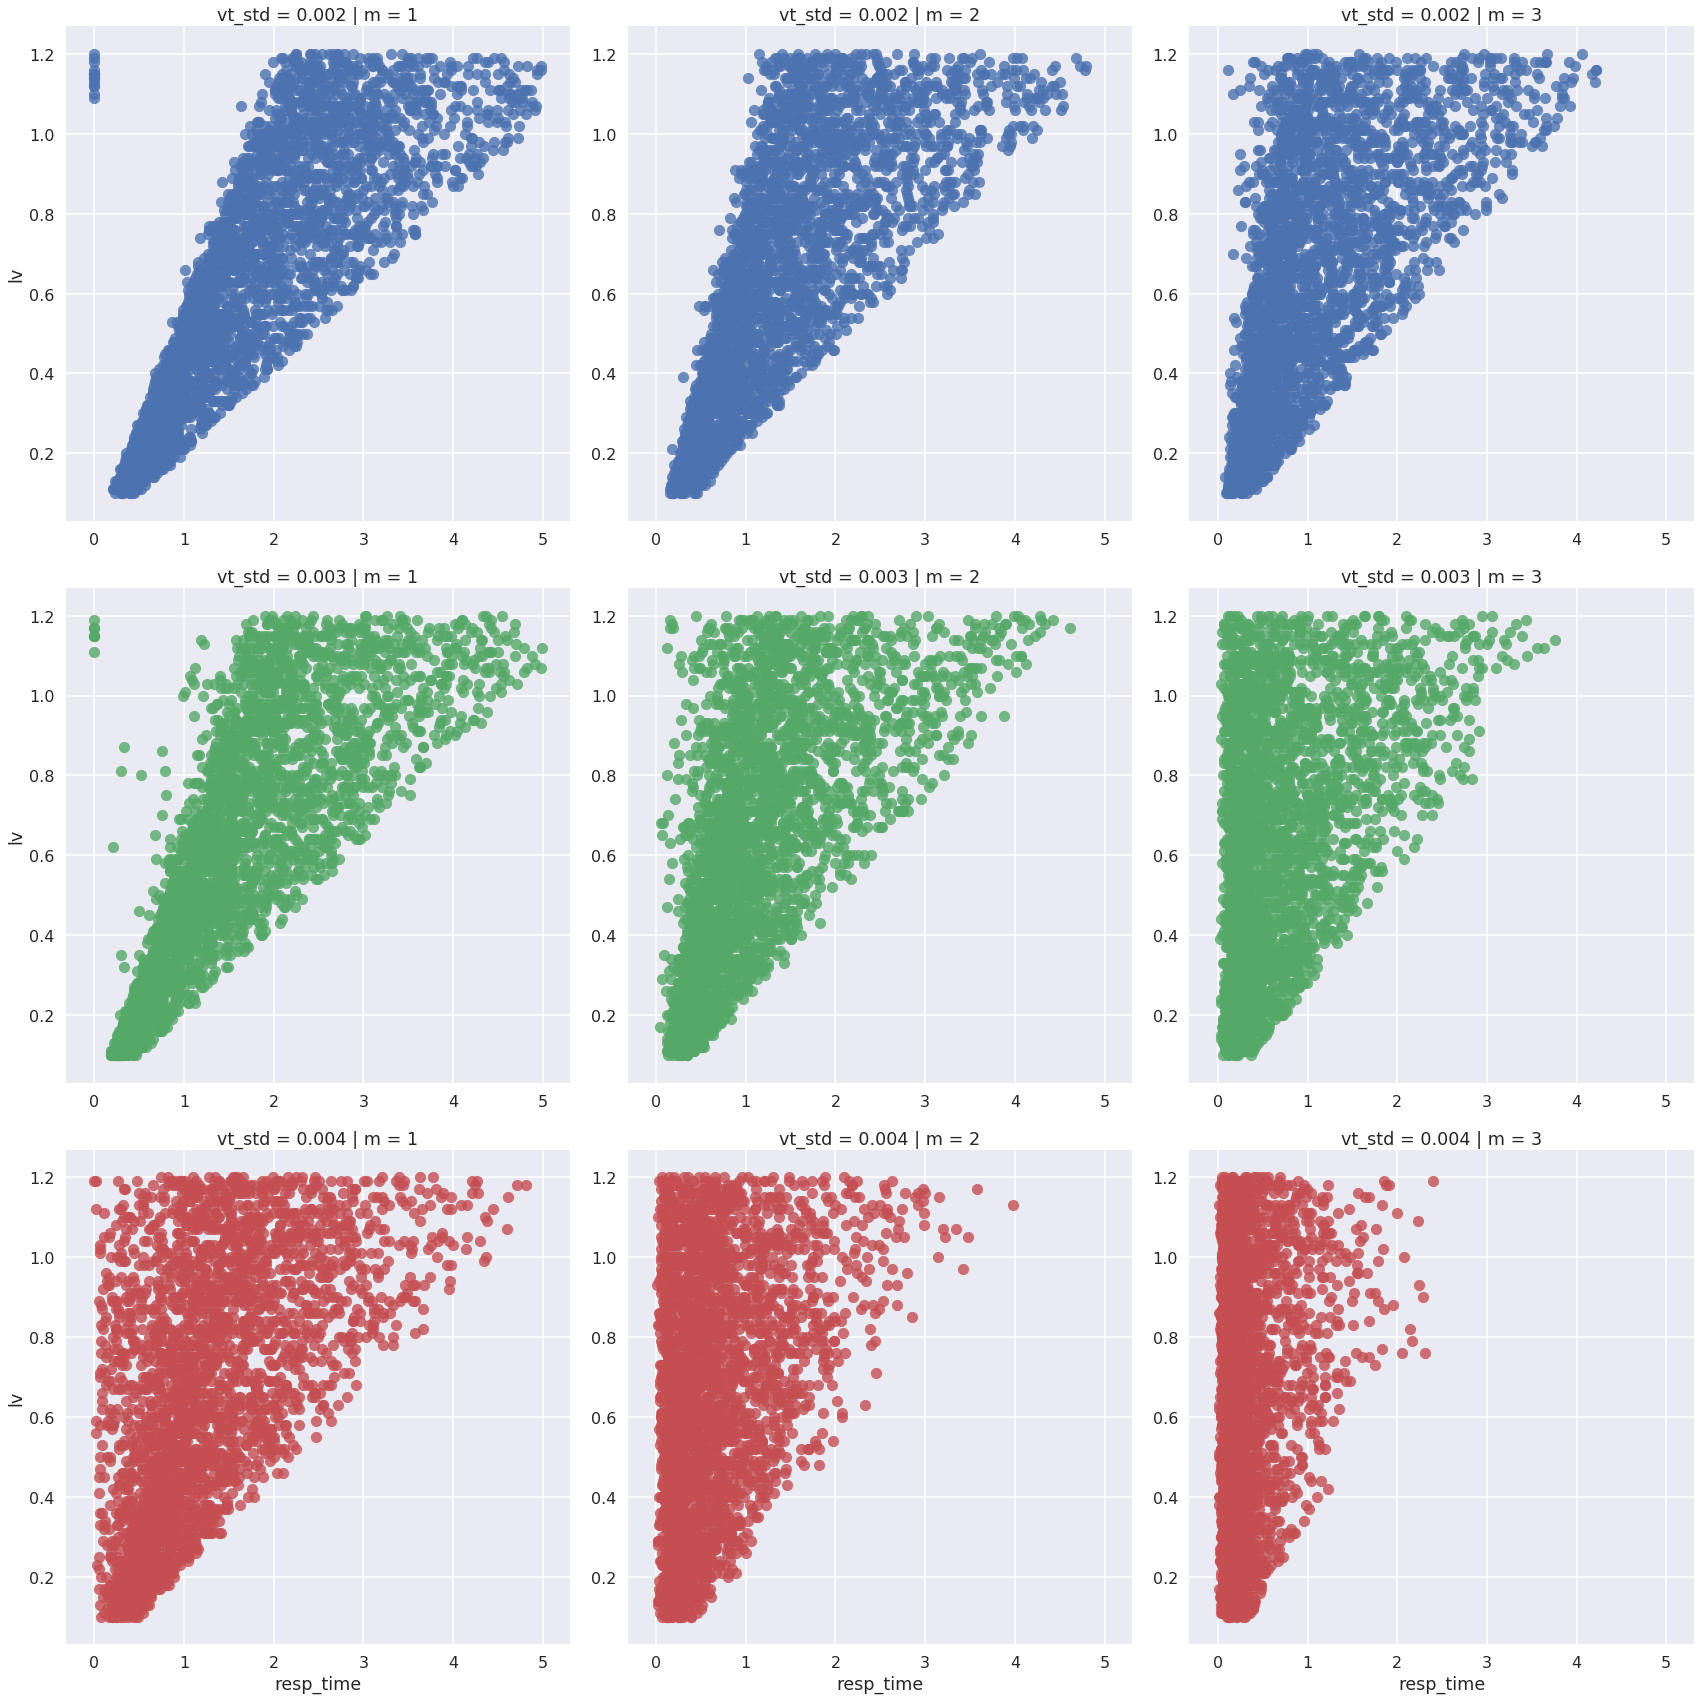

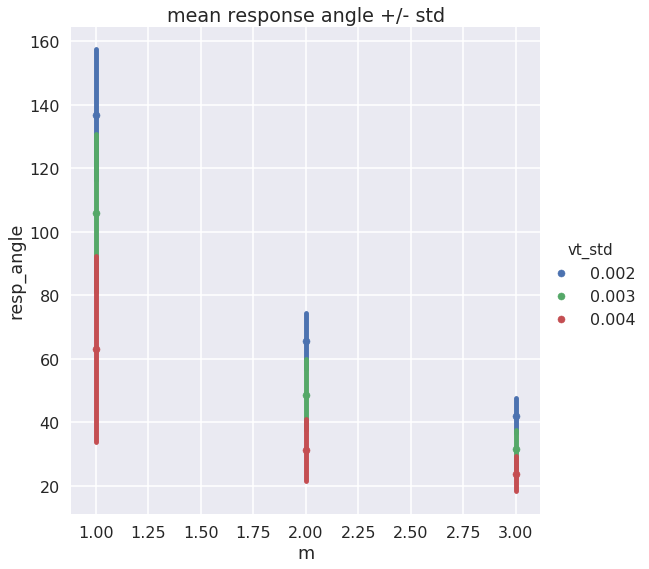

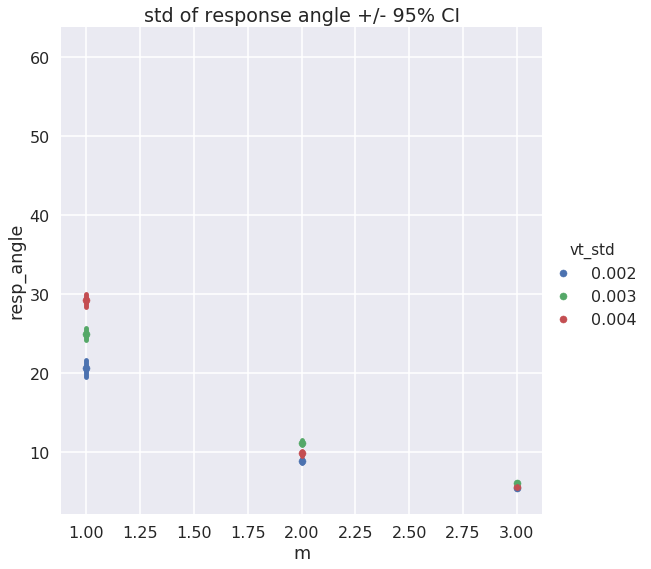

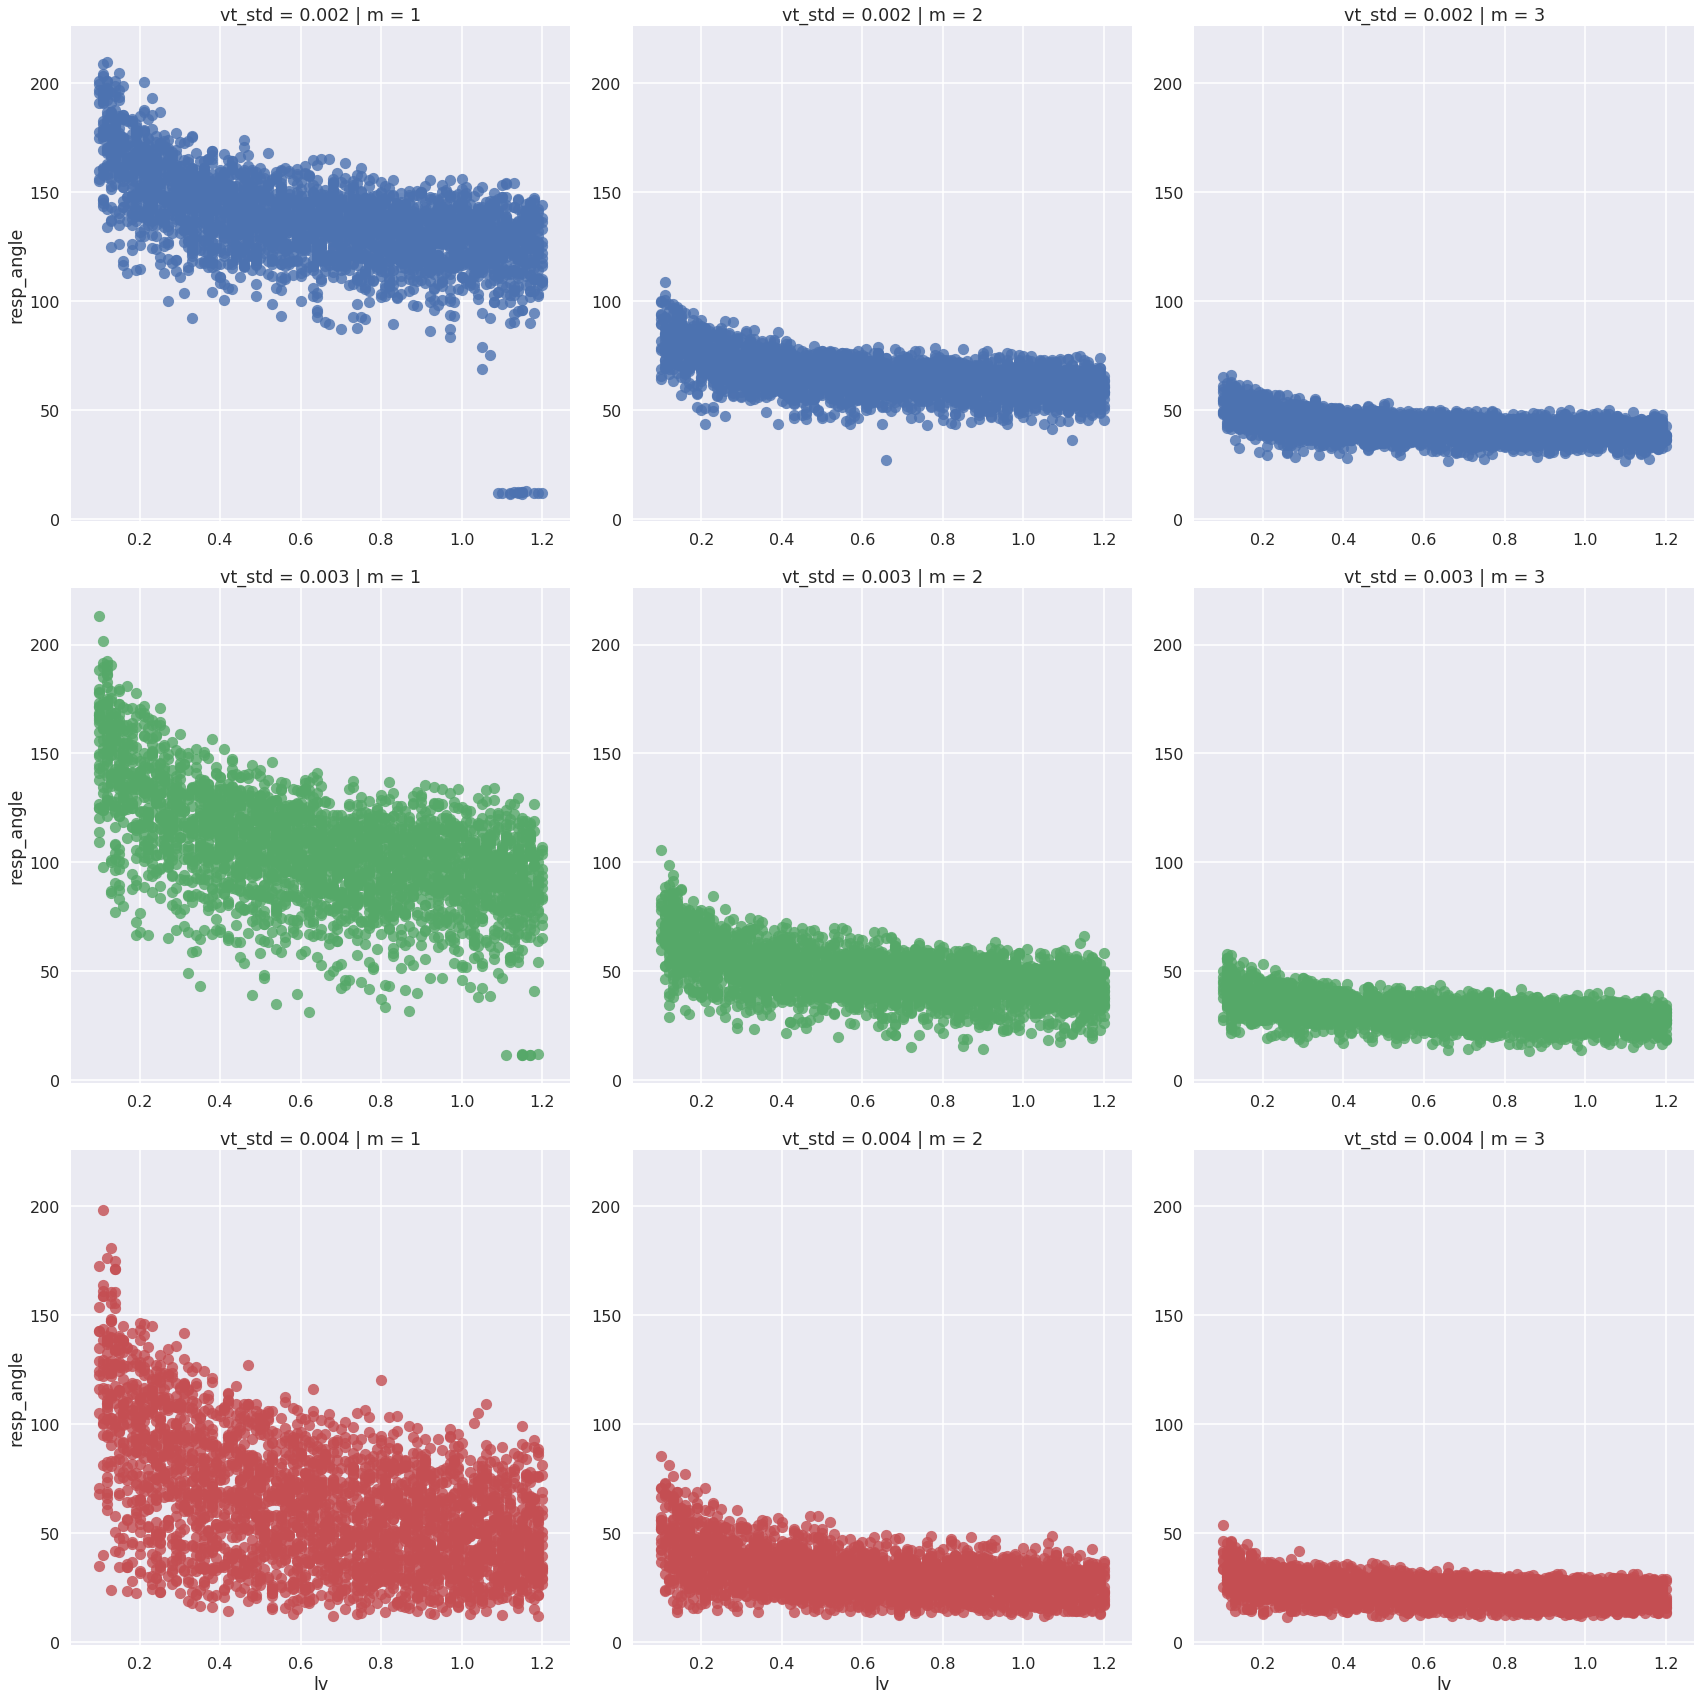

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


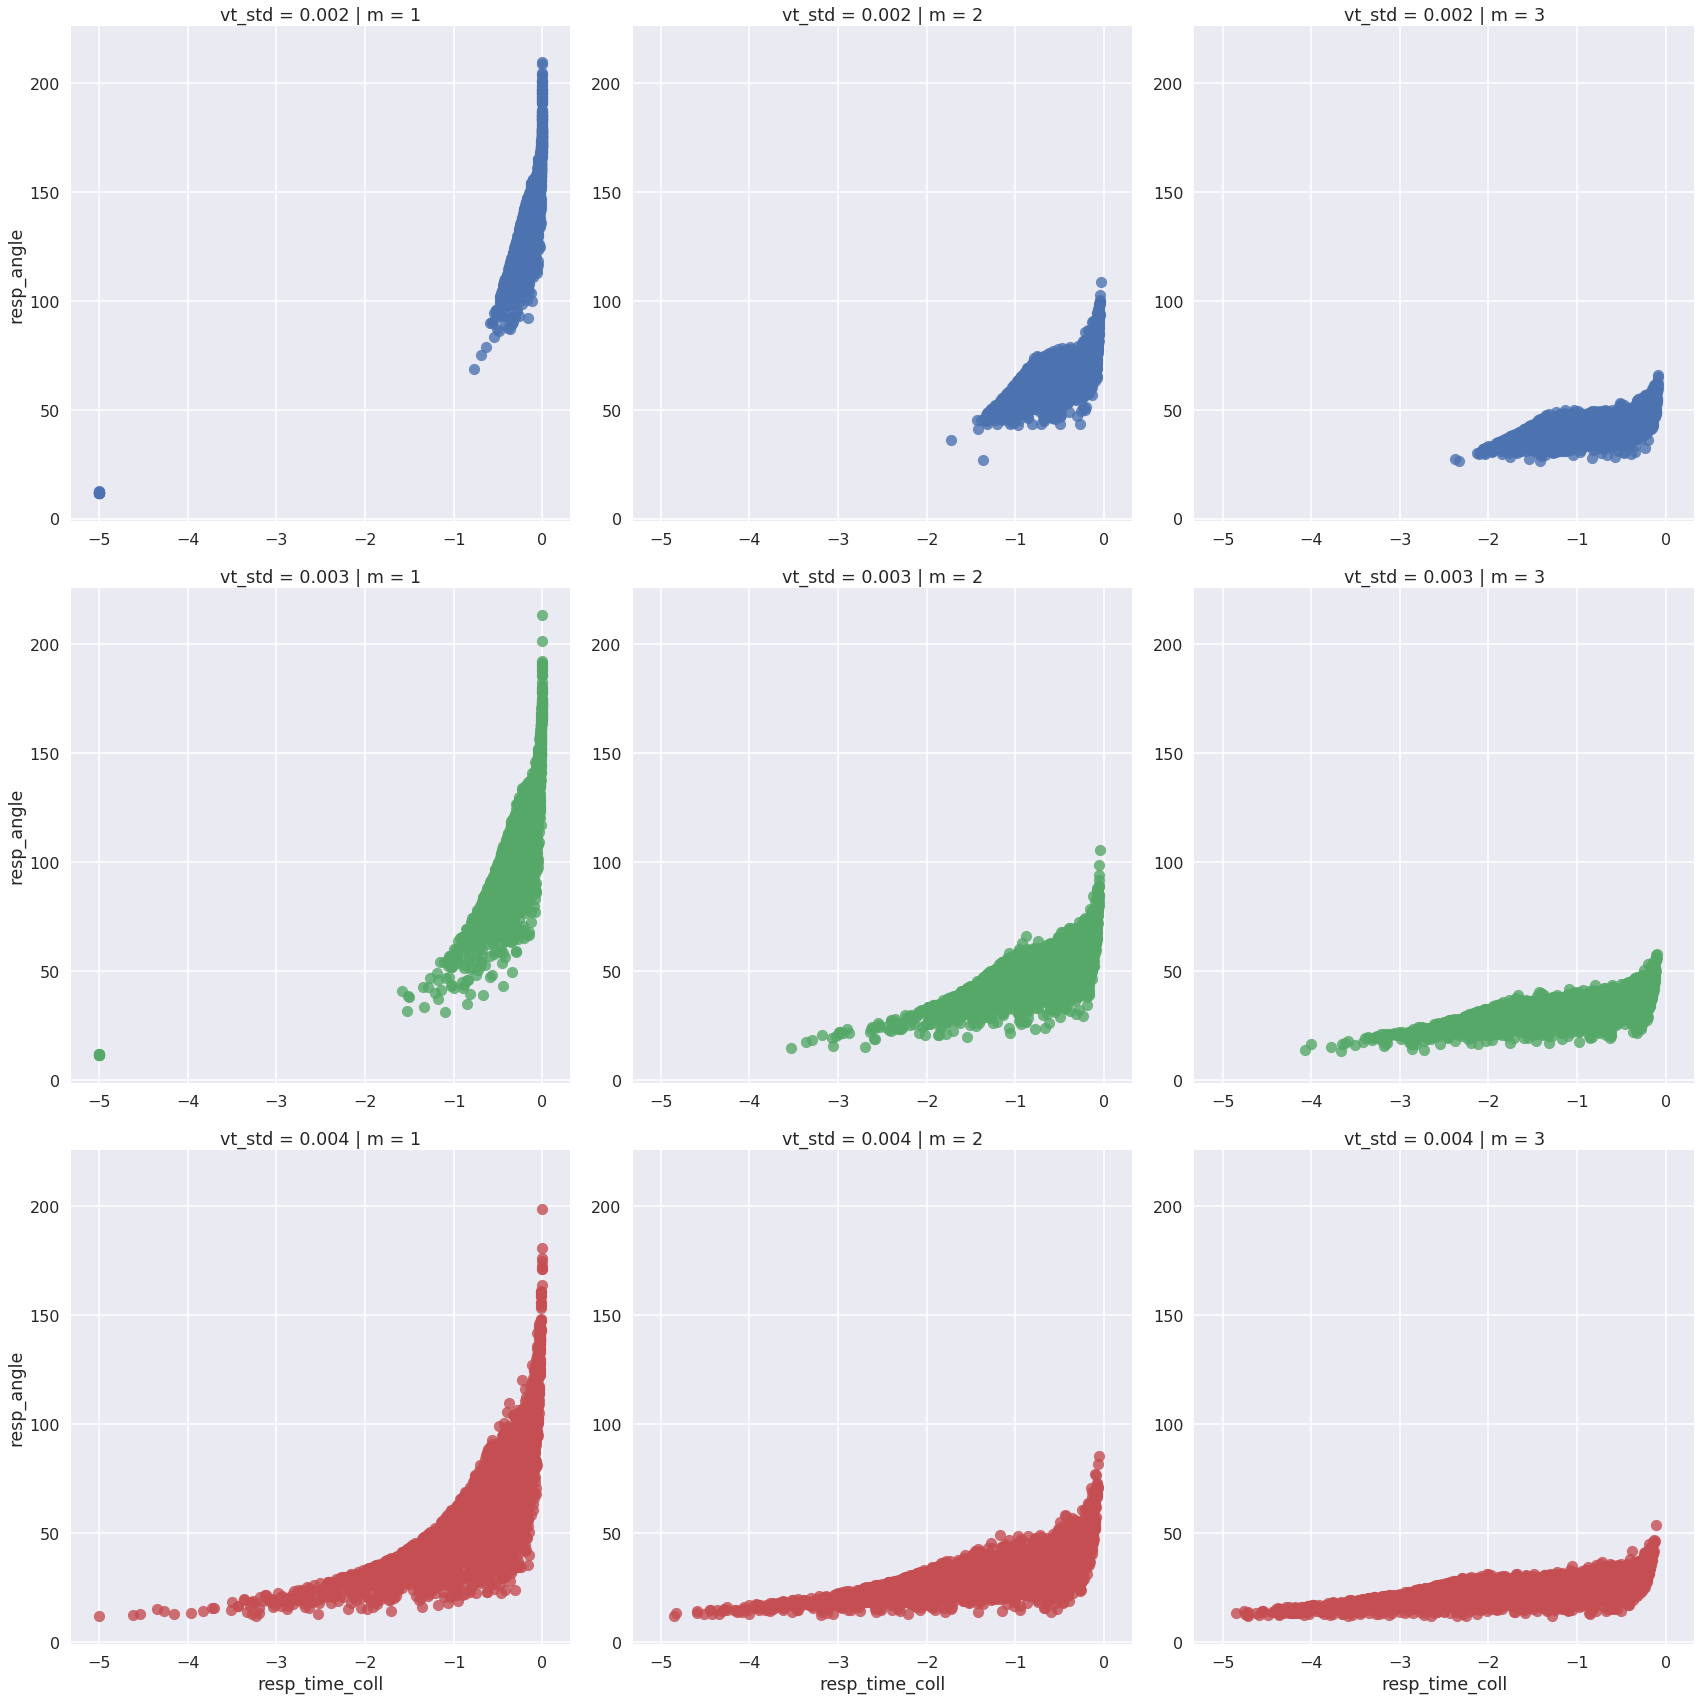

In [29]:
df_vt_noise = pd.DataFrame(data_dict)
sns.set('poster')
g = sns.lmplot(x='resp_dist', y='lv', col='m', row='vt_std', hue='vt_std', data=df_vt_noise, fit_reg=False, size=8)
g = sns.lmplot(x='resp_time', y='lv', col='m', row='vt_std', hue='vt_std', data=df_vt_noise, fit_reg=False, size=8)
g = sns.lmplot(x='m', y='resp_angle', hue='vt_std', data=df_vt_noise, fit_reg=False, size=8, x_estimator=np.mean, x_ci='sd')
plt.title('mean response angle +/- std')
g = sns.lmplot(x='m', y='resp_angle', hue='vt_std', data=df_vt_noise, fit_reg=False, size=8, x_estimator=np.std, x_ci='ci')
plt.title('std of response angle +/- 95% CI')
g = sns.lmplot(x='lv', y='resp_angle', hue='vt_std', row='vt_std', col='m', data=df_vt_noise, fit_reg=False, size=8)
g = sns.lmplot(x='lv', y='resp_time_coll', hue='vt_std', row='vt_std', col='m', data=df_vt_noise, fit_reg=True, size=8)
g = sns.lmplot(x='resp_time_coll', y='lv', hue='vt_std', row='vt_std', col='m', data=df_vt_noise, fit_reg=False, size=8)
g = sns.lmplot(x='resp_time_coll', y='resp_angle', hue='vt_std', row='vt_std', col='m', data=df_vt_noise,
               fit_reg=False, size=8)

In [30]:
def lv_map(lv):
    if lv > 0.1 and lv < 0.28:
        return 0.19
    elif lv > 0.28 and lv < 0.47:
        return 0.38
    elif lv > 0.47 and lv < 0.65:
        return 0.56
    elif lv > 0.65 and lv < 0.83:
        return 0.74
    elif lv > 0.83 and lv < 1.01:
        return 0.92
    else:
        return 1.11

df_vt_noise['lv_grouped'] = df_vt_noise['lv'].map(lv_map)
grouped = df_vt_noise.groupby(['m', 'b', 'vt_std', 'lv_grouped'], as_index=False)
df_vt_noise_means = grouped.agg({'resp_dist': np.mean,
                     'resp_time': np.mean,
                     'resp_angle': np.mean,
                     'resp_time_coll': np.mean})

df_vt_noise_stds = grouped.agg({'resp_dist': np.std,
                     'resp_time': np.std,
                     'resp_angle': np.std,
                     'resp_time_coll': np.std})

In [31]:
binsize = 1.1/6
np.arange(start=0.1+binsize/2, stop=1.2, step=binsize)

array([ 0.19166667,  0.375     ,  0.55833333,  0.74166667,  0.925     ,
        1.10833333])

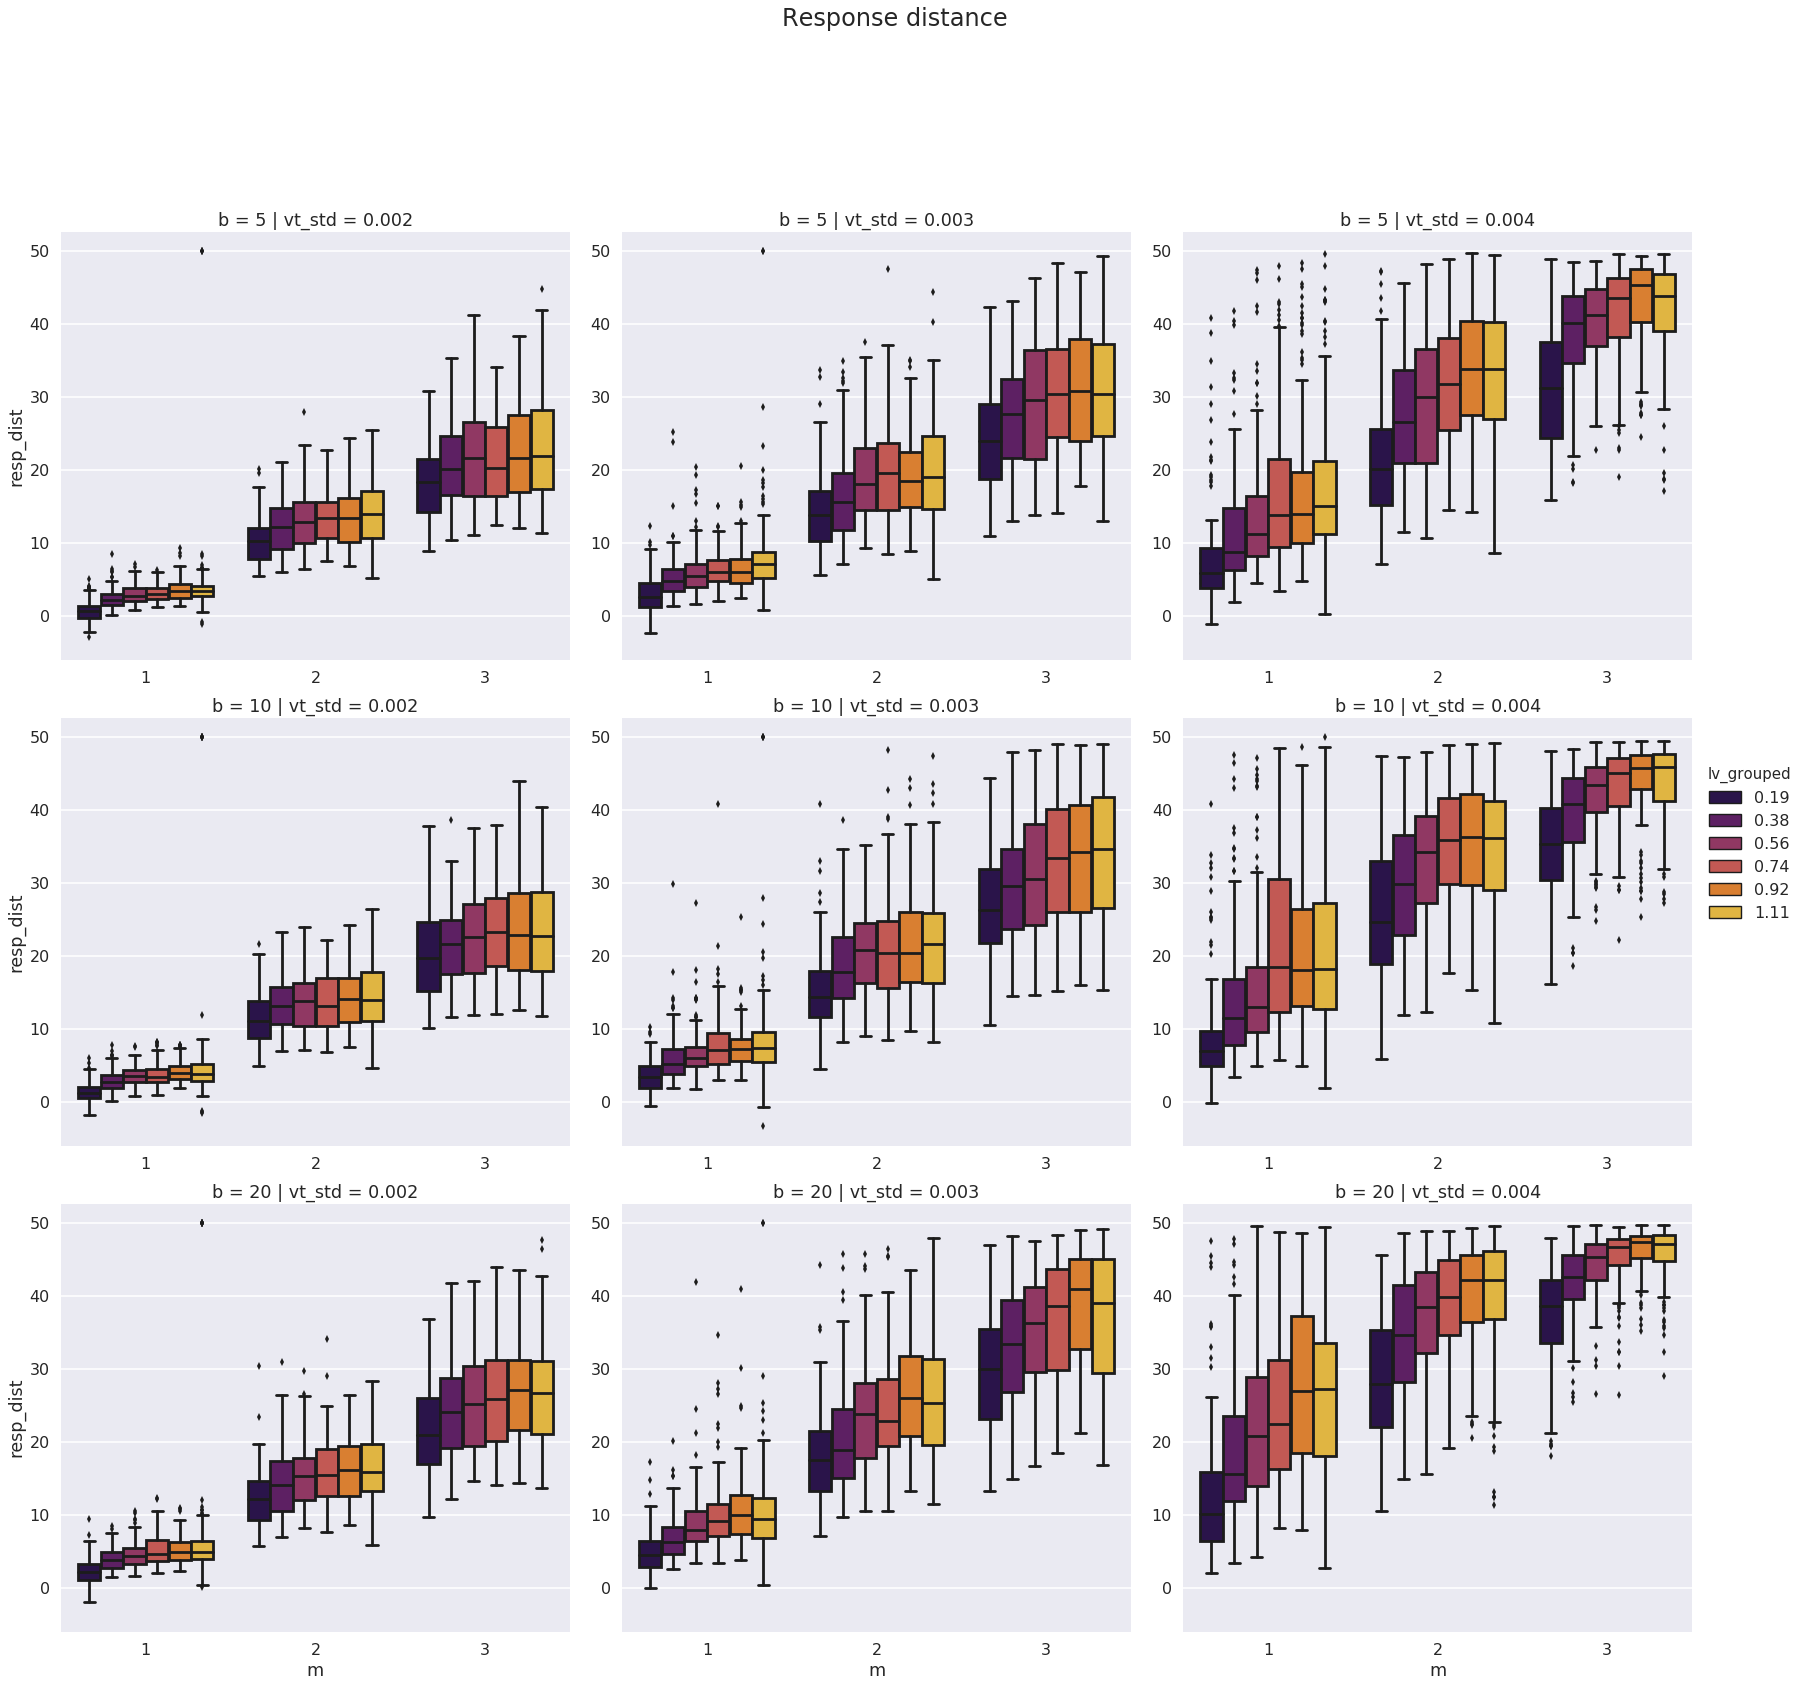

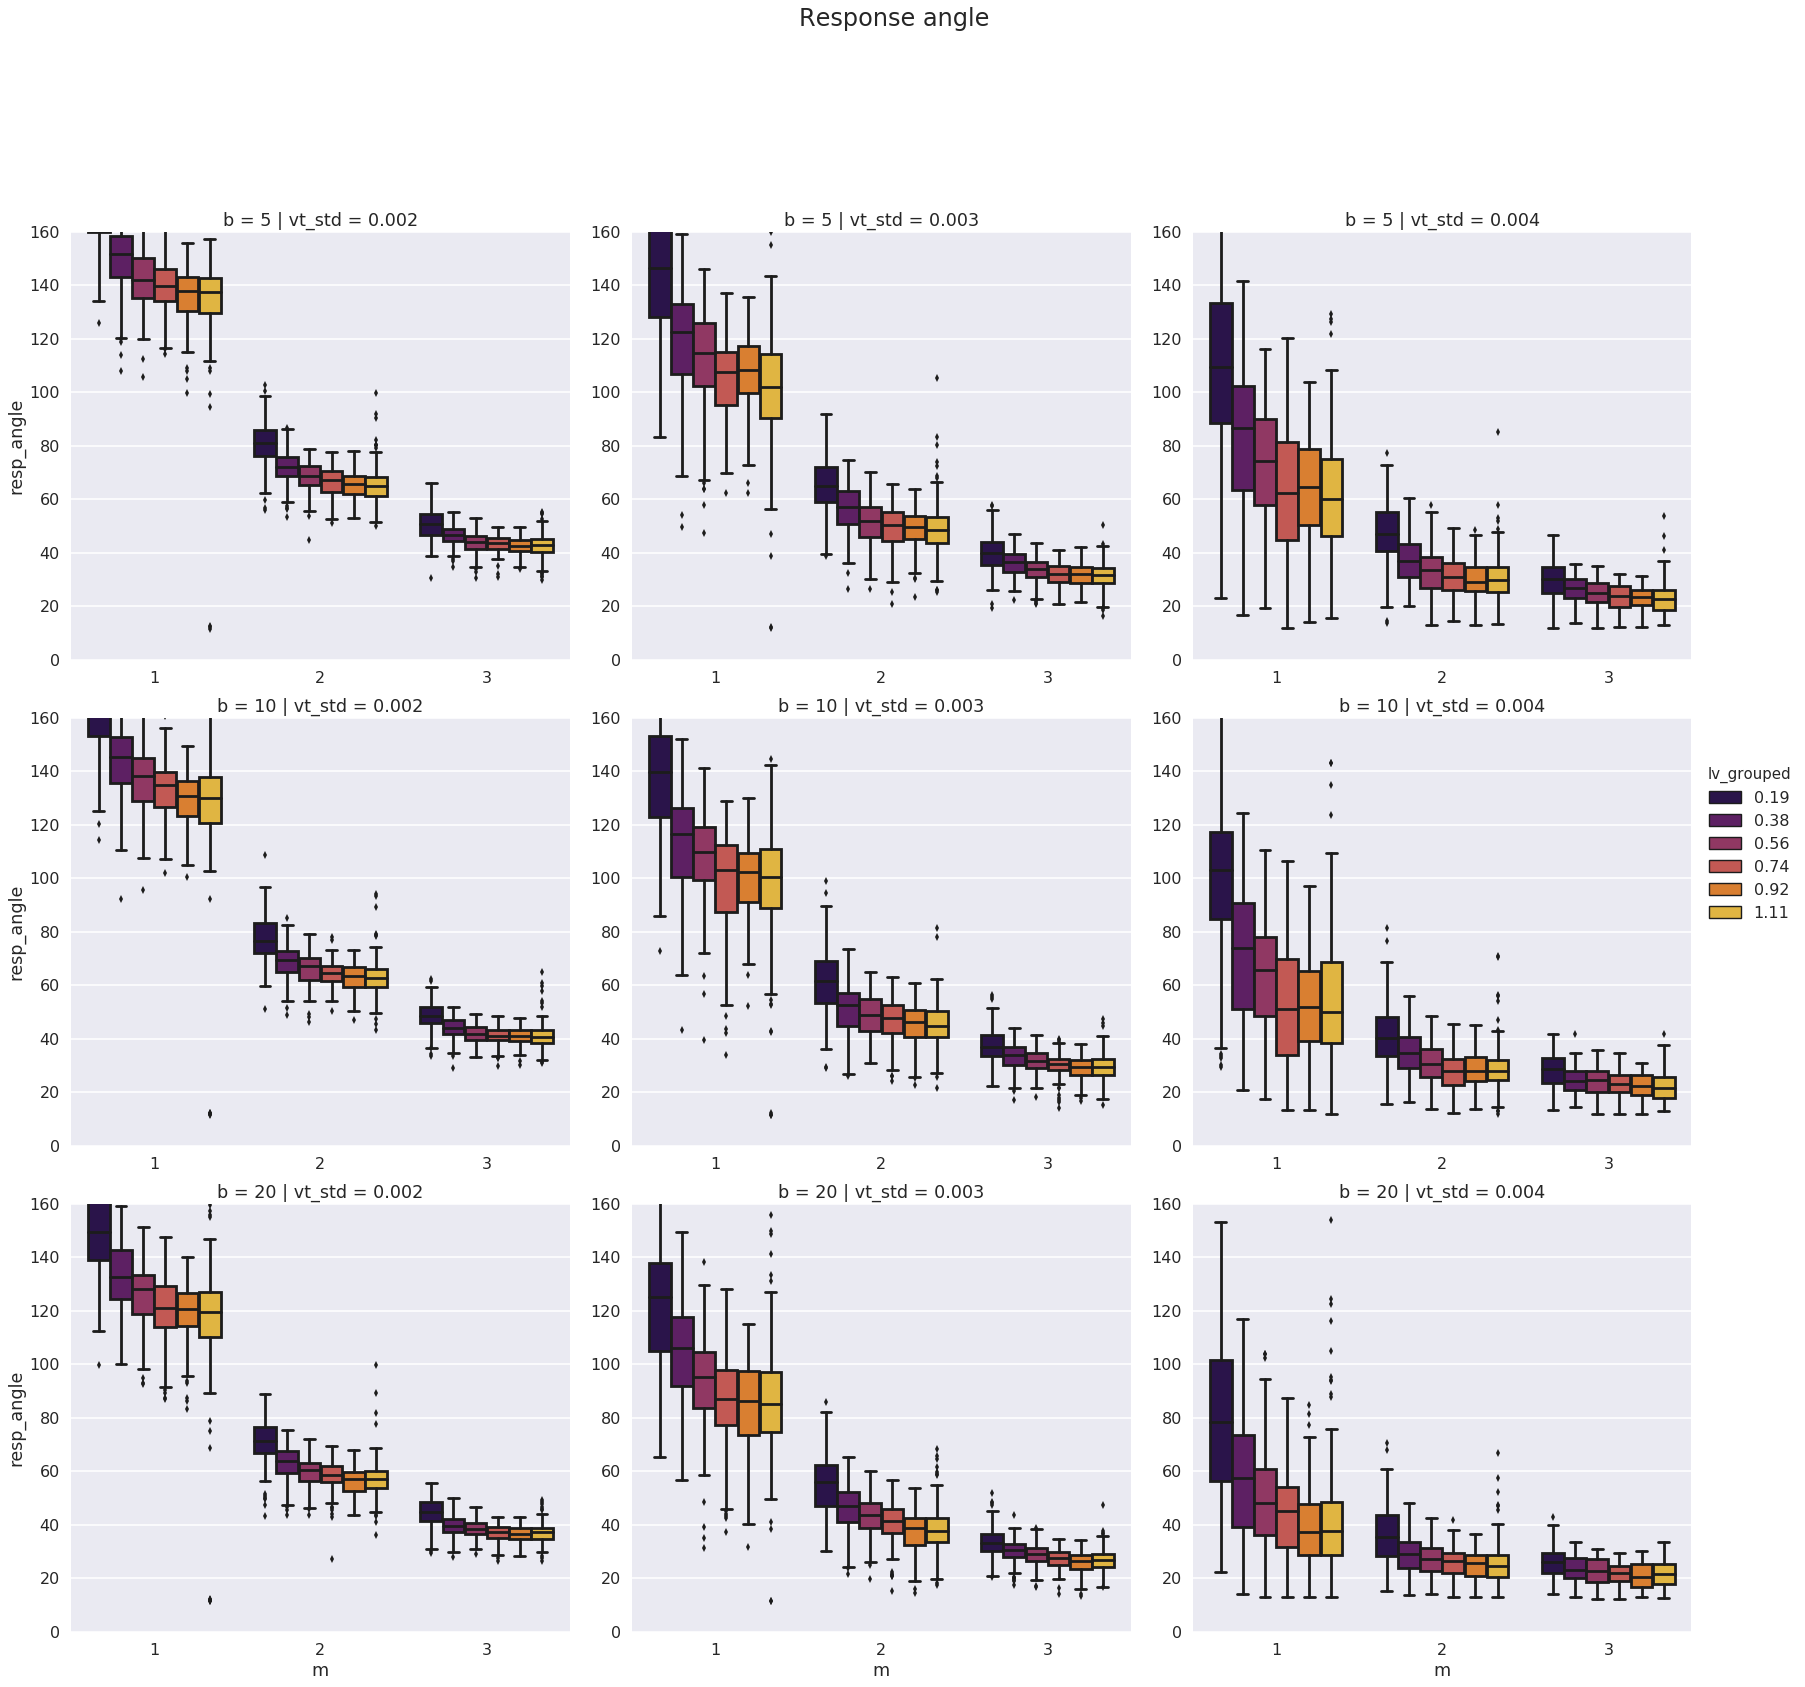

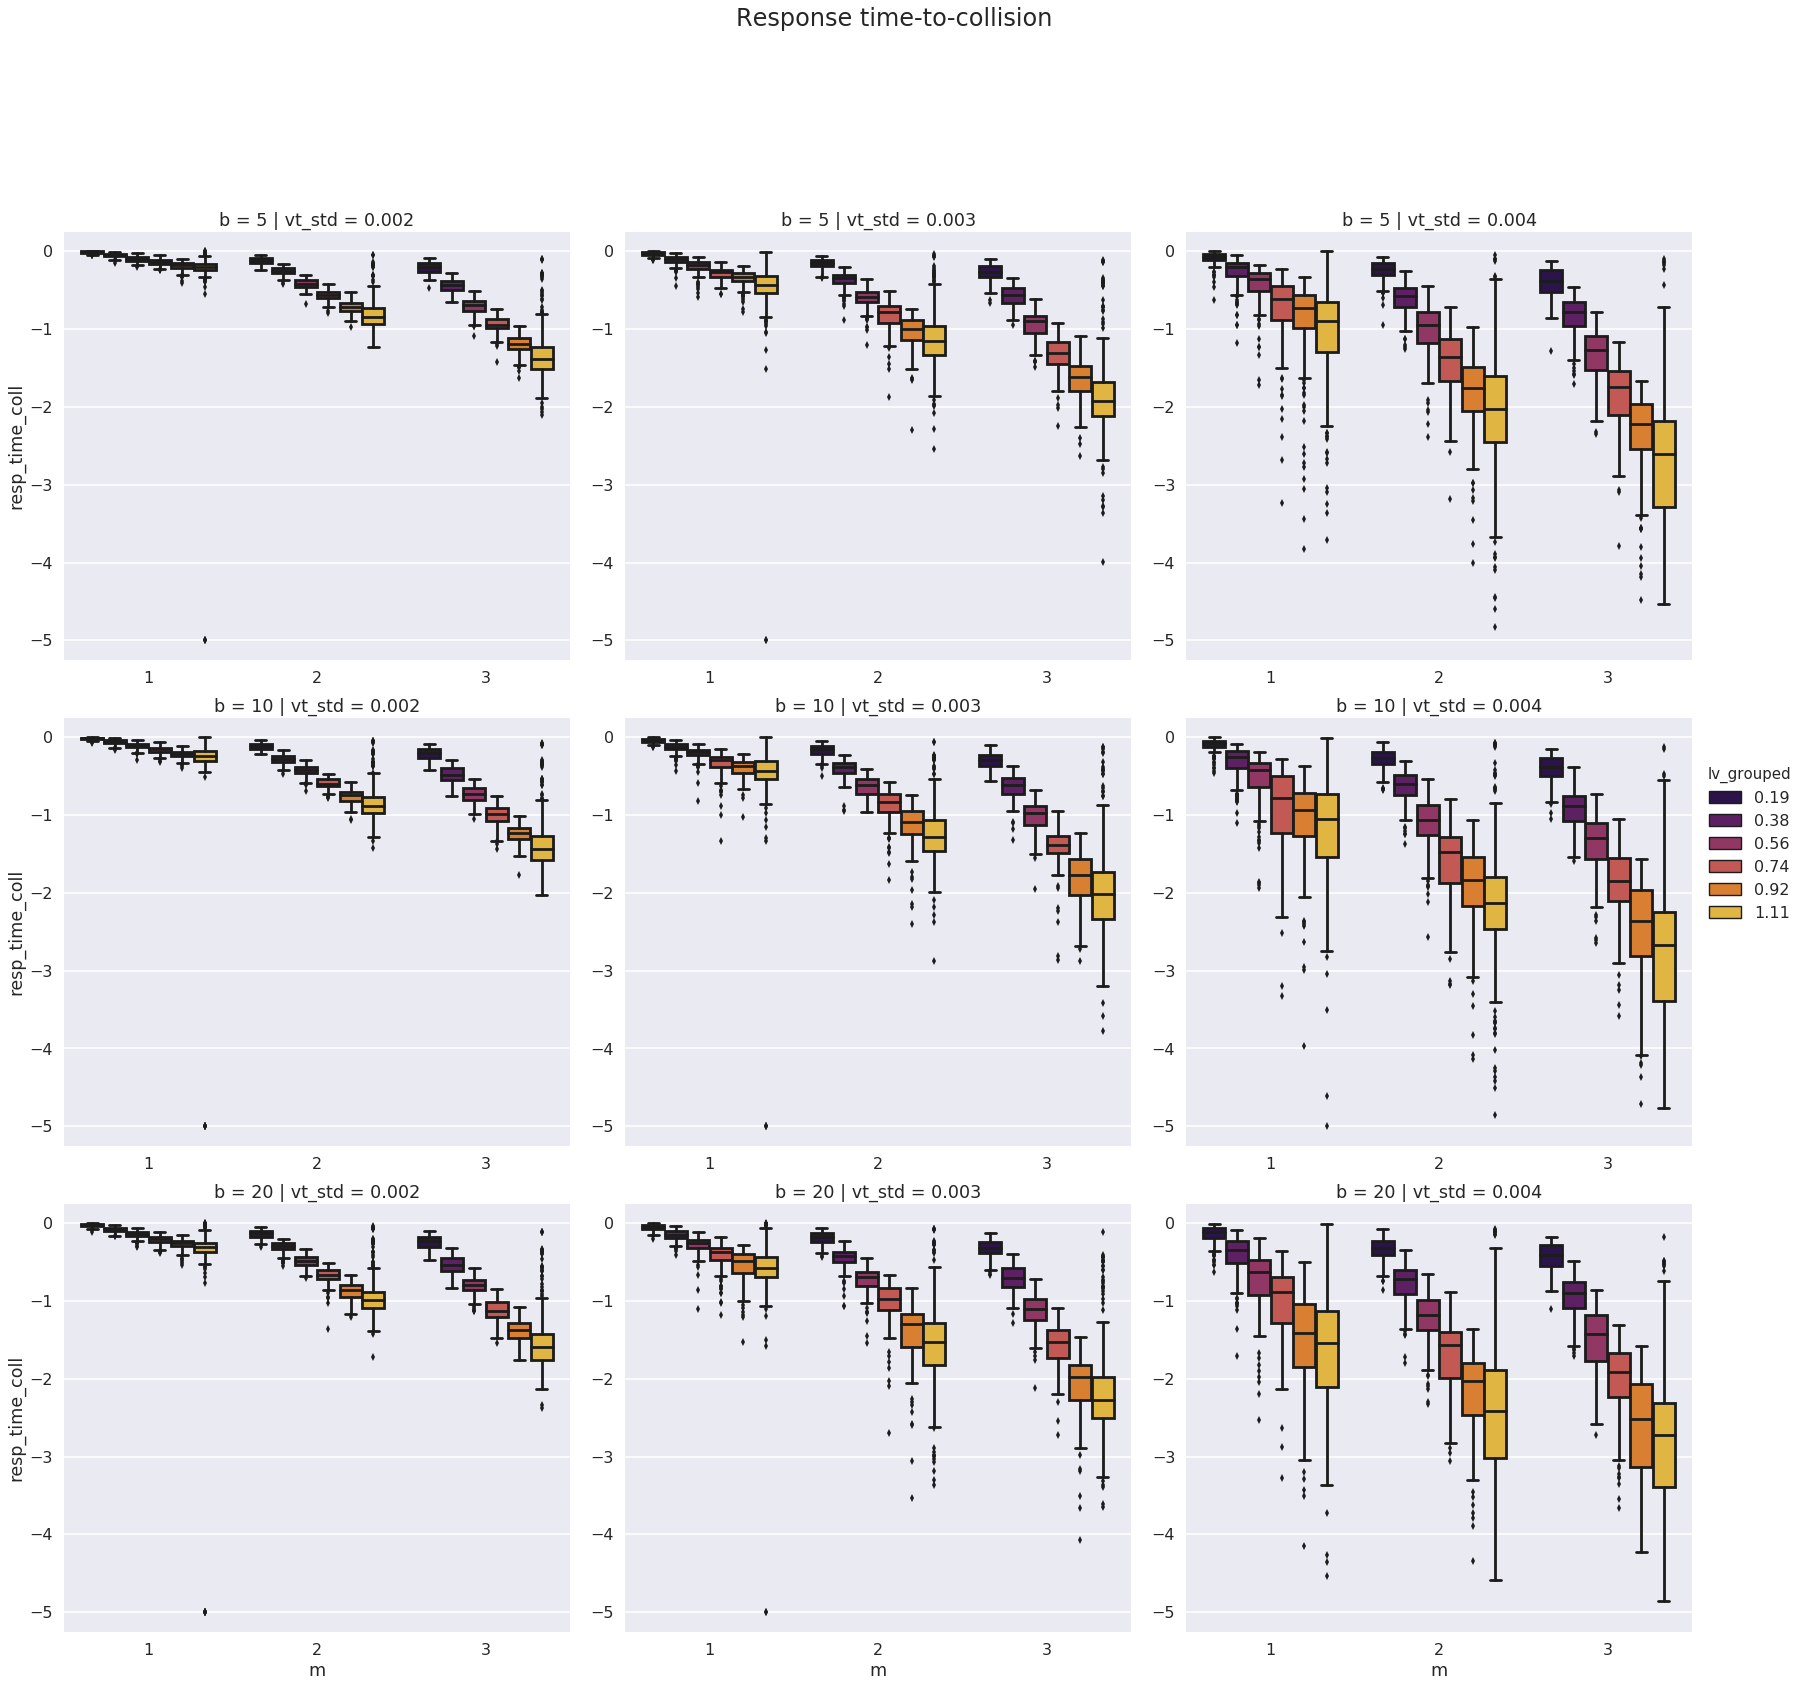

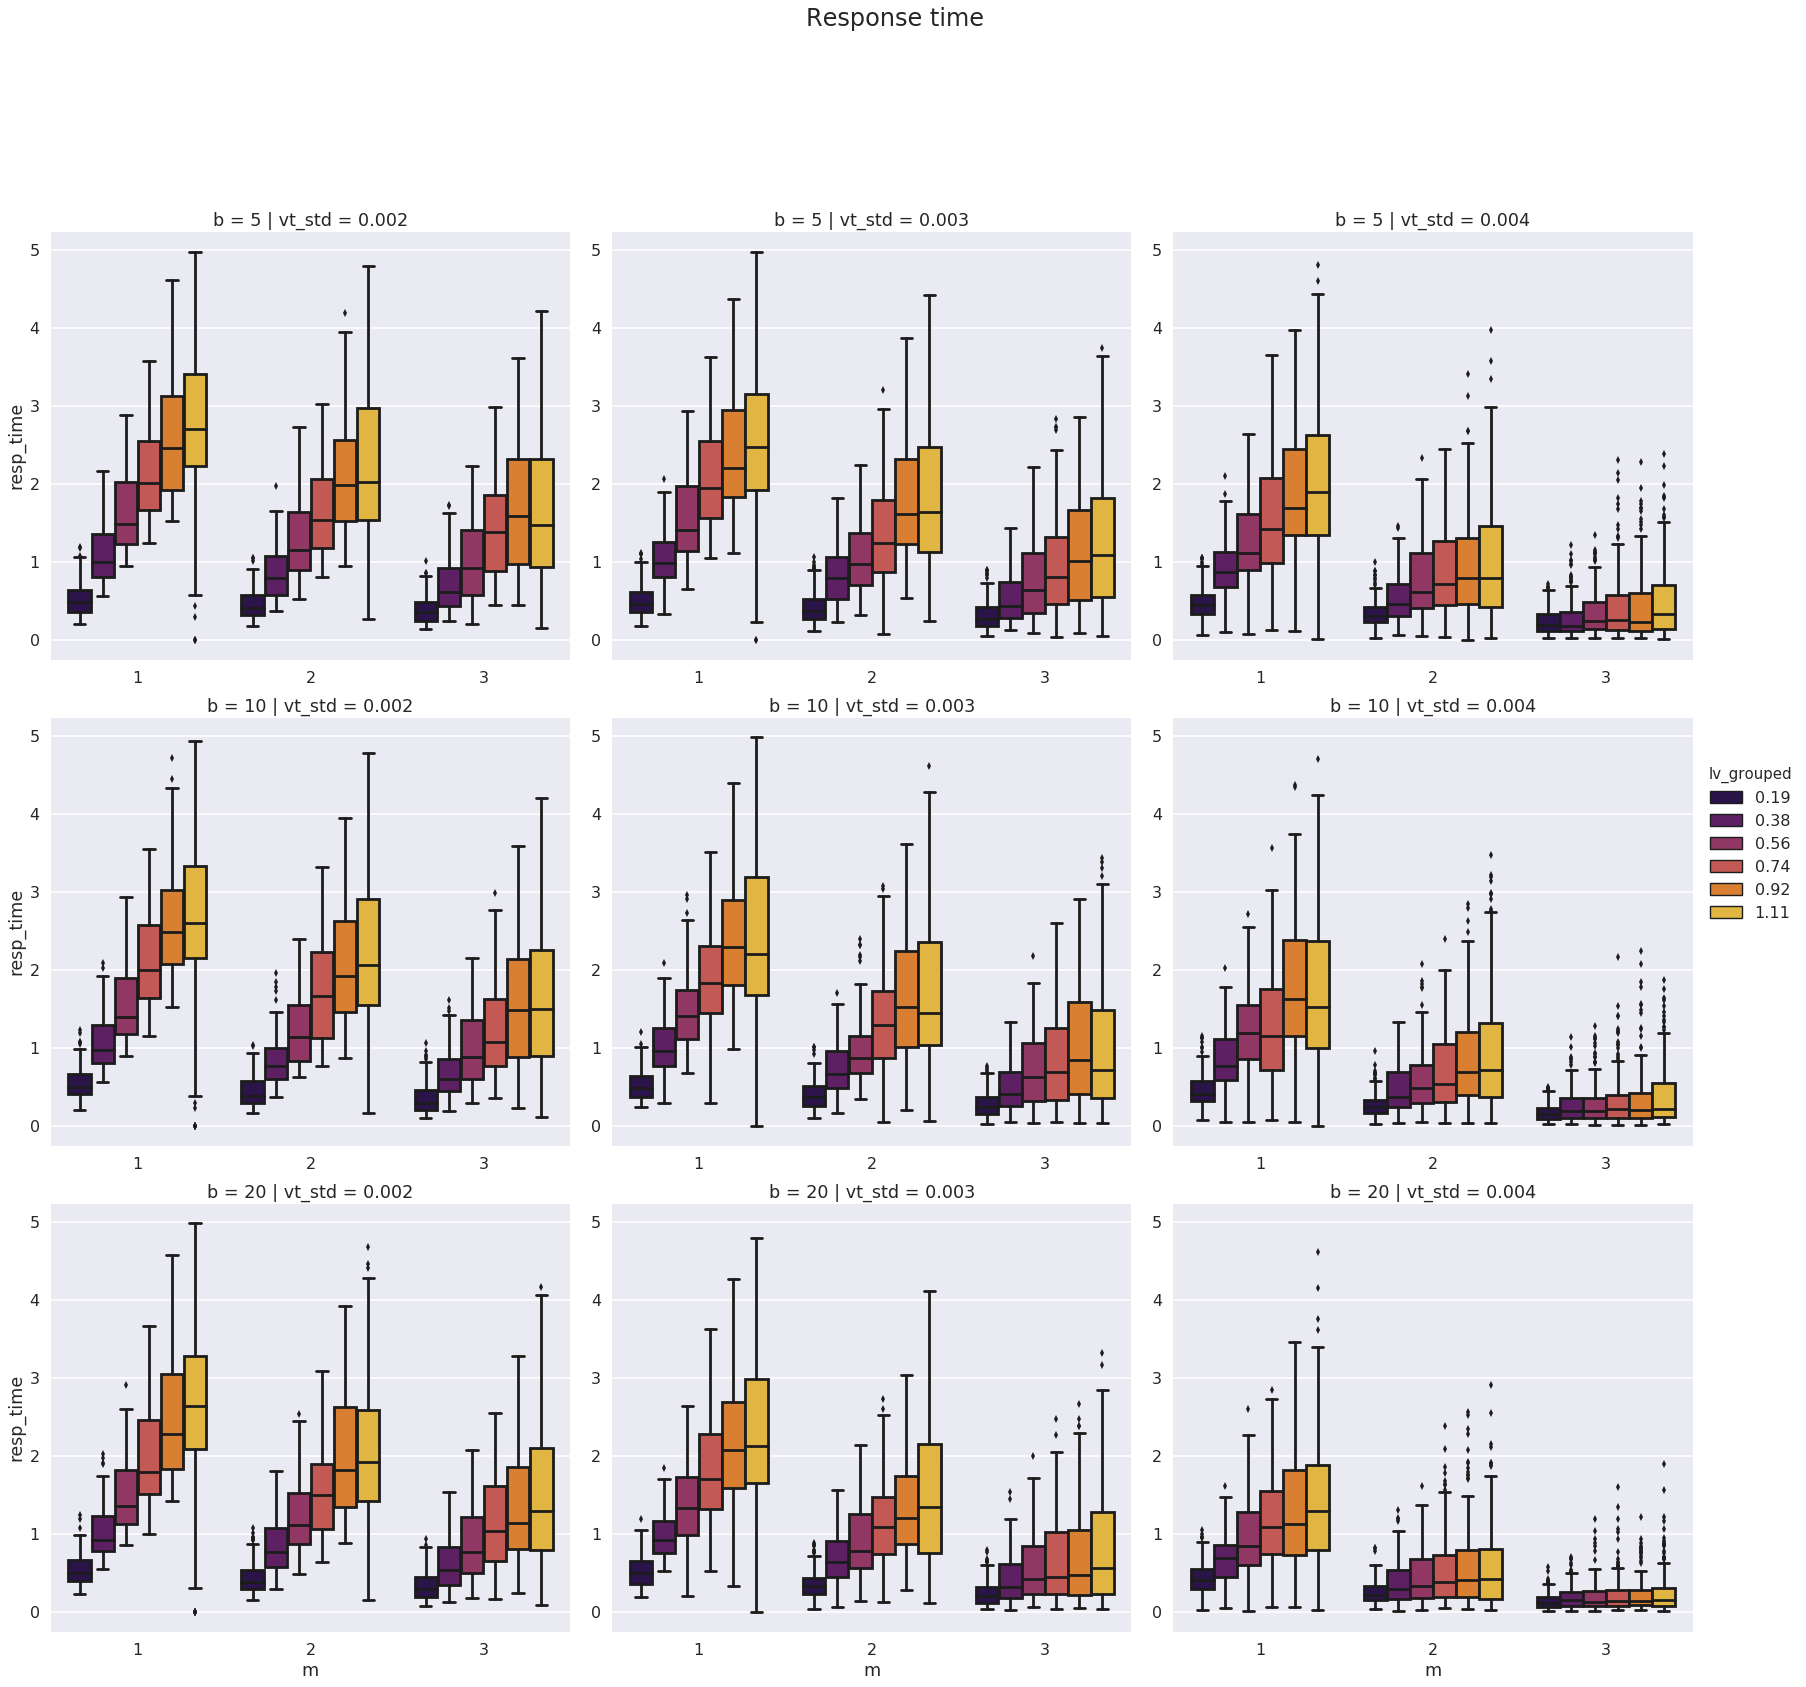

In [32]:
sns.set('poster')
g = sns.factorplot(x='m', y='resp_dist', col='vt_std', row='b', hue='lv_grouped', data=df_vt_noise, size=8, aspect=1,
               palette='inferno', kind='box')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Response distance', fontsize=24)
g.savefig('resp_dist_boxplots.pdf')

g = sns.factorplot(x='m', y='resp_angle', col='vt_std', row='b', hue='lv_grouped', data=df_vt_noise, size=8, aspect=1,
               palette='inferno', kind='box')
plt.ylim([0, 160])
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Response angle', fontsize=24)
g.savefig('resp_angle_boxplots.pdf')

g = sns.factorplot(x='m', y='resp_time_coll', col='vt_std', row='b', hue='lv_grouped', data=df_vt_noise, size=8, aspect=1,
               palette='inferno', kind='box')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Response time-to-collision', fontsize=24)
g.savefig('resp_time_coll_boxplots.pdf')

g = sns.factorplot(x='m', y='resp_time', col='vt_std', row='b', hue='lv_grouped', data=df_vt_noise, size=8, aspect=1,
               palette='inferno', kind='box')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Response time', fontsize=24)
g.savefig('resp_time_boxplots.pdf')

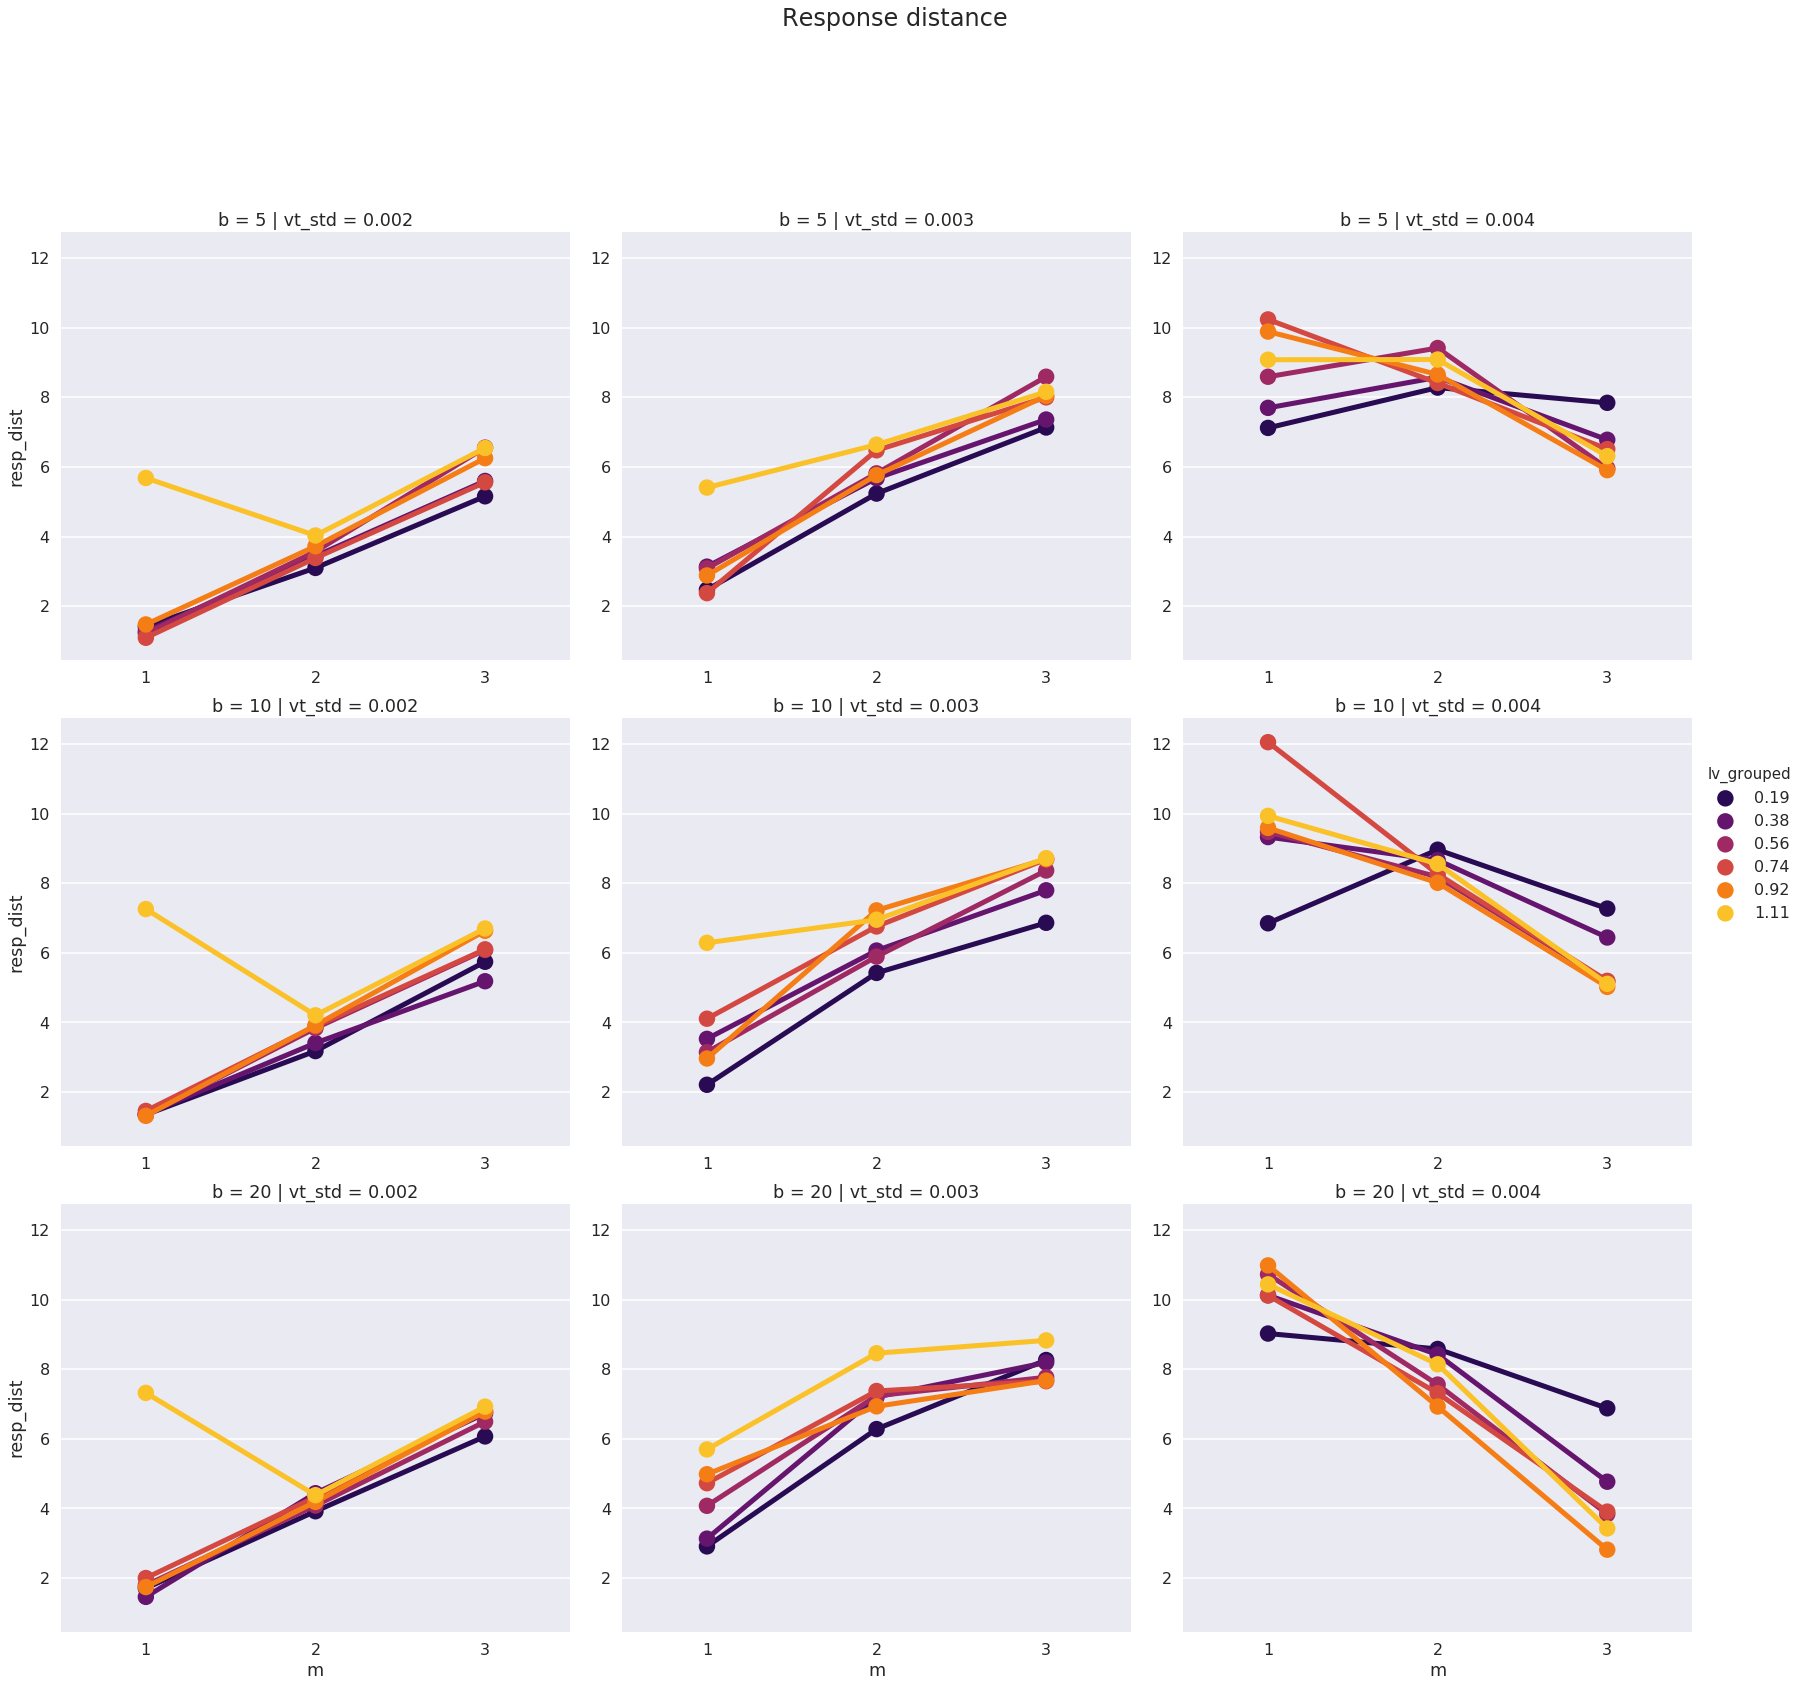

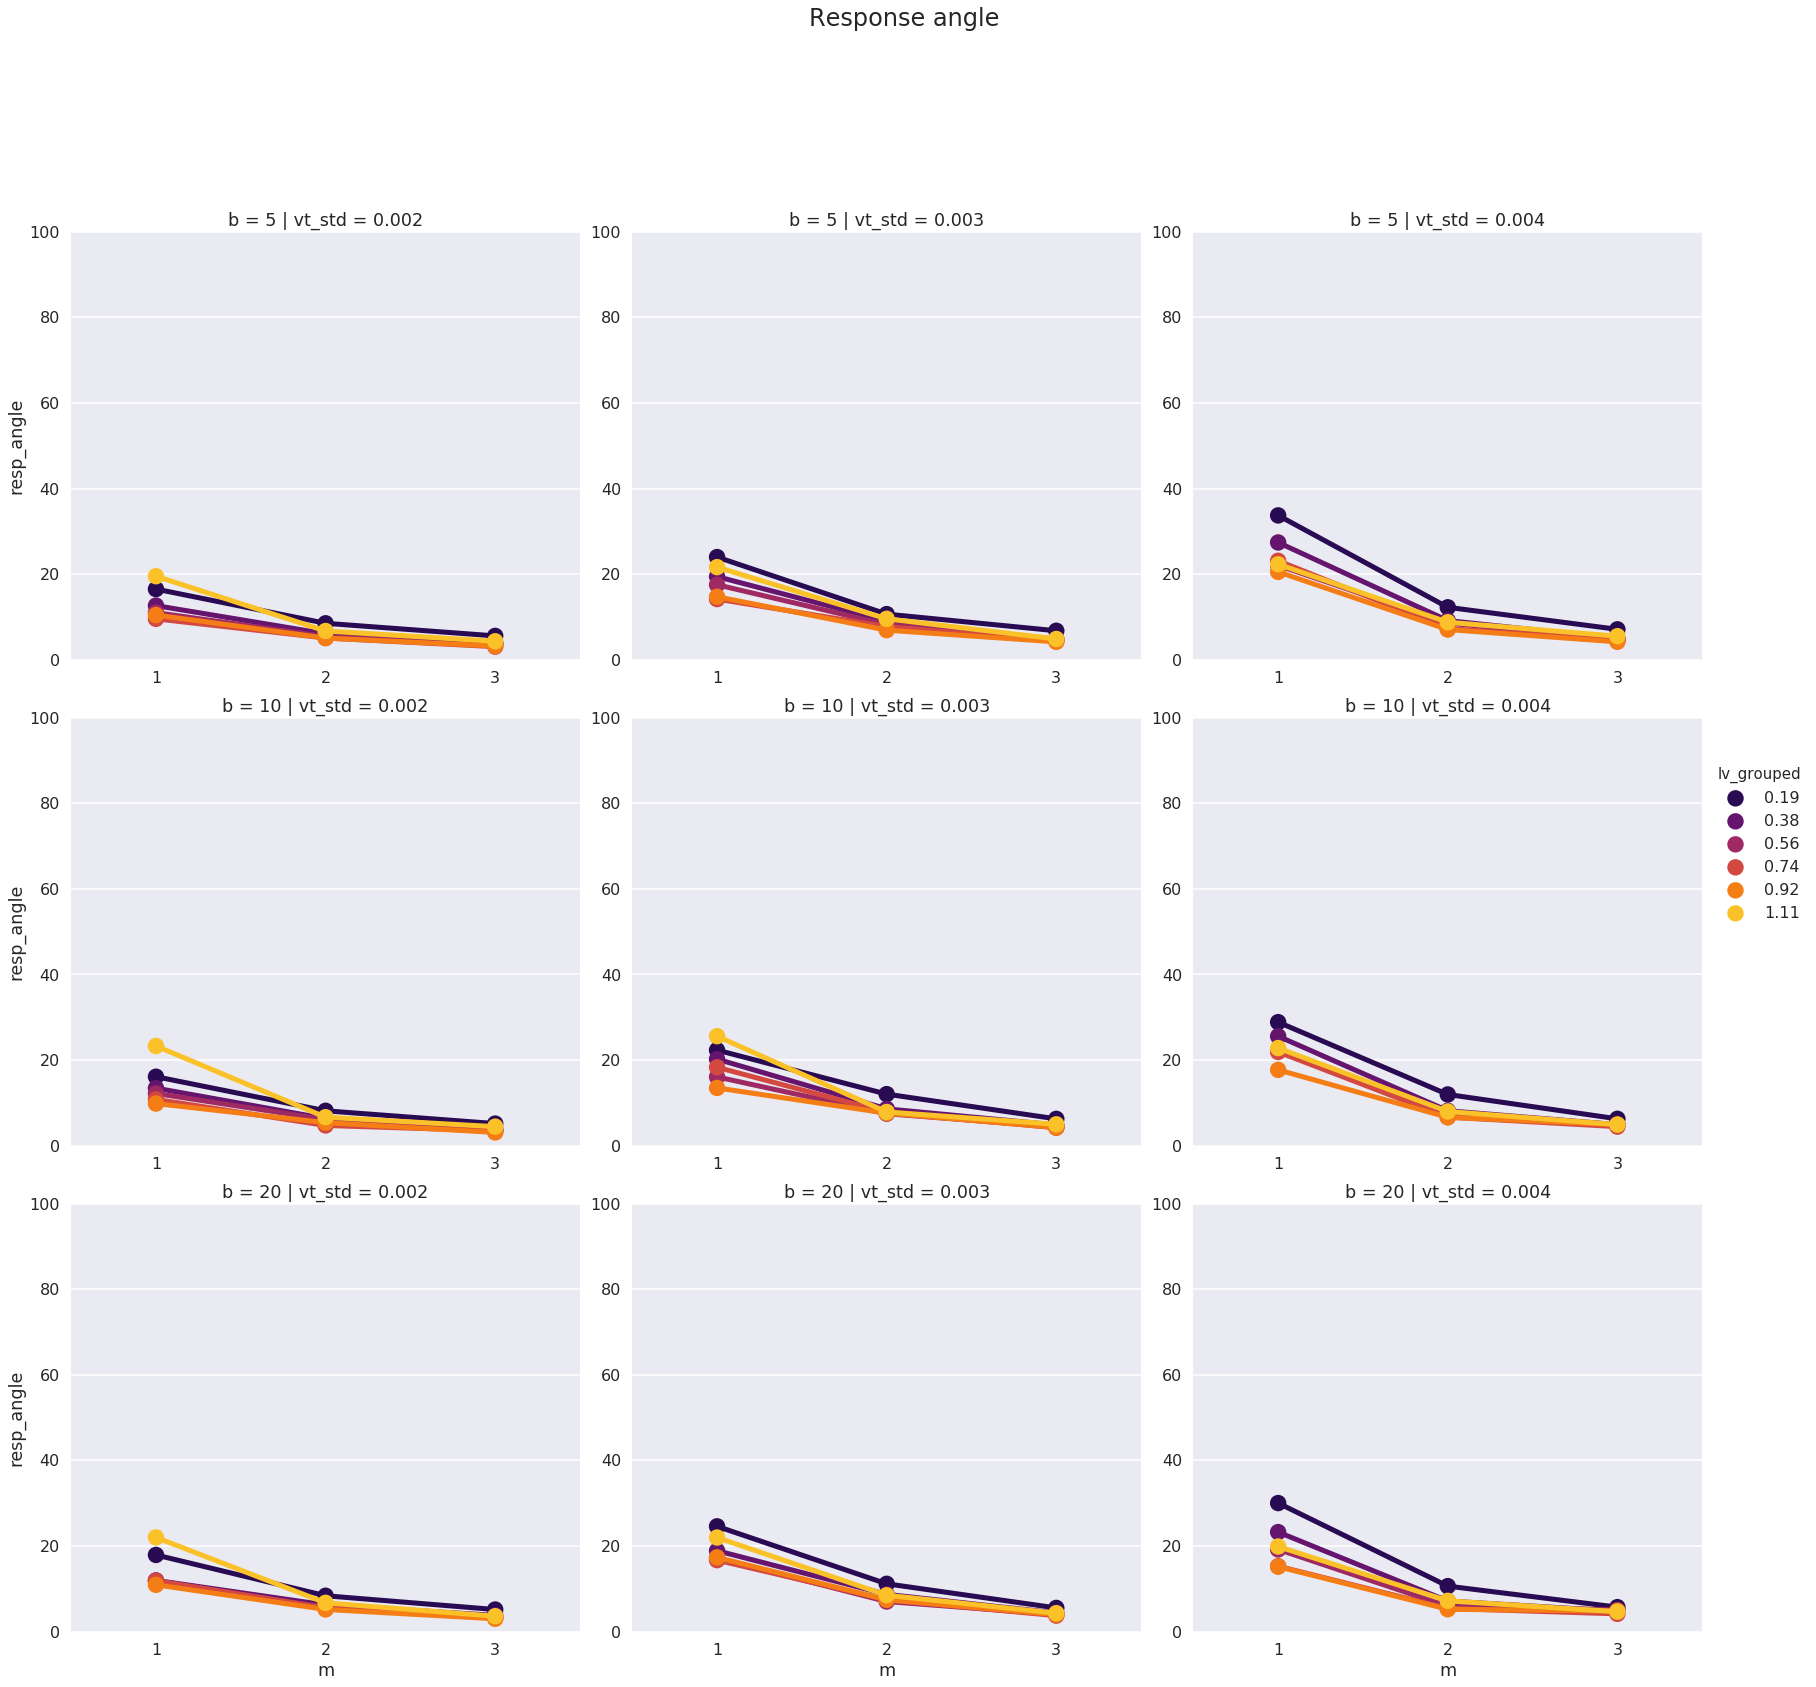

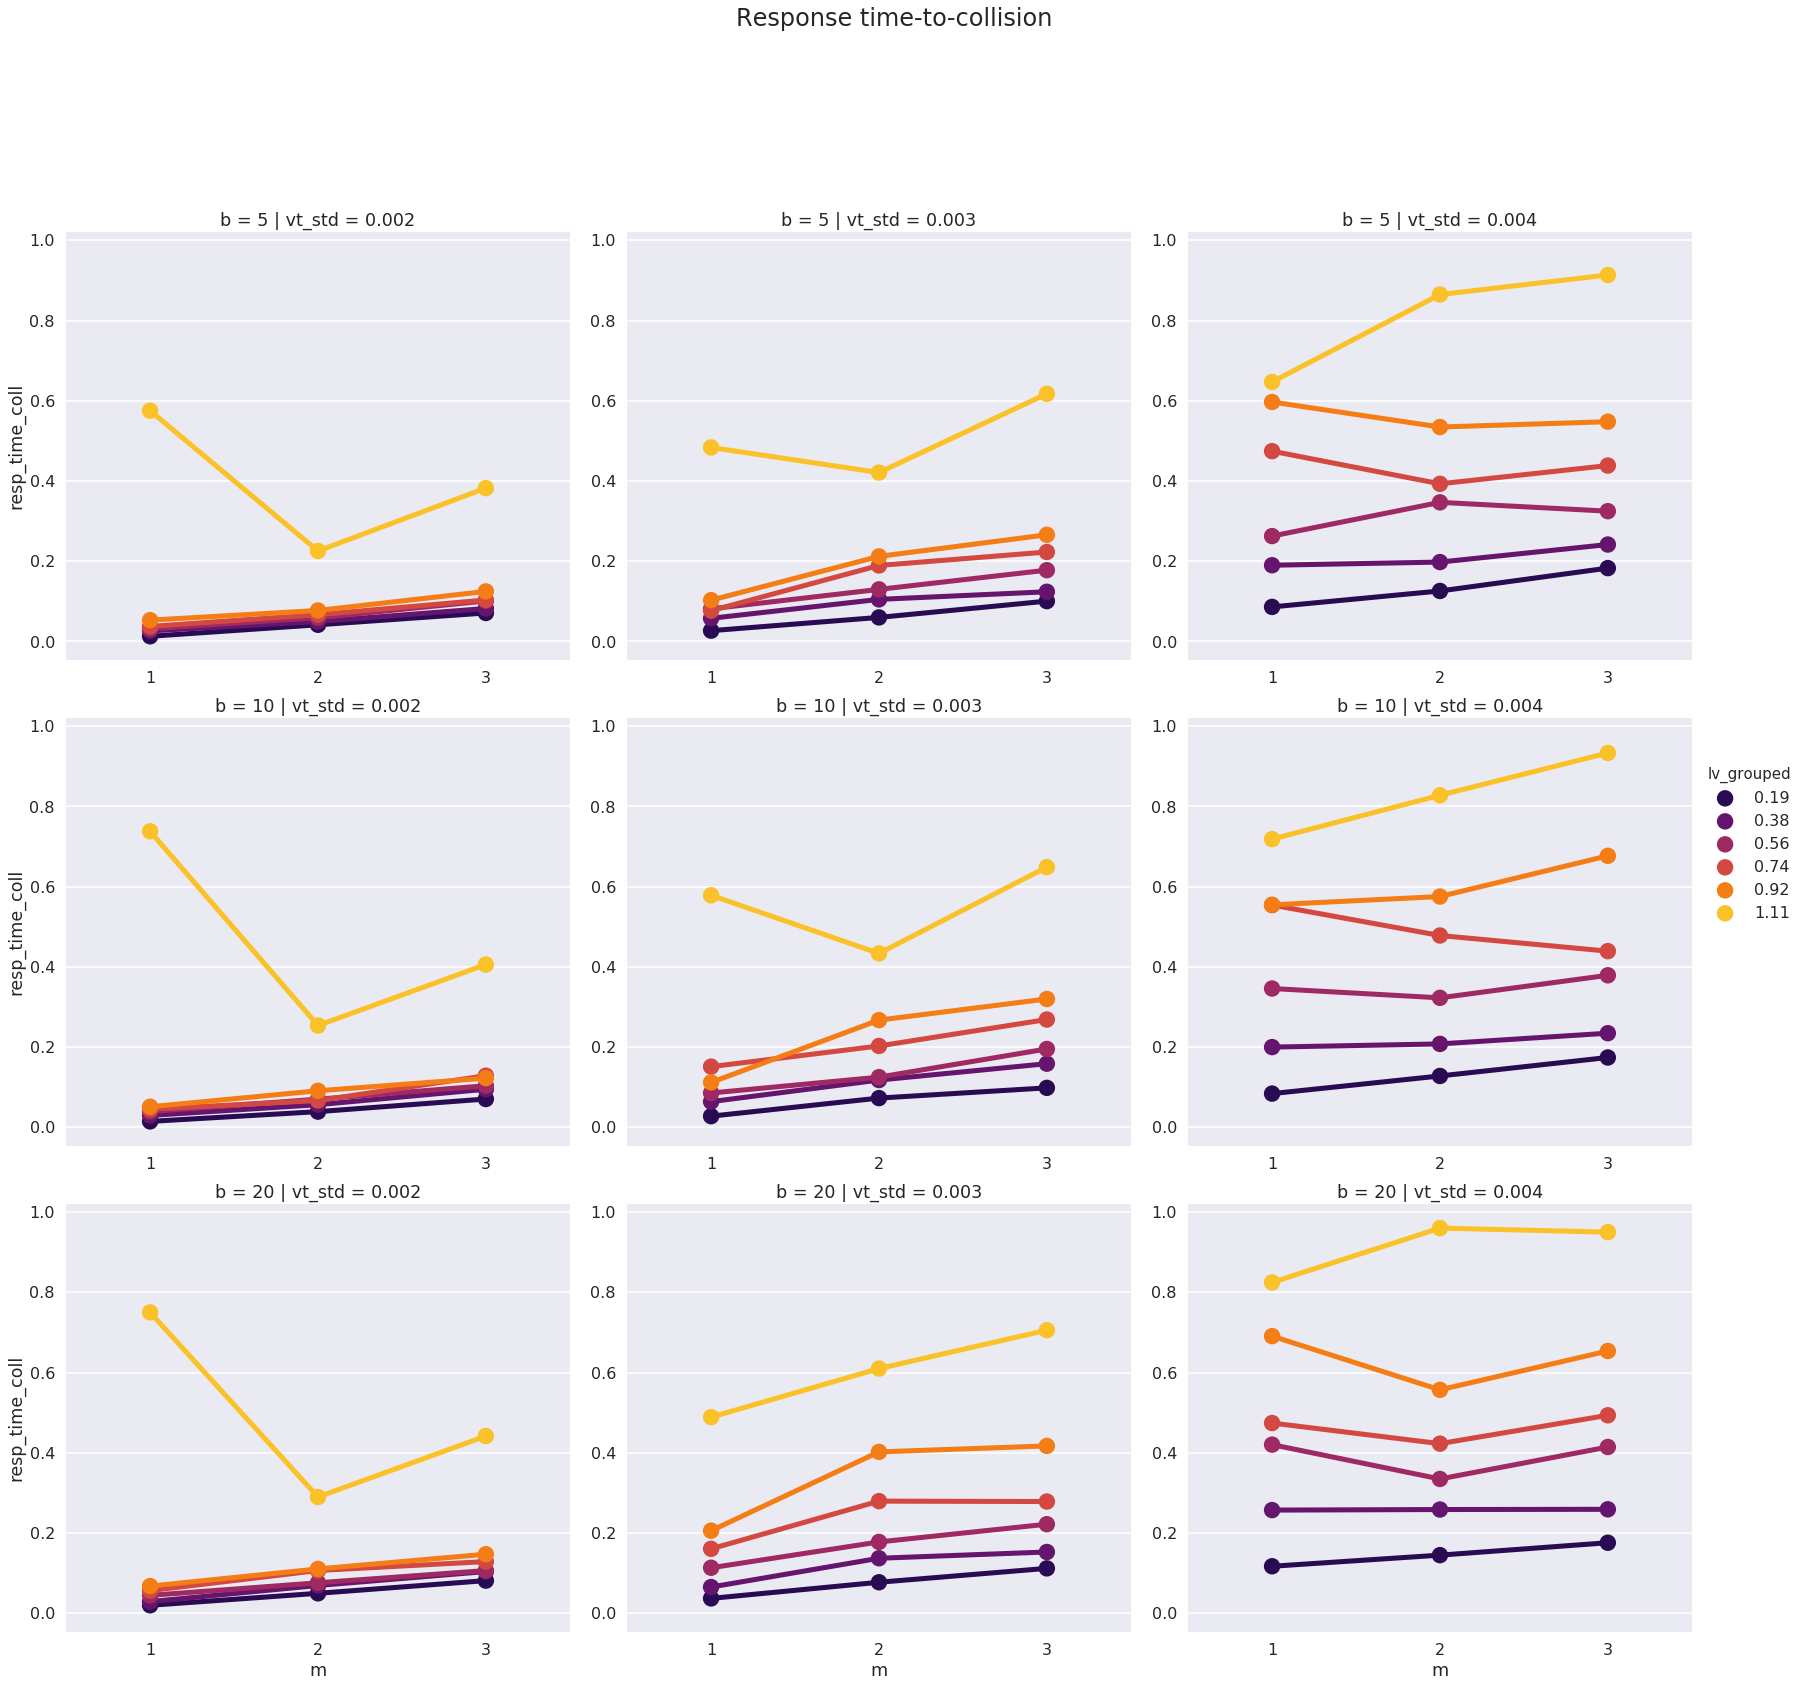

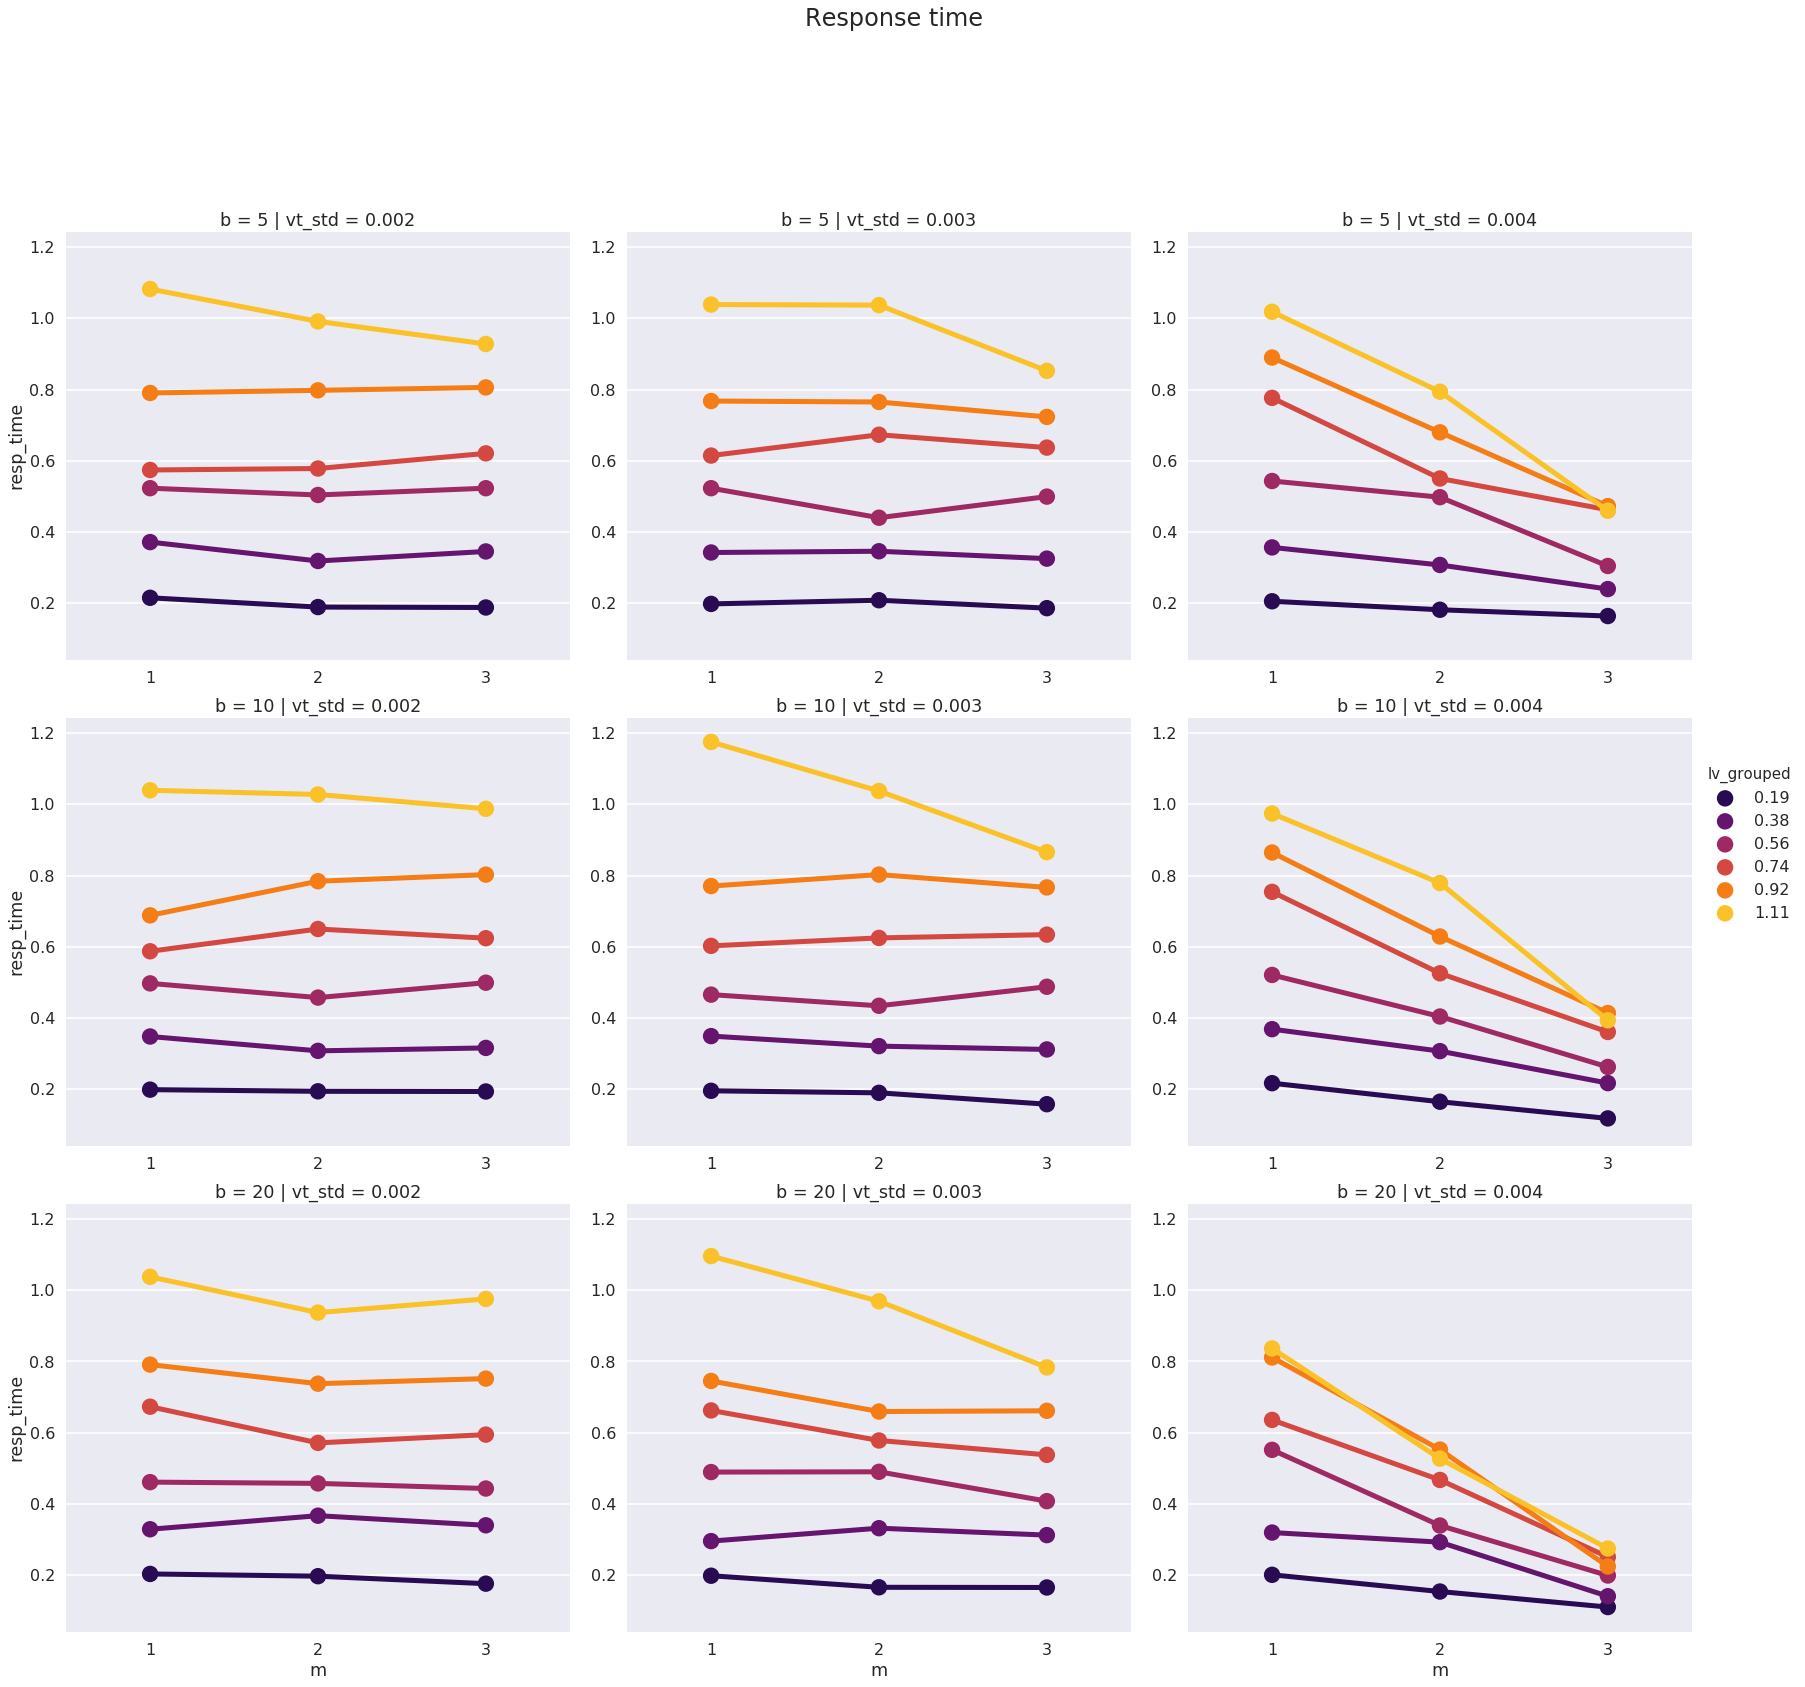

In [33]:
sns.set('poster')
g = sns.factorplot(x='m', y='resp_dist', col='vt_std', row='b', hue='lv_grouped', data=df_vt_noise_stds, size=8, aspect=1,
               palette='inferno', kind='point')
g.set_axis_labels()
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Response distance', fontsize=24)
g.savefig('resp_dist_stds.pdf')

g = sns.factorplot(x='m', y='resp_angle', col='vt_std', row='b', hue='lv_grouped', data=df_vt_noise_stds, size=8, aspect=1,
               palette='inferno', kind='point')
plt.ylim([0, 100])
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Response angle', fontsize=24)
g.savefig('resp_angle_stds.pdf')

g = sns.factorplot(x='m', y='resp_time_coll', col='vt_std', row='b', hue='lv_grouped', data=df_vt_noise_stds, size=8, aspect=1,
               palette='inferno', kind='point')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Response time-to-collision', fontsize=24)
g.savefig('resp_time_coll_stds.pdf')

g = sns.factorplot(x='m', y='resp_time', col='vt_std', row='b', hue='lv_grouped', data=df_vt_noise_stds, size=8, aspect=1,
               palette='inferno', kind='point')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Response time', fontsize=24)
g.savefig('resp_time_stds.pdf')

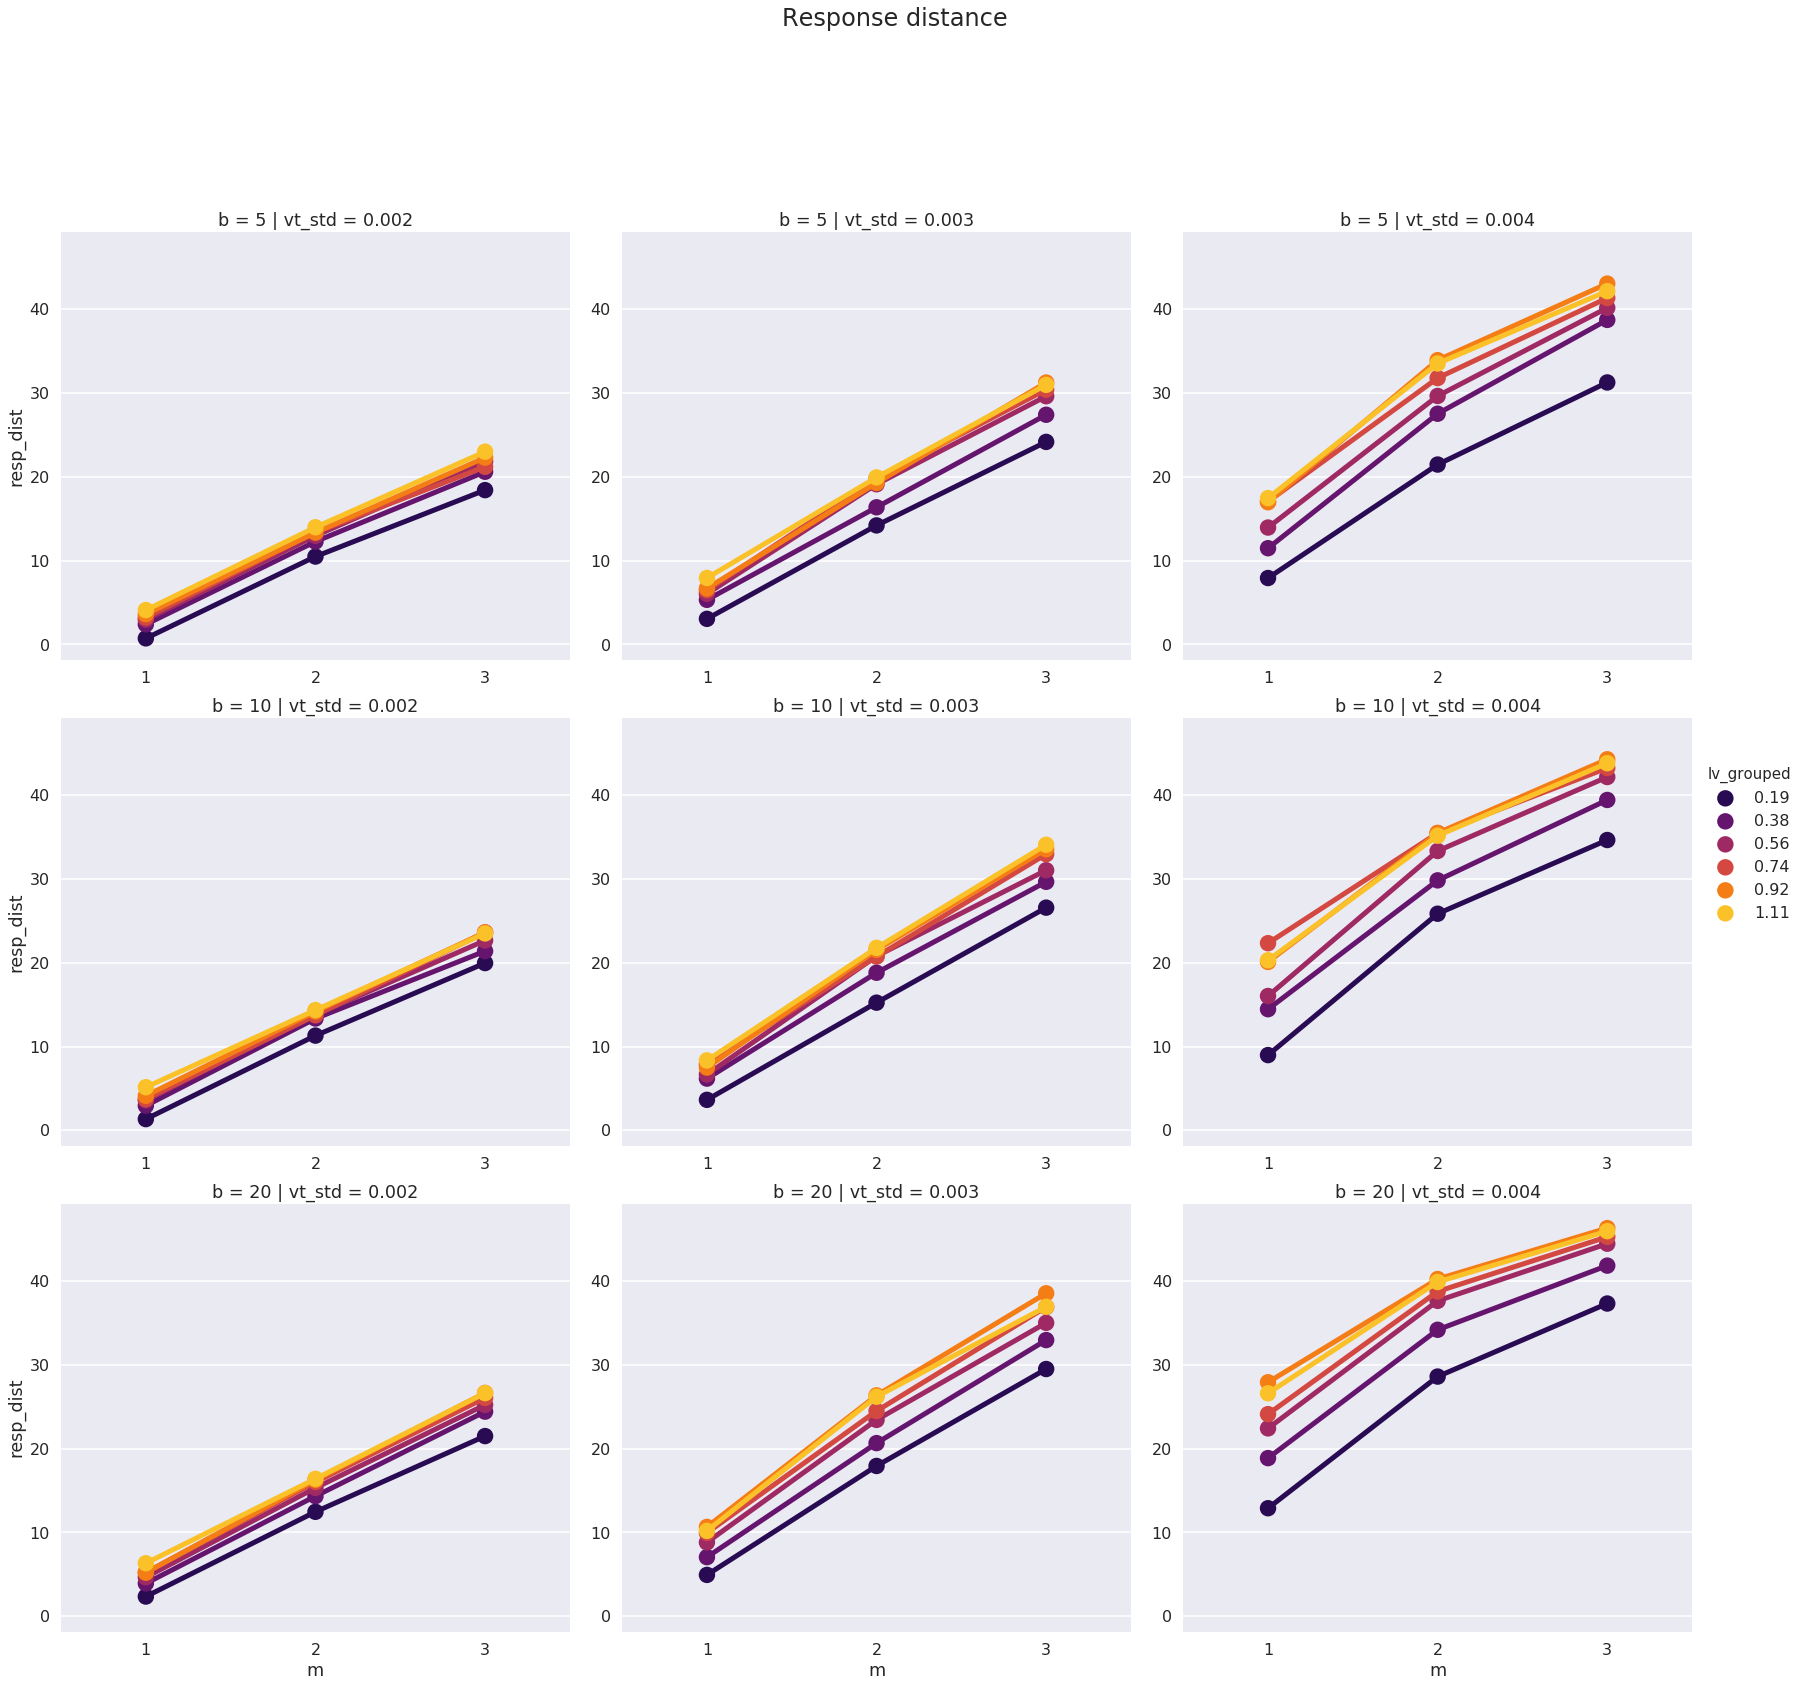

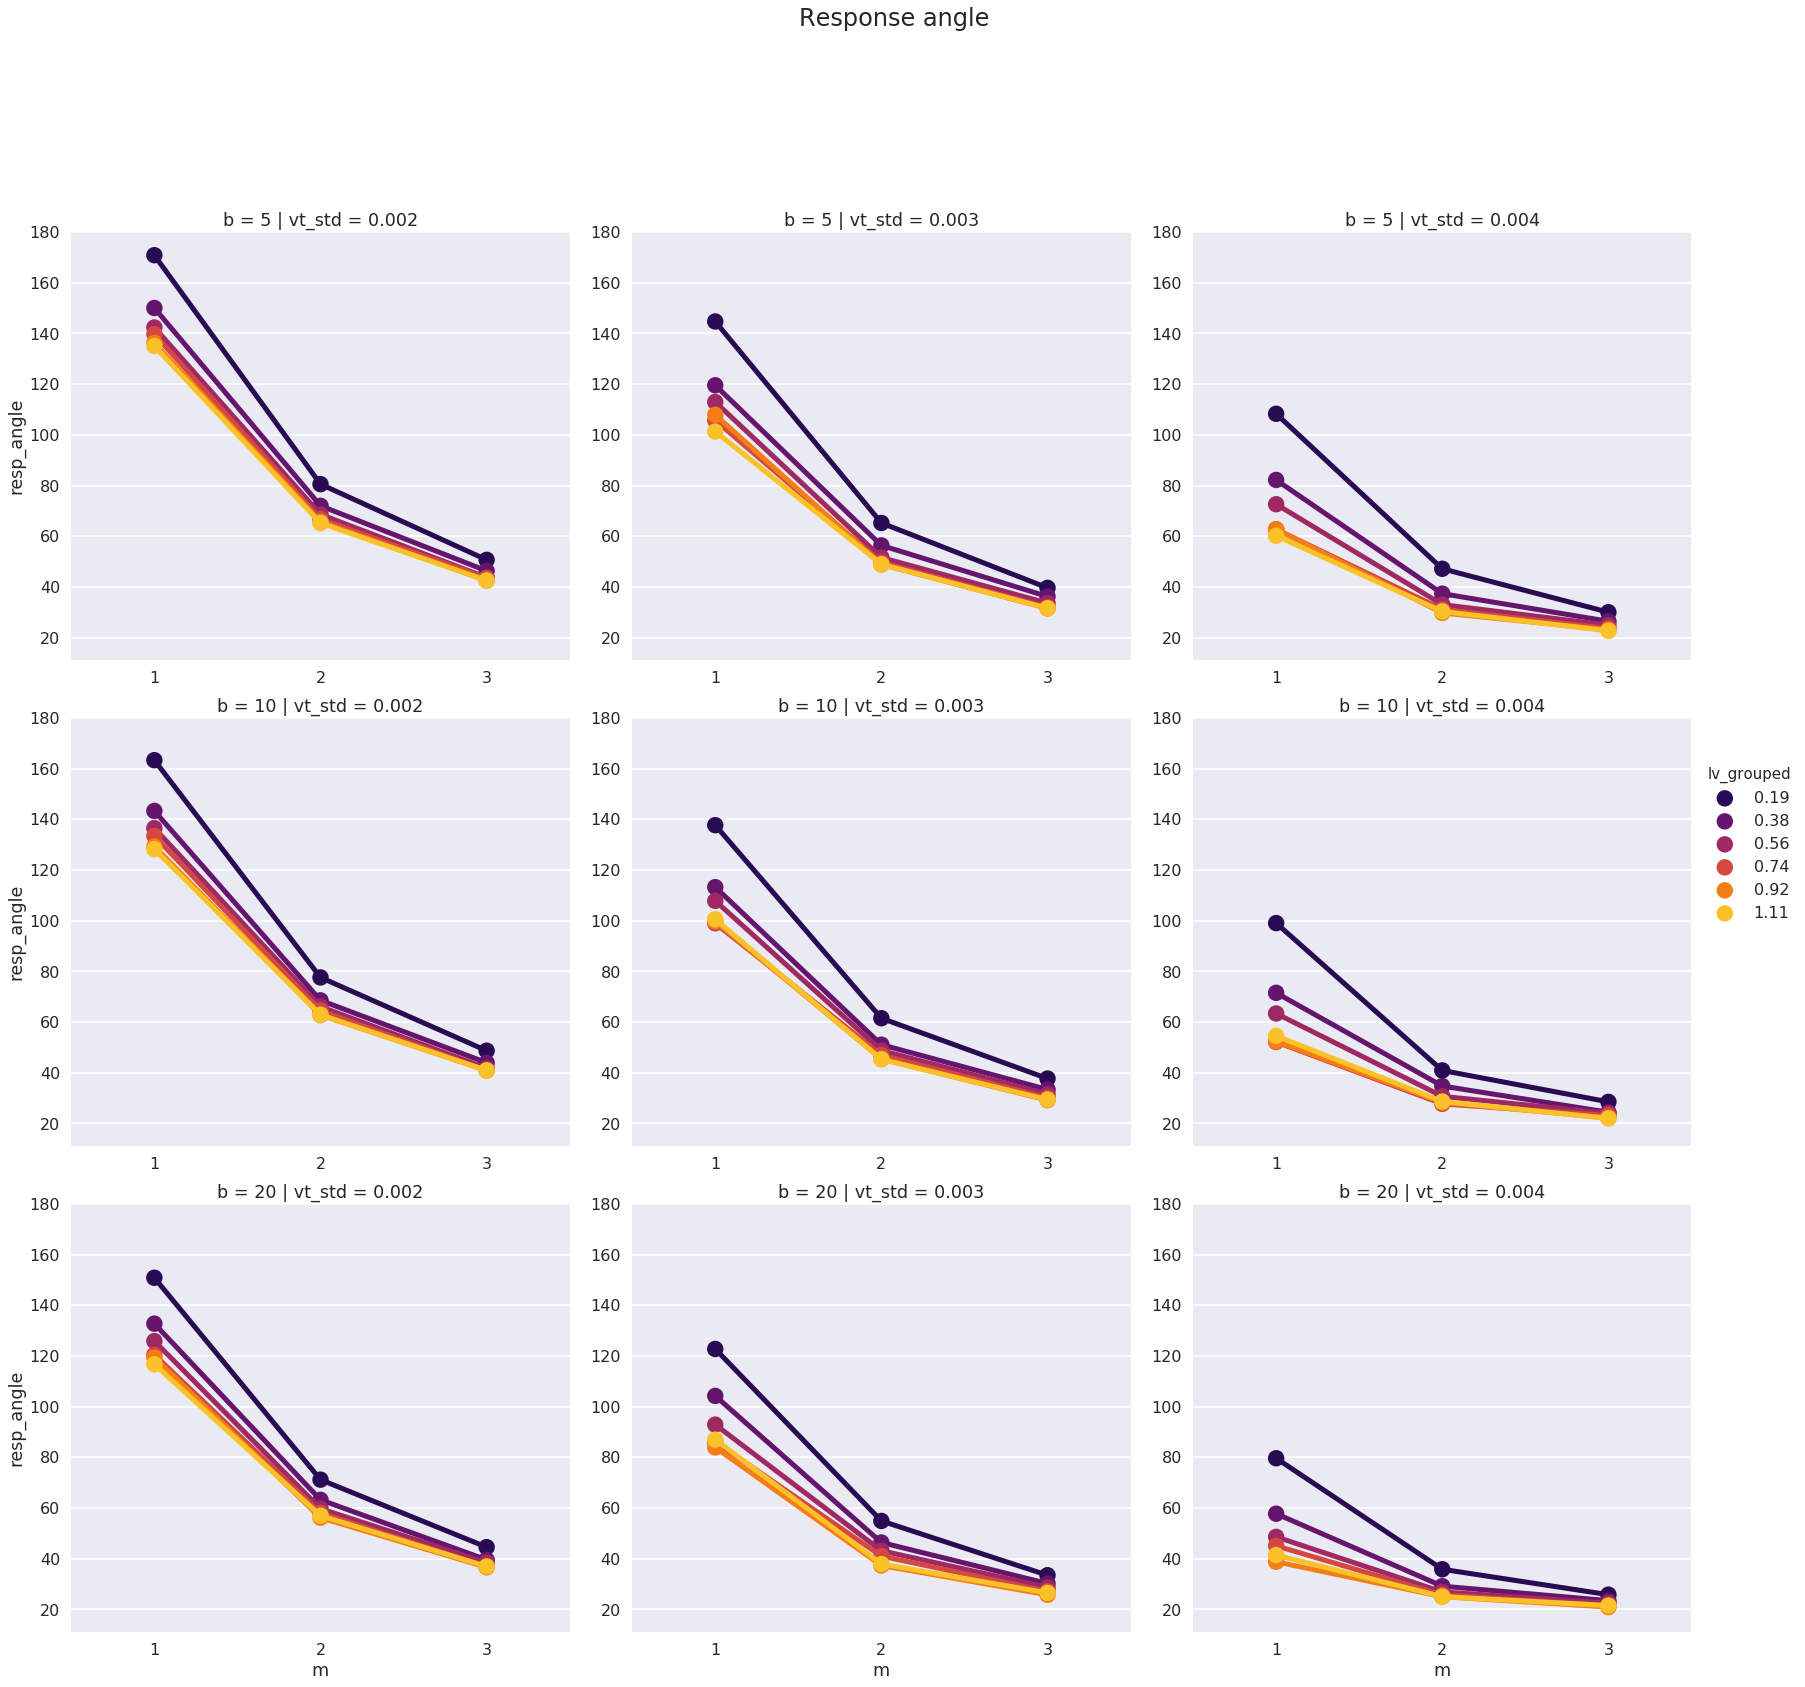

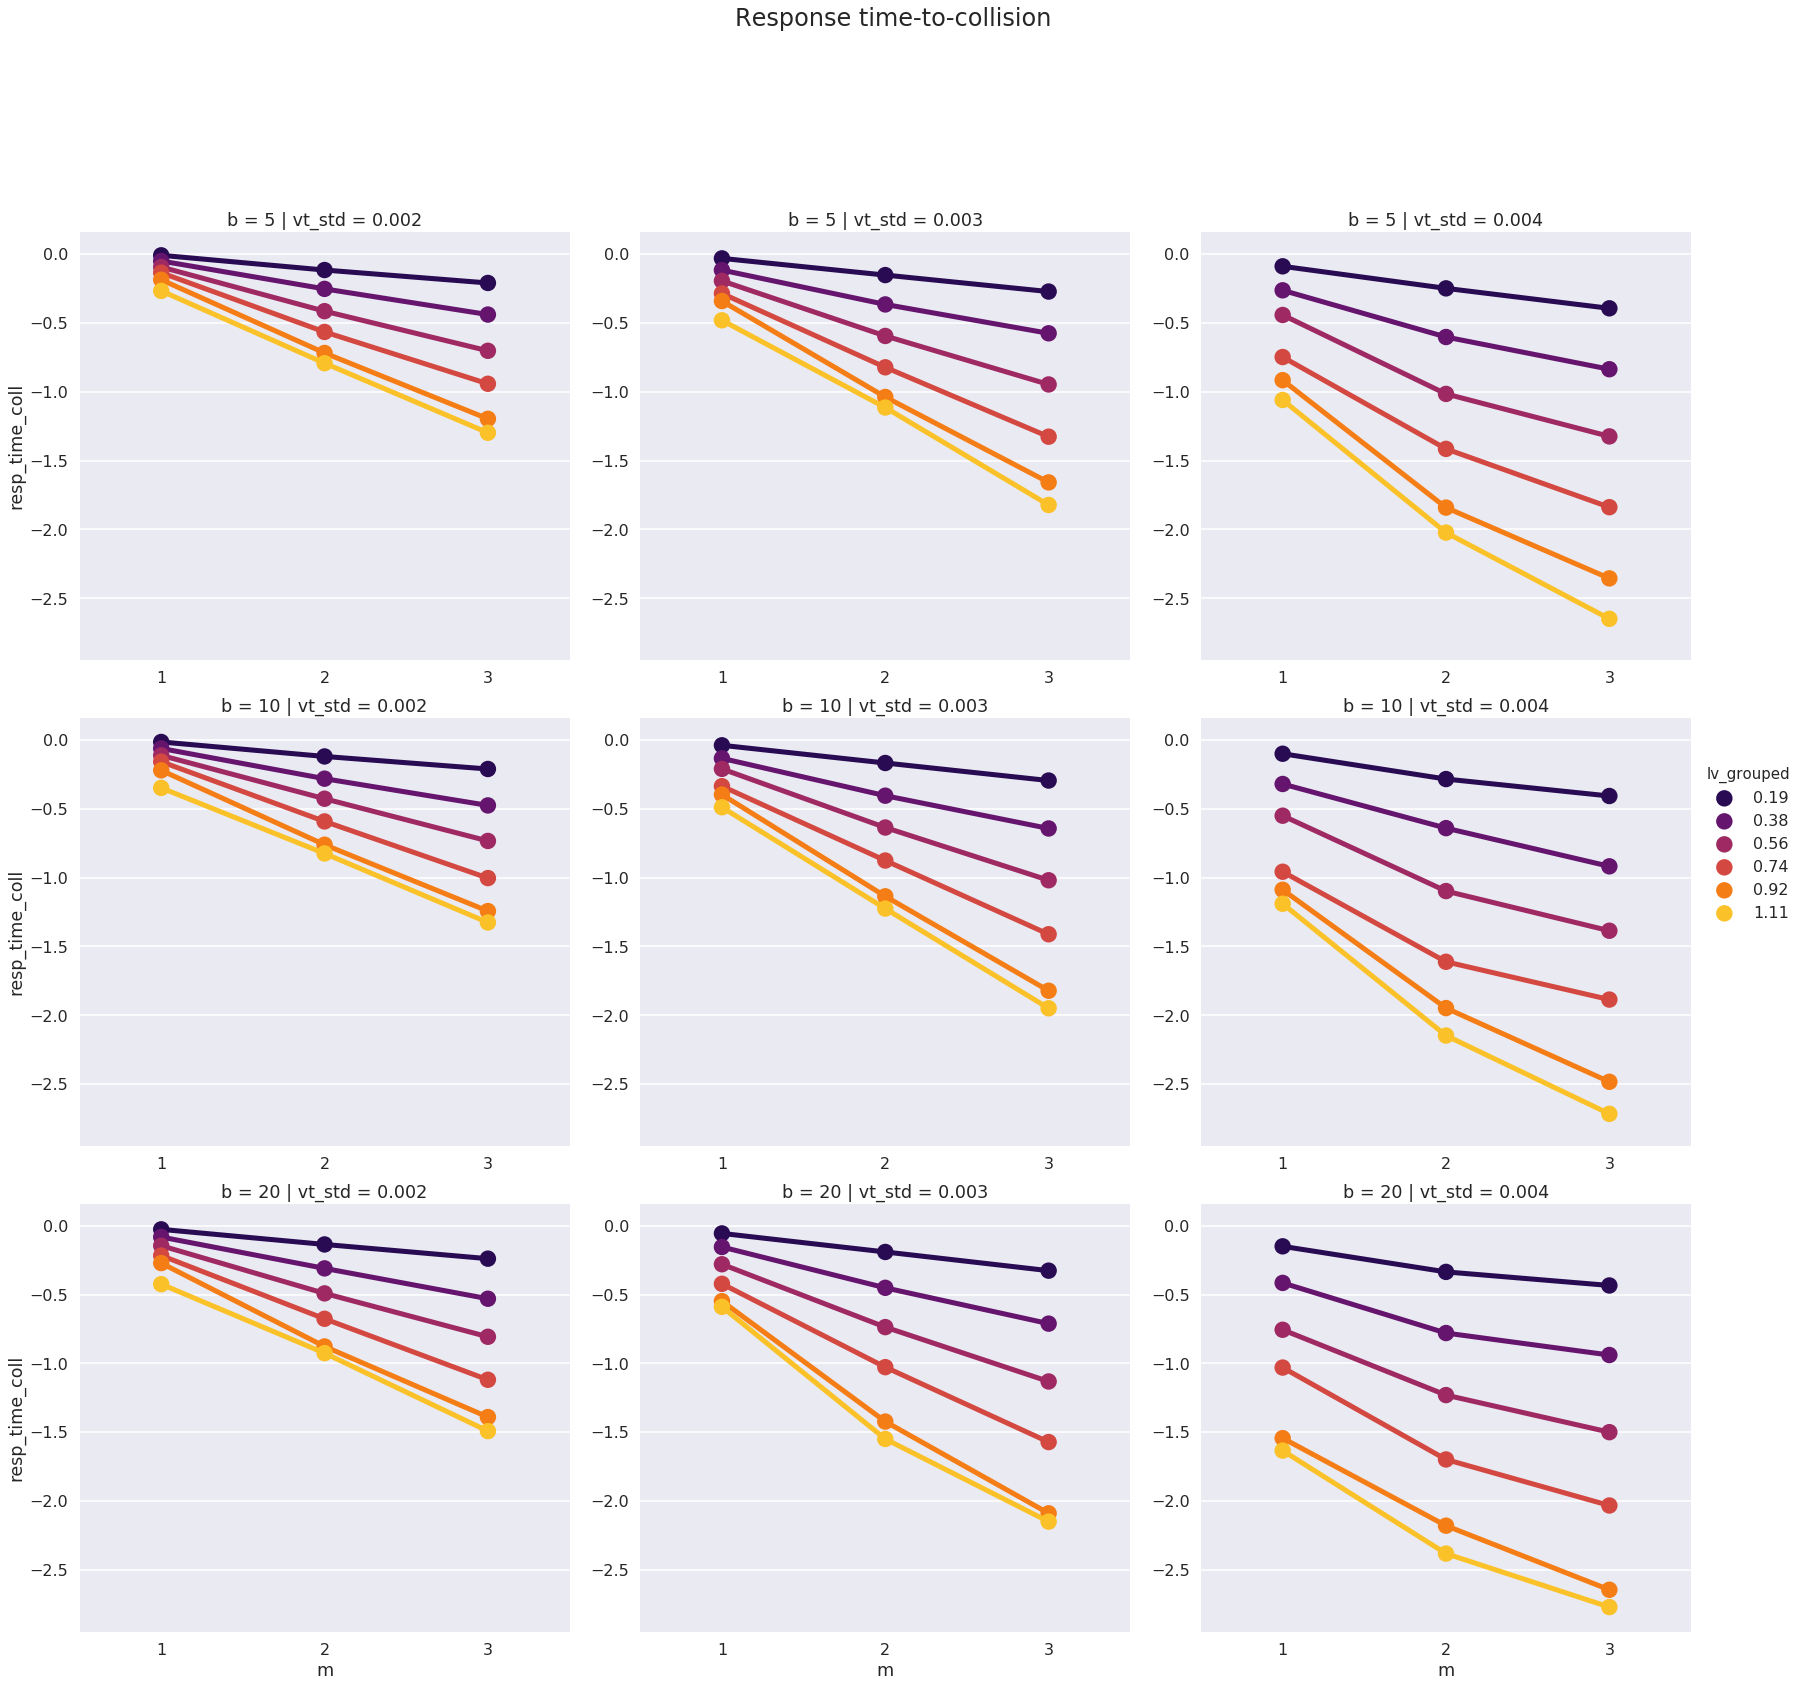

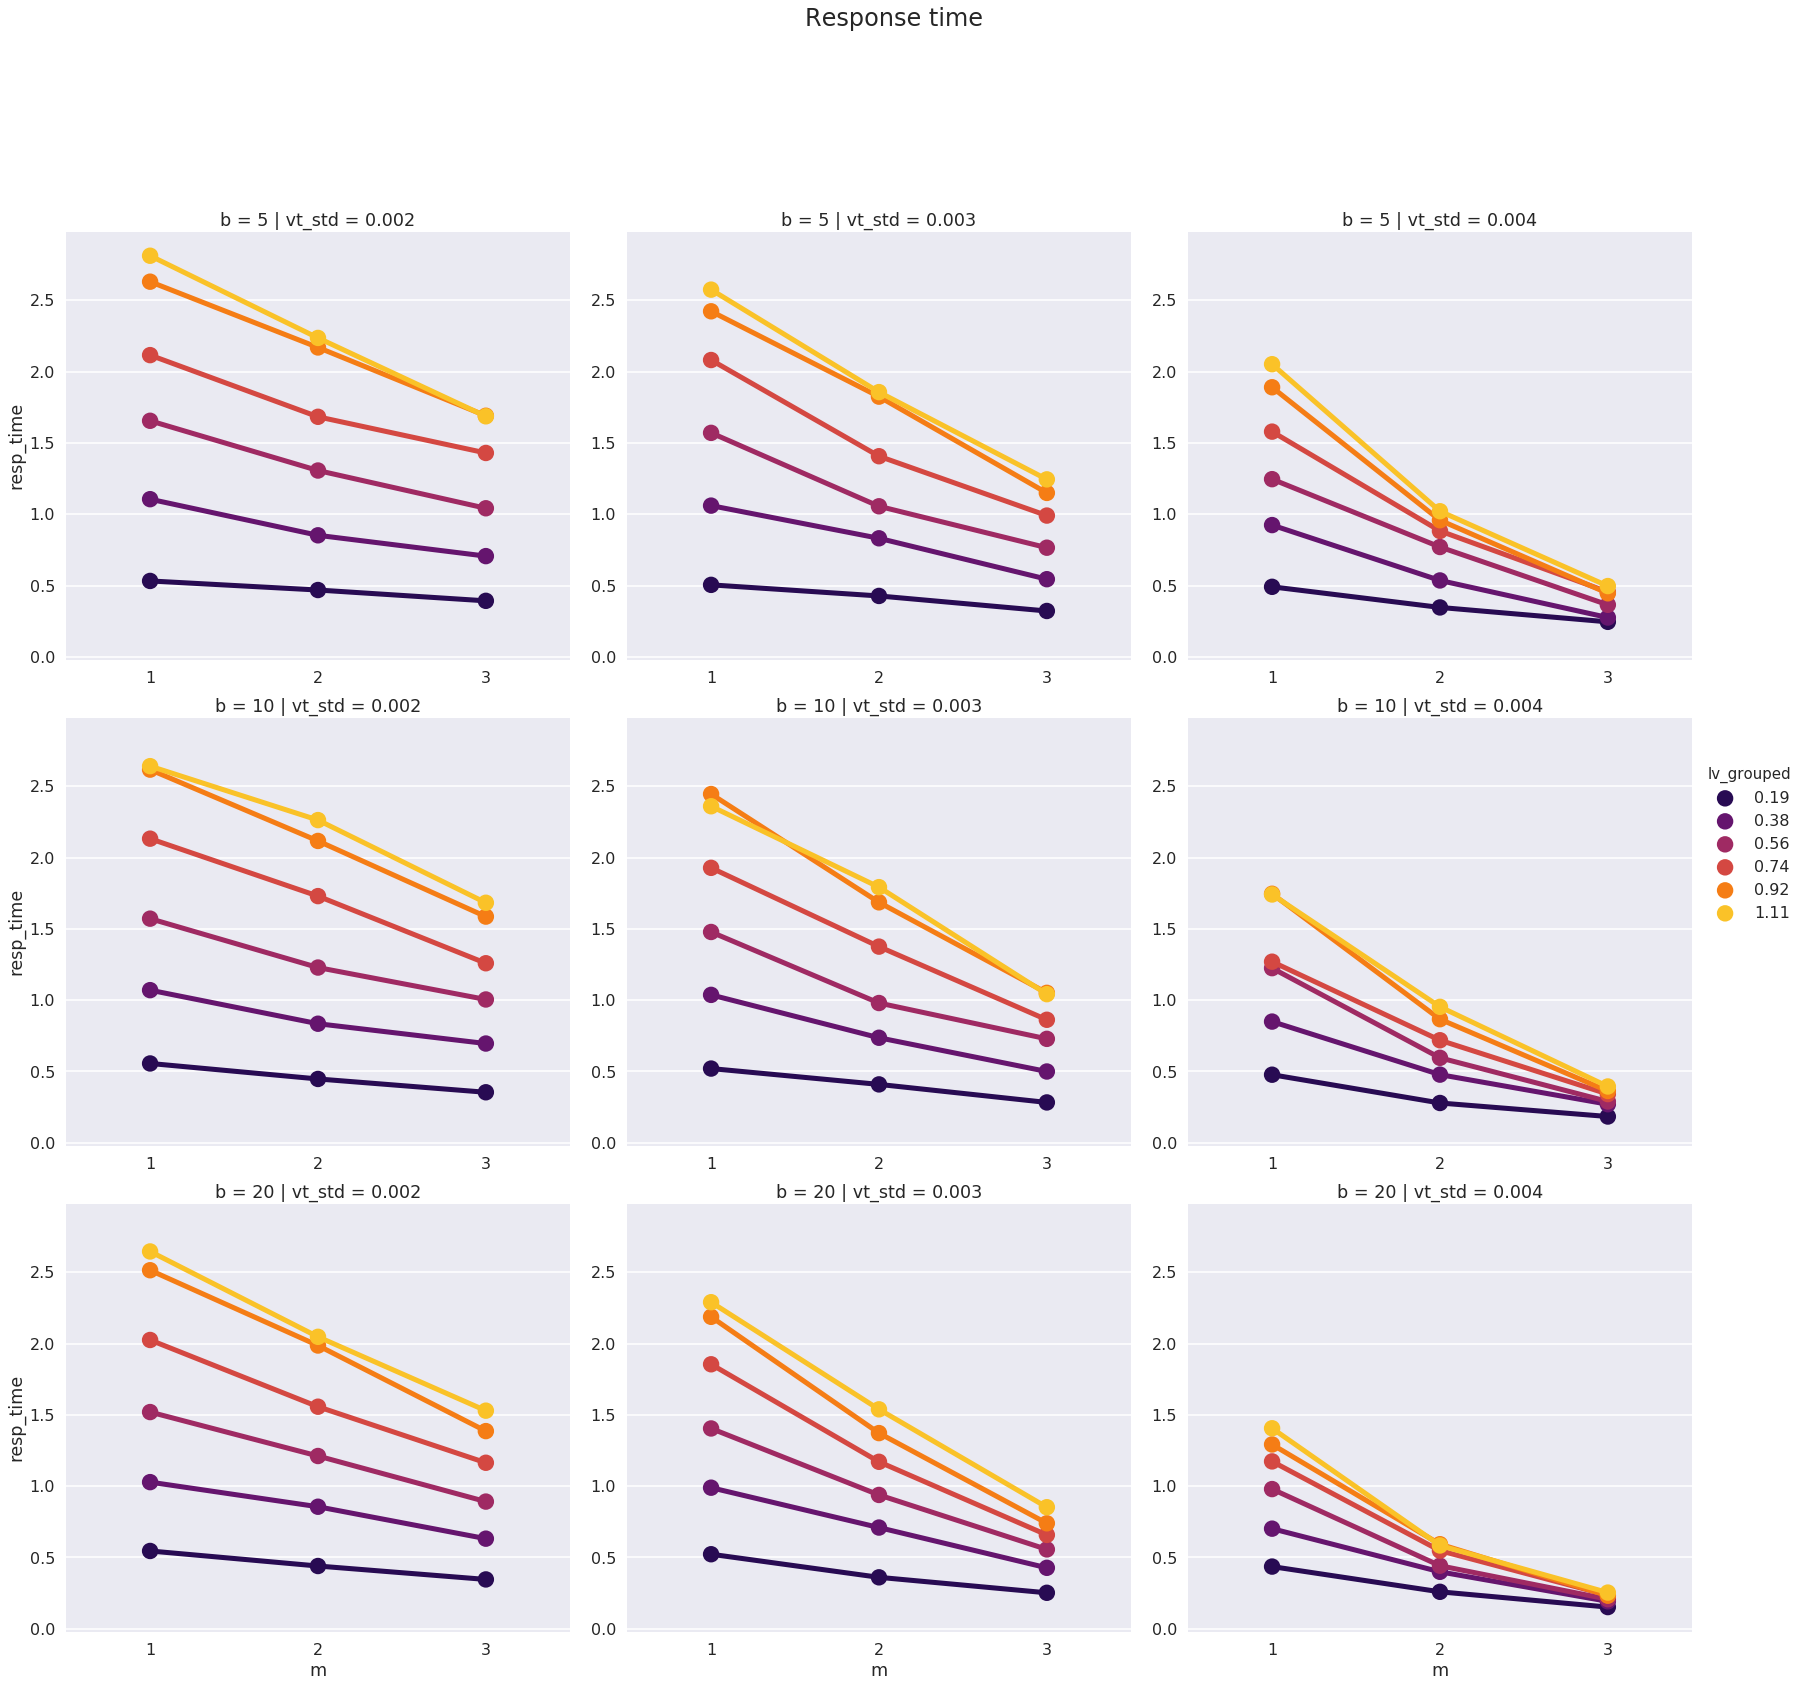

In [34]:
sns.set('poster')
g = sns.factorplot(x='m', y='resp_dist', col='vt_std', row='b', hue='lv_grouped', data=df_vt_noise_means, size=8, aspect=1,
               palette='inferno', kind='point')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Response distance', fontsize=24)
g.savefig('resp_dist_means.pdf')

g = sns.factorplot(x='m', y='resp_angle', col='vt_std', row='b', hue='lv_grouped', data=df_vt_noise_means, size=8, aspect=1,
               palette='inferno', kind='point')
#plt.ylim([0, 100])
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Response angle', fontsize=24)
g.savefig('resp_angle_means.pdf')

g = sns.factorplot(x='m', y='resp_time_coll', col='vt_std', row='b', hue='lv_grouped', data=df_vt_noise_means, size=8, aspect=1,
               palette='inferno', kind='point')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Response time-to-collision', fontsize=24)
g.savefig('resp_time_coll_means.pdf')

g = sns.factorplot(x='m', y='resp_time', col='vt_std', row='b', hue='lv_grouped', data=df_vt_noise_means, size=8, aspect=1,
               palette='inferno', kind='point')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Response time', fontsize=24)
g.savefig('resp_time_means.pdf')